# Set Parameters

In [1]:
PAT_NOW = "S23_199"
PAT_SHORT_NAME = "S_199"

MOOD_TRACKING_SHEET_PATH = f'/home/klab/NAS/Analysis/AudioFacialEEG/Behavioral Labeling/Mood_Tracking.xlsx'

BEHAVIORAL_LABELS_SHEET_PATH = f'/home/klab/NAS/Analysis/AudioFacialEEG/Behavioral Labeling/Behavior_Labeling.xlsx'

VIDEO_TIMESTAMPS_SHEET_PATH = f'/home/klab/NAS/Analysis/AudioFacialEEG/Behavioral Labeling/videoDateTimes/VideoDatetimes{PAT_SHORT_NAME[1:]}.xlsx'

OPENFACE_OUTPUT_DIRECTORY = f'/home/klab/NAS/Analysis/outputs_OpenFace/{PAT_NOW}/'
COMBINED_OUTPUT_DIRECTORY = f'/home/klab/NAS/Analysis/outputs_Combined/{PAT_NOW}/'

RUNTIME_VAR_PATH = '/home/klab/NAS/Analysis/AudioFacialEEG/Runtime_Vars/'
RESULTS_PATH_BASE = f'/home/klab/NAS/Analysis/AudioFacialEEG/Results/{PAT_SHORT_NAME}/'
FEATURE_VIS_PATH = f'/home/klab/NAS/Analysis/AudioFacialEEG/Feature_Visualization/{PAT_SHORT_NAME}/'
FEATURE_LABEL_PATH = '/home/klab/NAS/Analysis/AudioFacialEEG/Feature_Labels/'
QC_PATH = '/home/klab/NAS/Analysis/AudioFacialEEG/Quality_Control/'

In [2]:
EMO_FEATURE_SETTING = 2

# 0 - Our Custom AU --> Emotions, with all emotions
# 1 - Our Custom AU --> Emotions, with just OpenDBM's emotions
# 2 - OpenDBM's AU--> Emotions

In [3]:
STATS_FEATURE_SETTING = 3

# 0 - Our new features (including autocorrelation, kurtosis, etc.)
# 1 - Our new features, excluding extras like autocorrelation and kurtosis
# 2 - Just pres_pct
# 3 - Our new features, excluding extras. Do NOT threshold AUs before computing metrics. HSE gets 5 event features. OGAU gets num events and presence percent.

In [4]:
NORMALIZE_DATA = 0

# 0 - No time series normalization
# 1 - Yes time series normalization (for each time window)

# Installs & Setup

In [7]:

import pandas as pd
import numpy as np
import os



/tmp/ipykernel_147470/2420074471.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [8]:
import warnings
import pandas as pd

# Ignore all warnings
pd.options.mode.chained_assignment = None
pd.set_option('mode.chained_assignment', None)
warnings.filterwarnings('ignore')


# Runtime Variables

In [9]:
# SAVE VARIABLES
import pickle


def get_var_name(our_variable):
    namespace = globals()
    for name, obj in namespace.items():
        if obj is our_variable:
            return name
    return None

# Save the dictionary to a file using pickle
def save_var(our_variable, RUNTIME_VAR_PATH=RUNTIME_VAR_PATH, forced_name=None):
  if forced_name is None:
    name_now = get_var_name(our_variable)
  else:
    name_now = forced_name

  with open(RUNTIME_VAR_PATH + f'{name_now}.pkl', 'wb') as file:
      pickle.dump(our_variable, file)

def load_var(variable_name, RUNTIME_VAR_PATH=RUNTIME_VAR_PATH):
  # Load from the file
  with open(RUNTIME_VAR_PATH + f'{variable_name}.pkl', 'rb') as file:
      return pickle.load(file)


# Mood Tracking Sheet

In [10]:
df = pd.read_excel(MOOD_TRACKING_SHEET_PATH, sheet_name=f'{PAT_SHORT_NAME}')

In [11]:
## Preprocess the mood tracking sheet

# Replace the P_number mood headers with just the mood
# df.columns = df.columns.str.replace('P[0-9]+ ', '')

# Properly deal with the missing values
df = df.replace('', np.nan).replace(' ', np.nan).fillna(value=np.nan)

df_moodTracking = df

In [12]:

df_moodTracking[0:4]

,Datetime,Anxiety,Depression,Mood,Pain,Hunger,P1 Interest,P2 Distressed,P3 Excited,P4 Upset,...,P12 Alert,P13 Ashamed,P14 Inspired,P15 Nervous,P16 Determined,P17 Attentive,P18 Jittery,P19 Active,P20 Afraid,PANAS_SUM
0,2023-01-04 10:41:00,1.0,1.0,9.0,5.0,6.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-04 13:26:00,1.0,0.0,7.0,3.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-04 14:51:00,1.0,0.0,8.0,3.0,2.0,5.0,1.0,4.0,1.0,...,3.0,1.0,4.0,4.0,5.0,4.0,1.0,2.0,3.0,56.0
3,2023-02-04 12:28:00,3.0,1.0,7.0,4.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:

import numpy as np

# create lists to hold the positive and negative affect items
pos_items = [1, 3, 5, 9, 10, 12, 14, 16, 17, 19]
neg_items = [2, 4, 6, 7, 8, 11, 13, 15, 18, 20]

# get all columns that start with 'P' and split them into pos and neg groups
P_cols = [col for col in df_moodTracking.columns if col.startswith('P') and not(col.startswith('Pain')) and not(col.startswith('PANAS')) and not(col.startswith('Positive'))]
pos_cols = [col for col in P_cols if int(col[1:3]) in pos_items]
neg_cols = [col for col in P_cols if int(col[1:3]) in neg_items]

# create new columns for the summed scores
df_moodTracking['Positive Affect Score'] = df_moodTracking[pos_cols].fillna(0).astype(int).sum(axis=1, skipna=True)
df_moodTracking['Negative Affect Score'] = df_moodTracking[neg_cols].fillna(0).astype(int).sum(axis=1, skipna=True)
df_moodTracking['Overall Affect Score'] = df_moodTracking[['Positive Affect Score', 'Negative Affect Score']].fillna(0).astype(int).sum(axis=1, skipna=True)

# replace 0s with NaNs in columns 'Positive Affect Score' and 'Negative Affect Score'
df_moodTracking[['Positive Affect Score', 'Negative Affect Score', 'Overall Affect Score']] = \
            df_moodTracking[['Positive Affect Score', 'Negative Affect Score', 'Overall Affect Score']].replace(0, np.nan)

# drop the original P columns used to create the scores
df_moodTracking.drop(columns=pos_cols + neg_cols, inplace=True)

In [17]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np

def normalize_columns(df, method=1):
    # Create a copy of the DataFrame
    normalized_df = df.copy()

    # Get the column names excluding 'Datetime'
    columns_to_normalize = [col for col in normalized_df.columns if col != 'Datetime']

    if method == 1:
        # No scaling or normalization
        pass

    elif method == 2:
        # MinMax scaling to range 0 to 10
        scaler = MinMaxScaler(feature_range=(0, 10))
        normalized_df[columns_to_normalize] = scaler.fit_transform(normalized_df[columns_to_normalize])

    elif method == 3:
        # MinMax scaling to range 0 to 1
        scaler = MinMaxScaler(feature_range=(0, 1))
        normalized_df[columns_to_normalize] = scaler.fit_transform(normalized_df[columns_to_normalize])

    elif method == 4:
        # Log scaling
        normalized_df[columns_to_normalize] = normalized_df[columns_to_normalize].astype(float)
        normalized_df[columns_to_normalize] = np.log1p(normalized_df[columns_to_normalize])

    elif method == 5:
        # Standard normalization (Z-score normalization)
        scaler = StandardScaler()
        normalized_df[columns_to_normalize] = scaler.fit_transform(normalized_df[columns_to_normalize])

    else:
        raise ValueError("Invalid method. Choose a value between 1 and 5.")

    return normalized_df

In [18]:
df_moodTracking = normalize_columns(df_moodTracking, method=2)

In [19]:
df_moodTracking

,Datetime,Anxiety,Depression,Mood,Pain,Hunger,PANAS_SUM,Positive Affect Score,Negative Affect Score,Overall Affect Score
0,2023-01-04 10:41:00,2.0,5.0,8.333333,10.000000,10.0,NaN,NaN,NaN,NaN
1,2023-01-04 13:26:00,2.0,0.0,5.000000,3.333333,5.0,NaN,NaN,NaN,NaN
2,2023-01-04 14:51:00,2.0,0.0,6.666667,3.333333,0.0,0.000000,0.000000,4.444444,0.000000
3,2023-02-04 12:28:00,6.0,5.0,5.000000,6.666667,5.0,NaN,NaN,NaN,NaN
4,2023-02-04 13:33:00,2.0,5.0,5.000000,3.333333,5.0,NaN,NaN,NaN,NaN
5,2023-03-04 12:35:00,2.0,5.0,6.666667,6.666667,7.5,7.142857,7.142857,4.444444,7.142857
6,2023-03-04 14:23:00,2.0,5.0,6.666667,0.000000,7.5,NaN,NaN,NaN,NaN
7,2023-03-04 16:00:00,2.0,0.0,5.000000,3.333333,7.5,1.428571,7.142857,0.000000,1.428571
8,2023-04-04 10:15:00,2.0,5.0,3.333333,3.333333,10.0,0.000000,0.000000,4.444444,0.000000
9,2023-04-04 12:36:00,2.0,5.0,3.333333,6.666667,5.0,NaN,NaN,NaN,NaN


# Video Timestamps

In [20]:
df_videoTimestamps = pd.read_excel(VIDEO_TIMESTAMPS_SHEET_PATH, sheet_name=f'VideoDatetimes_{PAT_SHORT_NAME.split("_")[-1]}')
df_videoTimestamps['Filename'] = df_videoTimestamps['Filename'].str.replace('.m2t', '')

if PAT_SHORT_NAME == 'S_199':
  # There's no H01 video, so let's drop that filename
  df_videoTimestamps = df_videoTimestamps.drop(211)

In [23]:
# Check for any missing videos!

def print_difference(list1, list2):
    for item in list1:
        if item not in list2:
            print(item)

filenames_master_list = list(df_videoTimestamps['Filename'].values)
filenames_we_have = [i[:-4] for i in os.listdir(COMBINED_OUTPUT_DIRECTORY)]

print_difference(filenames_master_list, filenames_we_have)

In [24]:
df_videoTimestamps[-5:]

,Filename,VideoStart,VideoEnd
206,3332YX00,2023-04-09 11:04:43,2023-04-09 12:04:43
207,3332YX01,2023-04-09 12:04:43,2023-04-09 13:04:35
208,3332YY00,2023-04-09 13:04:43,2023-04-09 14:04:42
209,3332Z100,2023-04-09 14:14:03,2023-04-09 15:12:06
210,48220H00,2023-03-31 15:35:06,2023-03-31 16:35:06


# Danny's Labels (Smile, Laugh, etc.)

In [25]:
df = pd.read_excel(BEHAVIORAL_LABELS_SHEET_PATH, sheet_name=PAT_NOW)

columns_to_keep = ['Filename', 'Time Start', 'Time End', 'Behavior']  # List of columns to keep

df = df[columns_to_keep]

df['Behavior'] = df['Behavior'].str.lower()

Danny_Labels = df

In [26]:
Danny_Labels

,Filename,Time Start,Time End,Behavior
0,3332W200,00:00:00,00:20:00,resting
1,3332W200,00:20:03,00:21:00,talking with staff
2,3332W200,00:21:00,00:59:00,resting
3,3332W200,00:59:45,00:60:00,eye itchy
4,3332W201,00:00:00,00:03:00,eye itchy
...,...,...,...,...
303,3332WM01,00:50:38,00:50:43,"smile while talking, with chuckle"
304,3332WM01,00:51:00,00:60:00,talking to family
305,3332X701,00:07:59,00:10:17,"iv insertion which failed, discomfort"
306,3332X701,00:20:20,00:21:19,"second iv insertion, discomfort"


In [27]:
def filter_df_by_behavior(df, desired_string):
    # Create a copy of the DataFrame
    filtered_df = df.copy()

    # Filter the DataFrame based on the desired string within 'Behavior' column
    filtered_df = filtered_df[filtered_df['Behavior'].str.contains(desired_string)]

    # Reset the index of the filtered DataFrame
    filtered_df = filtered_df.reset_index(drop=True)

    # Return the filtered DataFrame
    return filtered_df

In [28]:
def convert_time(df1, df2):
    # df1 has time start and time end for behavior
    # df2 has mapping from filename to video start

    # Create a copy of the first DataFrame
    modified_df = df1.copy()

    # Create a dictionary mapping 'Filename' to 'VideoStart'
    filename_to_videostart = dict(zip(df2['Filename'], df2['VideoStart']))

    # Convert 'Time Start' and 'Time End' columns to datetime based on the filename
    if PAT_SHORT_NAME == 'S_150':
      # For this patient, the manual labels are in format mm:ss.

      modified_df['Time Start'] = modified_df.apply(
          lambda row: pd.to_datetime(filename_to_videostart[row['Filename']]) +
                      pd.to_timedelta('00:' + row['Time Start'] + ' minutes'),
          axis=1
      )
      modified_df['Time End'] = modified_df.apply(
          lambda row: pd.to_datetime(filename_to_videostart[row['Filename']]) +
                      pd.to_timedelta('00:' + row['Time End'] + ' minutes'),
          axis=1
      )
    else:
      # For all other patients, manual labels are in format mm:ss:00.

      modified_df['Time Start'] = modified_df.apply(
          lambda row: pd.to_datetime(filename_to_videostart[row['Filename']]) +
                      pd.to_timedelta('00:' + row['Time Start'][:-3] + ' minutes'),
          axis=1
      )
      modified_df['Time End'] = modified_df.apply(
          lambda row: pd.to_datetime(filename_to_videostart[row['Filename']]) +
                      pd.to_timedelta('00:' + row['Time End'][:-3] + ' minutes'),
          axis=1
      )

    # Return the modified DataFrame
    return modified_df


In [33]:
def buffer_neither(smiles_df, sleep_df):
    # returns a single-column pandas df with times when:
    # the surrounding 2 minutes (buffer) have neither a smile event nor a sleep event
    # note: you can replace smiles_df with any df that has events (e.g. yawns).
    # For random sampling, it's looking at a discrete list of datetimes separated by 10 seconds

    # Find the earliest and latest times from smiles_df
    smiles_earliest = smiles_df['Time Start'].min()
    smiles_latest = smiles_df['Time End'].max()

    # Find the earliest and latest times from sleep_df
    sleep_earliest = sleep_df['Time Start'].min()
    sleep_latest = sleep_df['Time End'].max()

    # Determine the start and end times
    start_time = min(smiles_earliest, sleep_earliest)
    end_time = max(smiles_latest, sleep_latest)

    # Create a DataFrame with fixed frequency for the time range
    time_range = pd.date_range(start=start_time, end=end_time, freq='10S')
    tracking_df = pd.DataFrame({'Time': time_range, 'BufferSafe': False})

    # Determine the BufferSafe column values
    for i in range(len(tracking_df)):
        time = tracking_df.loc[i, 'Time']
        buffer_before = time - pd.Timedelta(minutes=1)
        buffer_after = time + pd.Timedelta(minutes=1)

        has_smile_within_buffer = smiles_df[((smiles_df['Time Start'] <= buffer_after) & (smiles_df['Time End'] >= buffer_before))].shape[0] > 0
        has_sleep_within_buffer = sleep_df[((sleep_df['Time Start'] <= buffer_after) & (sleep_df['Time End'] >= buffer_before))].shape[0] > 0
        tracking_df.loc[i, 'BufferSafe'] = not (has_smile_within_buffer or has_sleep_within_buffer)

    # Filter the BufferSafe time intervals
    non_smile_non_sleep_buffer_times = tracking_df[tracking_df['BufferSafe']]['Time'].reset_index(drop=True)

    return non_smile_non_sleep_buffer_times


def create_event_detection_df(smiles_df, safe_series):
    # Create a new DataFrame for event detection
    event_detection_df = pd.DataFrame(columns=['Datetime', 'EventDetected'])

    # Iterate over each row in the smiles_df
    for index, row in smiles_df.iterrows():
        start_time = row['Time Start']
        end_time = row['Time End']

        # Generate a range of timestamps at a frequency of 1 second
        timestamps = pd.date_range(start=start_time, end=end_time, freq='S', inclusive='right')

        # Add each timestamp as a separate row to the event_detection_df
        for timestamp in timestamps:
            event_detection_df = pd.concat([event_detection_df, pd.DataFrame.from_records([{'Datetime': timestamp, 'EventDetected': 1}])], ignore_index=True)

    # Get the length of the smile event DataFrame
    num_smiles = len(event_detection_df)

    # Randomly sample from the buffer safe Series
    sampled_safe_series = safe_series.sample(n=num_smiles, replace=False)

    # Add nonsmile nonsleep events to the DataFrame
    nonsmile_nonsleep_times = sampled_safe_series.reset_index(drop=True)
    nonsmile_nonsleep_df = pd.DataFrame({'Datetime': nonsmile_nonsleep_times, 'EventDetected': 0})
    event_detection_df = pd.concat([event_detection_df, nonsmile_nonsleep_df], ignore_index=True)

    # Sort the DataFrame by DateTime in ascending order
    event_detection_df = event_detection_df.sort_values(by='Datetime').reset_index(drop=True)

    return event_detection_df

def get_labels(smile_string, sleep_string):
  # gets us our labels df (DateTime and EventDetected columns)
  # note: doesn't need to be smiles. Replace 'smile' with any other event as first arg.

  # smile string is what we want to detect
  # sleep string is what we label as neither smile nor non-smile
  # i.e. if a time period is labeled as sleep, exclude from dataset

  # Make sure Danny_Labels and df_videoTimestamps have been loaded in already!

  Smile_Labels = filter_df_by_behavior(Danny_Labels, smile_string)
  Sleep_Labels = filter_df_by_behavior(Danny_Labels, sleep_string)

  smiles_df = convert_time(Smile_Labels, df_videoTimestamps)
  sleep_df = convert_time(Sleep_Labels, df_videoTimestamps)

  non_smile_non_sleep_times = buffer_neither(smiles_df, sleep_df)

  return create_event_detection_df(smiles_df, non_smile_non_sleep_times)





In [34]:
# NOTE: The events are defined such that we label the END time and time window looks at 1 s preceding

# Eventually, we should run this 500 times to get range of AUROC

Final_Smile_Labels = get_labels('smile', 'sleep')

In [35]:
Final_Smile_Labels

,Datetime,EventDetected
0,2023-03-31 23:17:33,0
1,2023-03-31 23:21:33,0
2,2023-03-31 23:34:03,0
3,2023-03-31 23:48:43,0
4,2023-03-31 23:58:03,0
...,...,...
249,2023-04-02 13:38:23,0
250,2023-04-02 13:46:23,0
251,2023-04-02 14:00:03,0
252,2023-04-02 14:05:32,1


In [36]:
Final_Yawn_Labels = get_labels('yawn', 'sleep')

In [37]:
Final_Yawn_Labels

,Datetime,EventDetected
0,2023-03-31 23:15:03,0
1,2023-03-31 23:23:53,0
2,2023-03-31 23:27:43,0
3,2023-04-01 05:51:33,0
4,2023-04-01 06:17:43,0
5,2023-04-01 06:28:33,0
6,2023-04-01 07:11:53,0
7,2023-04-01 11:18:13,0
8,2023-04-01 12:11:13,0
9,2023-04-01 13:32:13,0


In [38]:
Final_Discomfort_Labels = get_labels('discomfort', 'sleep')

In [39]:
Final_Discomfort_Labels

,Datetime,EventDetected
0,2023-04-01 05:05:32,1
1,2023-04-01 05:05:32,1
2,2023-04-01 07:05:40,1
3,2023-04-01 07:30:33,0
4,2023-04-01 08:04:44,1
...,...,...
63,2023-04-08 17:50:23,0
64,2023-04-08 18:18:43,0
65,2023-04-08 19:33:03,0
66,2023-04-09 12:49:33,0


In [40]:
Final_Sad_Labels = get_labels('sad', 'sleep')

In [41]:
Final_Sad_Labels

,Datetime,EventDetected
0,2023-04-01 08:52:53,0
1,2023-04-01 12:21:53,0
2,2023-04-01 13:54:53,0
3,2023-04-01 22:35:43,0
4,2023-04-02 01:01:23,0
5,2023-04-02 03:03:33,0
6,2023-04-02 04:31:43,0
7,2023-04-02 04:56:23,0
8,2023-04-02 07:23:53,0
9,2023-04-02 09:05:03,1


# OpenFace

In [42]:
# DICTIONARY OF SEPARATE DFS

def get_dict_openface(output_dir):
  # Create an empty dictionary to hold the DataFrames
  dfs_openface = {}

  # Get a list of all the CSV files in the directory
  csv_files = sorted([f for f in os.listdir(output_dir) if f.endswith('.csv')])

  # list of columns to keep
  columns_to_keep = ['frame', ' timestamp', ' success',
                    ' AU01_r',
                    ' AU02_r',
                    ' AU04_r',
                    ' AU05_r',
                    ' AU06_r',
                    ' AU07_r',
                    ' AU09_r',
                    ' AU10_r',
                    ' AU12_r',
                    ' AU14_r',
                    ' AU15_r',
                    ' AU17_r',
                    ' AU20_r',
                    ' AU23_r',
                    ' AU25_r',
                    ' AU26_r',
                    ' AU45_r',
                    ' AU01_c',
                    ' AU02_c',
                    ' AU04_c',
                    ' AU05_c',
                    ' AU06_c',
                    ' AU07_c',
                    ' AU09_c',
                    ' AU10_c',
                    ' AU12_c',
                    ' AU14_c',
                    ' AU15_c',
                    ' AU17_c',
                    ' AU20_c',
                    ' AU23_c',
                    ' AU25_c',
                    ' AU26_c',
                    ' AU45_c']

  # Loop through the CSV files
  for csv_file in csv_files:
      # Load data into a pandas df
      csv_file_path = os.path.join(output_dir, csv_file)
      df_temp = pd.read_csv(csv_file_path)

      # keep every 6th row such that it's 5 fps!
      X = 6
      df_temp = df_temp[df_temp.index % X == 0]

      # filter DataFrame to keep only columns in list
      df_temp = df_temp.loc[:, columns_to_keep]

      # fix column names to not have leading or trailing spaces!
      df_temp = df_temp.rename(columns=lambda x: x.strip())

      # Store the DataFrame in the dictionary with the csv file name as the key
      # remove the '.csv' by doing csv_file[:-4]
      dfs_openface[csv_file[:-4]] = df_temp
      del df_temp

  return dfs_openface


def only_successful_frames(df):
    # get frames where AU/emotion detection was successful!
    return df[df['success'] == 1]

def apply_function_to_dict(dictionary, func, **kwargs):
    """
    Apply a function to each DataFrame in a dictionary and return a modified copy of the dictionary.

    Args:
        dictionary (dict): The dictionary containing DataFrames.
        func (function): The function to apply to each DataFrame.
        **kwargs: Additional keyword arguments to pass to the function.

    Returns:
        dict: A modified copy of the dictionary with the function applied to each DataFrame.
    """
    return {key: func(df, **kwargs) for key, df in dictionary.items()}

In [43]:
dfs_openface = get_dict_openface(OPENFACE_OUTPUT_DIRECTORY)
dfs_openface = apply_function_to_dict(dfs_openface, only_successful_frames)

In [44]:
# SAVE THE OPENFACE DICTIONARY

save_var(dfs_openface, forced_name=f'dfs_openface_{PAT_SHORT_NAME}')

In [ ]:
# LOAD THE OPENFACE DICTIONARY

dfs_openface = load_var(f'dfs_openface_{PAT_SHORT_NAME}')


In [45]:
# RAM CHECK

import sys
sumsize = 0
for i in list(globals().keys()):
  size = sys.getsizeof(globals()[i])
  # print(i, ': ', size)
  sumsize = sumsize + size

print(f'Total variables in RAM: {sumsize / (1024 ** 2)} MB')

Total variables in RAM: 0.3589439392089844 MB


In [ ]:
# CLEAR UP RAM

for key in list(globals().keys()):
    if (key.startswith('_i') and key != '_ih') or (key.startswith('_') and key[1:].isdigit()):
        del globals()[key]

In [ ]:
dfs_openface['3332W200']

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# List to store the average percentages
avg_percentages = []

# Iterate over each column ending with '_c'
for column in dfs_openface['3332W200'].filter(regex='_c$').columns:
    # Calculate the percentage of zeros for each key in the dictionary
    percentages = [df[column].value_counts(normalize=True)[0] * 100 for df in dfs_openface.values()]

    # Calculate the average percentage
    avg_percentage = np.mean(percentages)
    avg_percentages.append(avg_percentage)

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(dfs_openface['3332W200'].filter(regex='_c$').columns, avg_percentages, width=0.6)  # Adjust width as desired

# Set labels and title
ax.set_xlabel('Columns')
ax.set_ylabel('Average Percentage of Zeros')
ax.set_title(f'Average Percentage of Zeros for Classification Columns, Threshold = Default')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.savefig(RESULTS_PATH_BASE + f'openface_threshold_default.png', bbox_inches='tight')

# HSEmotion & OpenGraphAU

In [46]:
import pandas as pd
import os

def get_dict(output_dir, file_now='outputs_hse.csv', filterOutLR=True):

  # Initialize an empty dictionary to store the dataframes
  df_dict = {}

  # Loop through the subfolders in alphabetical order
  for subfolder_name in sorted(os.listdir(output_dir)):

    # Check if the subfolder contains CSV files
    subfolder_path = os.path.join(output_dir, subfolder_name)
    if not os.path.isdir(subfolder_path):
      continue

    # Load the first CSV file in the subfolder into a dataframe
    csv_file_path = os.path.join(subfolder_path, file_now)
    if not os.path.isfile(csv_file_path):
      continue

    try:
      df_temp = pd.read_csv(csv_file_path)
    except:
      df_temp = pd.DataFrame(columns=['frame', 'timestamp', 'success', 'AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU7', 'AU9',
       'AU10', 'AU11', 'AU12', 'AU13', 'AU14', 'AU15', 'AU16', 'AU17', 'AU18',
       'AU19', 'AU20', 'AU22', 'AU23', 'AU24', 'AU25', 'AU26', 'AU27', 'AU32',
       'AU38', 'AU39'])


    # OpenGraphAU - we are filtering out L and R!
    if filterOutLR:
      df_temp = df_temp.filter(regex='^(?!AUL|AUR)')

    # Add the dataframe to the dictionary with the subfolder name as the key
    # We do [:-4] to remove '.mp4' from the end of the string
    df_dict[subfolder_name[:-4]] = df_temp

  return df_dict

def create_binary_columns(df, threshold):
    df_copy = df.copy()
    # adds classification columns to opengraphAU
    for col in df_copy.columns:
        if col.startswith('AU'):
            # Add _c to the column name for the new column
            new_col_name = col + '_c'
            # Apply the binary classification to the new column
            df_copy[new_col_name] = df_copy[col].apply(lambda x: 1 if x >= threshold else 0)
            # Add _r to the original column name
            df_copy = df_copy.rename(columns={col: col + '_r'}, inplace=False)
    return df_copy

def remove_columns_ending_with_r(df):
    columns_to_drop = [col for col in df.columns if col.endswith('_r')]
    df = df.drop(columns=columns_to_drop, inplace=False)
    return df


def only_successful_frames(df):
    # get frames where AU/emotion detection was successful!
    return df[df['success'] == 1]


def apply_function_to_dict(dictionary, func, **kwargs):
    """
    Apply a function to each DataFrame in a dictionary and return a modified copy of the dictionary.

    Args:
        dictionary (dict): The dictionary containing DataFrames.
        func (function): The function to apply to each DataFrame.
        **kwargs: Additional keyword arguments to pass to the function.

    Returns:
        dict: A modified copy of the dictionary with the function applied to each DataFrame.
    """
    return {key: func(df, **kwargs) for key, df in dictionary.items()}

In [47]:
dfs_hsemotion = get_dict(COMBINED_OUTPUT_DIRECTORY, file_now='outputs_hse.csv')
dfs_hsemotion = apply_function_to_dict(dfs_hsemotion, only_successful_frames)

In [48]:
OPENGRAPHAU_THRESHOLD = 0.5
dfs_opengraphau = get_dict(COMBINED_OUTPUT_DIRECTORY, file_now='outputs_ogau.csv')
dfs_opengraphau = apply_function_to_dict(dfs_opengraphau, create_binary_columns, threshold=OPENGRAPHAU_THRESHOLD)
dfs_opengraphau = apply_function_to_dict(dfs_opengraphau, only_successful_frames)
dfs_opengraphau = apply_function_to_dict(dfs_opengraphau, remove_columns_ending_with_r)

In [49]:
# SAVE THE HSEMOTION AND OPENGRAPHAU DICTIONARIES

save_var(dfs_hsemotion, forced_name=f'dfs_hsemotion_{PAT_SHORT_NAME}')

save_var(dfs_opengraphau, forced_name=f'dfs_opengraphau_{PAT_SHORT_NAME}')

In [ ]:
# LOAD THE HSEMOTION AND OPENGRAPHAU DICTIONARIES

dfs_hsemotion = load_var(f'dfs_hsemotion_{PAT_SHORT_NAME}')

dfs_opengraphau = load_var(f'dfs_opengraphau_{PAT_SHORT_NAME}')


## Mood Tracking - Testing

In [ ]:
dfs_opengraphau['61901L00'].columns

In [ ]:
dfs_hsemotion['3332W200']

In [ ]:
dfs_opengraphau['3332W200']

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# List to store the average percentages
avg_percentages = []

# Iterate over each column ending with '_c'
for column in dfs_opengraphau['3332W200'].filter(regex='_c$').columns:
    # Calculate the percentage of zeros for each key in the dictionary
    percentages = [df[column].value_counts(normalize=True)[0] * 100 for df in dfs_opengraphau.values()]

    # Calculate the average percentage
    avg_percentage = np.mean(percentages)
    avg_percentages.append(avg_percentage)

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(dfs_opengraphau['3332W200'].filter(regex='_c$').columns, avg_percentages, width=0.6)  # Adjust width as desired

# Set labels and title
ax.set_xlabel('Columns')
ax.set_ylabel('Average Percentage of Zeros')
ax.set_title(f'Average Percentage of Zeros for Classification Columns, Threshold = {OPENGRAPHAU_THRESHOLD}')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.savefig(RESULTS_PATH_BASE + f'opengraphau_threshold_{OPENGRAPHAU_THRESHOLD}.png', bbox_inches='tight')

## Smile, Yawn, Etc.

In [50]:
dfs_opengraphau = get_dict(COMBINED_OUTPUT_DIRECTORY, file_now='outputs_ogau.csv')
dfs_opengraphau = apply_function_to_dict(dfs_opengraphau, only_successful_frames)


In [51]:
# SAVE DF HSEMOTION
save_var(dfs_hsemotion, forced_name=f'dfs_hsemotion_{PAT_SHORT_NAME}')


In [52]:
# SAVE DF OPENGRAPHAU WITHOUT ANY THRESHOLDING
save_var(dfs_opengraphau, forced_name=f'dfs_opengraphau_smile_{PAT_SHORT_NAME}')

In [ ]:
# LOAD VARS FOR BEHAVIOR PREDICTION
# NO THRESHOLDING FOR DF OPENGRAPHAU

dfs_hsemotion = load_var(f'dfs_hsemotion_{PAT_SHORT_NAME}')

dfs_opengraphau = load_var(f'dfs_opengraphau_smile_{PAT_SHORT_NAME}')

## Debug

In [ ]:
# CHECK FOR EMPTY CSVs IN ALL FOLDERS

import os
import pandas as pd

# Replace this with your specific root path
root_path = COMBINED_OUTPUT_DIRECTORY

# Loop through all subdirectories in the root path
for subdir, dirs, files in os.walk(root_path):
    for file in files:
        # Check if the current file is 'outputs_ogau.csv'
        if file == 'outputs_ogau.csv' or file == 'outputs_hse.csv':
            file_path = os.path.join(subdir, file)
            try:
                # Attempt to read the csv file
                df = pd.read_csv(file_path)

                # Check if the DataFrame is empty
                if df.empty:
                    print(f"Empty CSV in folder: {subdir}")
                # Check if the DataFrame has no columns
                elif df.shape[1] == 0:
                    print(f"No columns in CSV in folder: {subdir}")
                # Check if the DataFrame has only header but no rows
                elif df.shape[0] == 0:
                    print(f"Only header, no rows in CSV in folder: {subdir}")
            except pd.errors.EmptyDataError:
                # This exception is raised if the CSV is empty/no columns
                print(f"CSV file is empty or has no columns in folder: {subdir}")
            except Exception as e:
                print(f"An error occurred while processing file {file_path}: {e}")


# Select Specific Times

## Setup

In [53]:
def get_data_within_duration(dfs_dict, df_video_timestamps, datetime, duration):
    # Takes in:
    # dfs_dict -- a dictionary of dataframes containing csv data from one of the pipelines
    # df_video_timestamps -- the VideoDateTimes_199 csv
    # datetime -- a pd.datetime value to center our extraction
    # duration -- a duration (in minutes) BEFORE the datetime to extract

    # Outputs:
    # One dataframe with all rows we want, with timestamps converted into correct datetimes
    start_datetime = datetime - pd.Timedelta(minutes=duration)
    end_datetime = datetime

    relevant_keys = df_video_timestamps.loc[(pd.to_datetime(df_video_timestamps['VideoEnd']) >= start_datetime) &
                                            (pd.to_datetime(df_video_timestamps['VideoStart']) <= end_datetime), 'Filename'].values

    relevant_dfs = []
    for key in relevant_keys:
        if key in dfs_dict:
            video_start = pd.to_datetime(df_video_timestamps.loc[df_video_timestamps['Filename'] == key, 'VideoStart'].values[0])
            video_end = pd.to_datetime(df_video_timestamps.loc[df_video_timestamps['Filename'] == key, 'VideoEnd'].values[0])
            time_mask = ((dfs_dict[key]['timestamp'] >= (start_datetime - video_start).total_seconds()) &
                         (dfs_dict[key]['timestamp'] <= (end_datetime - video_start).total_seconds()))
            df = dfs_dict[key].loc[time_mask].copy()
            df['timestamp'] = video_start + pd.to_timedelta(df['timestamp'], unit='s')
            relevant_dfs.append(df)

    if relevant_dfs:
        df_combined = pd.concat(relevant_dfs, ignore_index=True, sort=False)
        df_combined = df_combined.drop(columns='frame')

        return df_combined

    print(f"MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: {datetime}")
    return pd.DataFrame()

def get_radius_dict(TIME_RADIUS_IN_MINUTES, INPUT_DF, df_videoTimestamps, df_moodTracking, takeAll=True):
  # takes in the:
  # --time radius,
  # --input dataframe dict (e.g. is it from OpenFace? HSEmotion?)
  # --df with video timestamps
  # --df with mood tracking patient reports
  # --takeAll - are we taking all reports, or filtering out values w/o mood (e.g. anxiety)? True = no filtering

  # returns dictionary of timestamp : df with relevant frames

  # We'll make a dictionary, with the relevant df for each datetime we have a report
  radius_df_dict = {}
  for oneIndex in range(len(df_moodTracking)):
    # Let's make sure there's a value collected (or takeAll = True)!
    if takeAll:
      dt_now = get_moodTracking_datetime(oneIndex, df_moodTracking=df_moodTracking)
      filtered_df = get_data_within_duration(INPUT_DF, df_videoTimestamps, dt_now, TIME_RADIUS_IN_MINUTES)
      radius_df_dict[dt_now] = filtered_df
    else:
      val_now = df_moodTracking[oneIndex:oneIndex+1]['Anxiety'][oneIndex]
      if isinstance(val_now, str):
        # Value was collected
        dt_now = get_moodTracking_datetime(oneIndex, df_moodTracking=df_moodTracking)
        filtered_df = get_data_within_duration(INPUT_DF, df_videoTimestamps, dt_now, TIME_RADIUS_IN_MINUTES)
        radius_df_dict[dt_now] = filtered_df
      else:
        # No value collected!
        print('No value for Anxiety for index ', oneIndex, f'corresponding to {get_moodTracking_datetime(oneIndex, df_moodTracking=df_moodTracking)}')
  return radius_df_dict

def generate_number_list(start, interval, count):
    number_list = [start + i * interval for i in range(count)]
    return number_list

def get_moodTracking_datetime(index, df_moodTracking):
  temp_var = pd.to_datetime(pd.to_datetime(df_moodTracking[index:index+1]['Datetime']).dt.strftime('%d-%b-%Y %H:%M:%S'))
  return pd.Timestamp(temp_var[index])

## Emotion/Affect

In [54]:
# EMOTION DETECTION & AFFECT

takeAll = True # we are taking all patient reports

# start and interval are in minutes
TIME_RADIUS_LIST = generate_number_list(start=15, interval=15, count=16)
#TIME_RADIUS_LIST = [60, 120, 180, 240]


ENABLE_OPENFACE = False

if ENABLE_OPENFACE:
  openface_radius_dict = {}

hsemotion_radius_dict = {}
opengraphau_radius_dict = {}

for i in TIME_RADIUS_LIST:
  if ENABLE_OPENFACE:
    openface_radius_now = get_radius_dict(i, dfs_openface, df_videoTimestamps, df_moodTracking, takeAll=takeAll)

  hsemotion_radius_now = get_radius_dict(i, dfs_hsemotion, df_videoTimestamps, df_moodTracking, takeAll=takeAll)
  opengraphau_radius_now = get_radius_dict(i, dfs_opengraphau, df_videoTimestamps, df_moodTracking, takeAll=takeAll)

  if ENABLE_OPENFACE:
    openface_radius_dict[f'{i}'] = openface_radius_now

  hsemotion_radius_dict[f'{i}'] = hsemotion_radius_now
  opengraphau_radius_dict[f'{i}'] = opengraphau_radius_now



MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-01-04 10:41:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-01-04 13:26:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-01-04 14:51:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-02-04 12:28:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-02-04 13:33:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-03-04 12:35:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-03-04 14:23:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-03-04 16:00:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-05-04 09:42:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-05-04 14:34:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-05-04 22:00:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-06-04 11:33:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-06-04 14:05:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-06-04 18:38:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-06-04 20:30:00
MAJOR ERROR! ZERO RELEVANT DFS!! DATETIME: 2023-01-04 1

In [ ]:
# SAVE VARIABLES - EMOTION DETECTION & AFFECT

#save_var(openface_radius_dict, forced_name=f'openface_radius_dict_{PAT_SHORT_NAME}')

save_var(hsemotion_radius_dict, forced_name=f'hsemotion_radius_dict_{PAT_SHORT_NAME}')

save_var(opengraphau_radius_dict, forced_name=f'opengraphau_radius_dict_{PAT_SHORT_NAME}')


In [ ]:
# LOAD VARIABLES - EMOTION DETECTION & AFFECT

openface_radius_dict = load_var(f'openface_radius_dict_{PAT_SHORT_NAME}')

hsemotion_radius_dict = load_var(f'hsemotion_radius_dict_{PAT_SHORT_NAME}')

opengraphau_radius_dict = load_var(f'opengraphau_radius_dict_{PAT_SHORT_NAME}')


## Smile/Yawn

In [55]:
# SHORT EVENT DETECTION (SMILE, ETC.)
takeAll = True # we are taking all patient reports

# start and interval are in minutes
# example: 0.01666 is 1 second
TIME_RADIUS_LIST = [0.01666] # JUST one second

openface_radius_dict = {}
hsemotion_radius_dict = {}
opengraphau_radius_dict = {}

DANNY_LABELS_NOW = Final_Smile_Labels

for i in TIME_RADIUS_LIST:
  openface_radius_now = get_radius_dict(i, dfs_openface, df_videoTimestamps, DANNY_LABELS_NOW, takeAll=takeAll)
  hsemotion_radius_now = get_radius_dict(i, dfs_hsemotion, df_videoTimestamps, DANNY_LABELS_NOW, takeAll=takeAll)
  opengraphau_radius_now = get_radius_dict(i, dfs_opengraphau, df_videoTimestamps, DANNY_LABELS_NOW, takeAll=takeAll)

  openface_radius_dict[f'{i}'] = openface_radius_now
  hsemotion_radius_dict[f'{i}'] = hsemotion_radius_now
  opengraphau_radius_dict[f'{i}'] = opengraphau_radius_now



In [ ]:
# SAVE VARIABLES - Smile

save_var(openface_radius_dict, forced_name=f'openface_radius_dict_smile_1_{PAT_SHORT_NAME}')

save_var(hsemotion_radius_dict, forced_name=f'hsemotion_radius_dict_smile_1_{PAT_SHORT_NAME}')

save_var(opengraphau_radius_dict, forced_name=f'opengraphau_radius_dict_smile_1_{PAT_SHORT_NAME}')

save_var(Final_Smile_Labels, forced_name=f'Final_Smile_Labels_{PAT_SHORT_NAME}')


In [ ]:
# SAVE VARIABLES - Yawn

save_var(openface_radius_dict, forced_name=f'openface_radius_dict_yawn_1_{PAT_SHORT_NAME}')

save_var(hsemotion_radius_dict, forced_name=f'hsemotion_radius_dict_yawn_1_{PAT_SHORT_NAME}')

save_var(opengraphau_radius_dict, forced_name=f'opengraphau_radius_dict_yawn_1_{PAT_SHORT_NAME}')

save_var(Final_Yawn_Labels, forced_name=f'Final_Yawn_Labels_{PAT_SHORT_NAME}')


In [ ]:
# SAVE VARIABLES - Discomfort

save_var(openface_radius_dict, forced_name=f'openface_radius_dict_discomfort_1_{PAT_SHORT_NAME}')

save_var(hsemotion_radius_dict, forced_name=f'hsemotion_radius_dict_discomfort_1_{PAT_SHORT_NAME}')

save_var(opengraphau_radius_dict, forced_name=f'opengraphau_radius_dict_discomfort_1_{PAT_SHORT_NAME}')

save_var(Final_Discomfort_Labels, forced_name=f'Final_Discomfort_Labels_{PAT_SHORT_NAME}')


In [ ]:
# SAVE VARIABLES - Sad

save_var(openface_radius_dict, forced_name=f'openface_radius_dict_sad_1_{PAT_SHORT_NAME}')

save_var(hsemotion_radius_dict, forced_name=f'hsemotion_radius_dict_sad_1_{PAT_SHORT_NAME}')

save_var(opengraphau_radius_dict, forced_name=f'opengraphau_radius_dict_sad_1_{PAT_SHORT_NAME}')

save_var(Final_Sad_Labels, forced_name=f'Final_Sad_Labels_{PAT_SHORT_NAME}')


In [ ]:
# LOAD VARIABLES - Smile

openface_radius_dict = load_var(f'openface_radius_dict_smile_1_{PAT_SHORT_NAME}')

hsemotion_radius_dict = load_var(f'hsemotion_radius_dict_smile_1_{PAT_SHORT_NAME}')

opengraphau_radius_dict = load_var(f'opengraphau_radius_dict_smile_1_{PAT_SHORT_NAME}')

Final_Smile_Labels = load_var(f'Final_Smile_Labels_{PAT_SHORT_NAME}')

In [ ]:
# LOAD VARIABLES - Yawn

openface_radius_dict = load_var(f'openface_radius_dict_yawn_1_{PAT_SHORT_NAME}')

hsemotion_radius_dict = load_var(f'hsemotion_radius_dict_yawn_1_{PAT_SHORT_NAME}')

opengraphau_radius_dict = load_var(f'opengraphau_radius_dict_yawn_1_{PAT_SHORT_NAME}')

Final_Yawn_Labels = load_var(f'Final_Yawn_Labels_{PAT_SHORT_NAME}')

In [ ]:
# LOAD VARIABLES - Discomfort

openface_radius_dict = load_var(f'openface_radius_dict_discomfort_1_{PAT_SHORT_NAME}')

hsemotion_radius_dict = load_var(f'hsemotion_radius_dict_discomfort_1_{PAT_SHORT_NAME}')

opengraphau_radius_dict = load_var(f'opengraphau_radius_dict_discomfort_1_{PAT_SHORT_NAME}')

Final_Discomfort_Labels = load_var(f'Final_Discomfort_Labels_{PAT_SHORT_NAME}')


In [ ]:
# LOAD VARIABLES - Sad

openface_radius_dict = load_var(f'openface_radius_dict_sad_1_{PAT_SHORT_NAME}')

hsemotion_radius_dict = load_var(f'hsemotion_radius_dict_sad_1_{PAT_SHORT_NAME}')

opengraphau_radius_dict = load_var(f'opengraphau_radius_dict_sad_1_{PAT_SHORT_NAME}')

Final_Sad_Labels = load_var(f'Final_Sad_Labels_{PAT_SHORT_NAME}')


In [ ]:
hsemotion_radius_dict['60'].keys()

In [ ]:
hsemotion_radius_dict['60'][get_moodTracking_datetime(2)]

# LogReg Mapping (Smile, Yawn, etc.)

## Prep

In [56]:
def only_successful_frames(df):
    # get frames where AU/emotion detection was successful!
    return df[df['success'] == 1]


def clean_data(pipeline_emotion, labels):
    # Convert the Datetime column to datetime objects for comparison
    labels['Datetime'] = pd.to_datetime(labels['Datetime'])

    # Create a list to store keys to be removed
    keys_to_remove = []

    # Iterate through the pipeline_emotion dictionary
    for key, df in pipeline_emotion.items():
        # Check if the dataframe is empty
        if df.empty:
            # Add the key to keys_to_remove list
            keys_to_remove.append(key)

    # Remove empty dataframes from pipeline_emotion
    for key in keys_to_remove:
        del pipeline_emotion[key]

    # Remove the relevant rows from labels
    labels = labels[~labels['Datetime'].isin(keys_to_remove)]

    return pipeline_emotion, labels

def preprocess_df_radius_dict(df_radius_dict, labels_now, columns_to_keep):
  # Takes only successful frames
  # Chooses specific columns from each df to keep

  df_radius_dict_clean, labels_now_clean = clean_data(df_radius_dict, labels_now)

  new_radius_dict = {}
  for key1, one_time_df in df_radius_dict_clean.items():
    success_df = only_successful_frames(one_time_df)
    new_radius_dict[key1] = success_df.loc[:, columns_to_keep]

  return new_radius_dict

In [57]:
openface_radius_dict = openface_radius_dict['0.01666']
hsemotion_radius_dict = hsemotion_radius_dict['0.01666']
opengraphau_radius_dict = opengraphau_radius_dict['0.01666']


In [ ]:
# DEBUG ONLY
import random; random.choice(list(openface_radius_dict.keys()))

In [58]:
# SMILE
openface_smile = preprocess_df_radius_dict(openface_radius_dict, Final_Smile_Labels,
                                                ['AU01_r', 'AU02_r', 'AU04_r', 'AU05_r',
       'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r',
       'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r', 'AU01_c',
       'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c', 'AU07_c', 'AU09_c', 'AU10_c',
       'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c', 'AU20_c', 'AU23_c', 'AU25_c',
       'AU26_c', 'AU45_c'])

opengraphau_smile = preprocess_df_radius_dict(opengraphau_radius_dict, Final_Smile_Labels,
                                                   ['AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU7', 'AU9',
       'AU10', 'AU11', 'AU12', 'AU13', 'AU14', 'AU15', 'AU16', 'AU17', 'AU18',
       'AU19', 'AU20', 'AU22', 'AU23', 'AU24', 'AU25', 'AU26', 'AU27', 'AU32',
       'AU38', 'AU39'])

hsemotion_smile = preprocess_df_radius_dict(hsemotion_radius_dict, Final_Smile_Labels,
                                                 ['Happiness'])


In [ ]:
# YAWN
openface_yawn = preprocess_df_radius_dict(openface_radius_dict, Final_Yawn_Labels,
                                                ['AU01_r', 'AU02_r', 'AU04_r', 'AU05_r',
       'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r',
       'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r', 'AU01_c',
       'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c', 'AU07_c', 'AU09_c', 'AU10_c',
       'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c', 'AU20_c', 'AU23_c', 'AU25_c',
       'AU26_c', 'AU45_c'])

opengraphau_yawn = preprocess_df_radius_dict(opengraphau_radius_dict, Final_Yawn_Labels,
                                                   ['AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU7', 'AU9',
       'AU10', 'AU11', 'AU12', 'AU13', 'AU14', 'AU15', 'AU16', 'AU17', 'AU18',
       'AU19', 'AU20', 'AU22', 'AU23', 'AU24', 'AU25', 'AU26', 'AU27', 'AU32',
       'AU38', 'AU39'])

hsemotion_yawn = preprocess_df_radius_dict(hsemotion_radius_dict, Final_Yawn_Labels,
                                                 ['Anger', 'Disgust', 'Fear', 'Happiness',
       'Neutral', 'Sadness', 'Surprise'])


In [ ]:
# DISCOMFORT
openface_discomfort = preprocess_df_radius_dict(openface_radius_dict, Final_Discomfort_Labels,
                                                ['AU01_r', 'AU02_r', 'AU04_r', 'AU05_r',
       'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r',
       'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r', 'AU01_c',
       'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c', 'AU07_c', 'AU09_c', 'AU10_c',
       'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c', 'AU20_c', 'AU23_c', 'AU25_c',
       'AU26_c', 'AU45_c'])
opengraphau_discomfort = preprocess_df_radius_dict(opengraphau_radius_dict, Final_Discomfort_Labels,
                                                   ['AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU7', 'AU9',
       'AU10', 'AU11', 'AU12', 'AU13', 'AU14', 'AU15', 'AU16', 'AU17', 'AU18',
       'AU19', 'AU20', 'AU22', 'AU23', 'AU24', 'AU25', 'AU26', 'AU27', 'AU32',
       'AU38', 'AU39'])
hsemotion_discomfort = preprocess_df_radius_dict(hsemotion_radius_dict, Final_Discomfort_Labels,
                                                 ['Anger', 'Disgust', 'Fear', 'Happiness',
       'Neutral', 'Sadness', 'Surprise'])

In [ ]:
# SAD
openface_sad = preprocess_df_radius_dict(openface_radius_dict, Final_Sad_Labels,
                                                ['AU01_r', 'AU02_r', 'AU04_r', 'AU05_r',
       'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r',
       'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r', 'AU01_c',
       'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c', 'AU07_c', 'AU09_c', 'AU10_c',
       'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c', 'AU20_c', 'AU23_c', 'AU25_c',
       'AU26_c', 'AU45_c'])
opengraphau_sad = preprocess_df_radius_dict(opengraphau_radius_dict, Final_Sad_Labels,
                                                   ['AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU7', 'AU9',
       'AU10', 'AU11', 'AU12', 'AU13', 'AU14', 'AU15', 'AU16', 'AU17', 'AU18',
       'AU19', 'AU20', 'AU22', 'AU23', 'AU24', 'AU25', 'AU26', 'AU27', 'AU32',
       'AU38', 'AU39'])
hsemotion_sad = preprocess_df_radius_dict(hsemotion_radius_dict, Final_Sad_Labels,
                                                 ['Sadness'])

In [59]:
def shuffle_labels(df):
    """
    Takes in a DataFrame, makes a copy of it, and randomly shuffles the 'EventDetected' labels.

    Args:
        df (pd.DataFrame): DataFrame containing 'EventDetected' column.

    Returns:
        shuffled_df (pd.DataFrame): A copy of the original DataFrame with shuffled 'EventDetected' column.
    """
    shuffled_df = df.copy()
    shuffled_df['EventDetected'] = df['EventDetected'].sample(frac=1, random_state=42).reset_index(drop=True)
    return shuffled_df

In [60]:
Shuffled_Smile_Labels = shuffle_labels(Final_Smile_Labels)

In [ ]:
Shuffled_Yawn_Labels = shuffle_labels(Final_Yawn_Labels)

In [ ]:
Shuffled_Discomfort_Labels = shuffle_labels(Final_Discomfort_Labels)

In [ ]:
Shuffled_Sad_Labels = shuffle_labels(Final_Sad_Labels)

## Func: Train + Eval (5-Fold CV)

In [61]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score, average_precision_score
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import interp


def train_and_evaluate(smile_dict, Final_Smile_Labels, pipeline_name='OpenFace', results_path=RESULTS_PATH_BASE + 'Smile/'):
    # Averaging values across rows for each DataFrame in smile_dict
    averaged_values = {timestamp: df.mean() for timestamp, df in smile_dict.items()}

    # Convert the dictionary to a DataFrame
    averaged_df = pd.DataFrame.from_dict(averaged_values, orient='index', columns=smile_dict[next(iter(smile_dict))].columns)

    # Merge with Final_Smile_Labels
    merged_df = pd.merge(Final_Smile_Labels, averaged_df, left_on='Datetime', right_index=True)

    merged_df.fillna(0, inplace=True)

    # Split features and labels
    X = merged_df.drop(['Datetime', 'EventDetected'], axis=1)
    y = merged_df['EventDetected']
    y = y.astype('int')

    # Initialize StratifiedKFold and LogisticRegression
    NUMBER_OF_FOLDS = 5
    skf = StratifiedKFold(n_splits=NUMBER_OF_FOLDS, shuffle=True, random_state=42)
    log_reg = LogisticRegression()

    # Lists to hold metrics and ROC curve values across folds
    auroc_list, accuracy_list, f1_list, auprc_list = [], [], [], []
    mean_fpr = np.linspace(0, 1, 100)  # Common grid of FPR values for averaging the ROC curves
    tprs = []  # List to hold the TPR values for each fold

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        log_reg.fit(X_train, y_train)
        y_pred = log_reg.predict(X_test)
        y_proba = log_reg.predict_proba(X_test)[:, 1]

        # Metrics computation
        auroc_list.append(roc_auc_score(y_test, y_proba))
        accuracy_list.append(accuracy_score(y_test, y_pred))
        f1_list.append(f1_score(y_test, y_pred))
        auprc_list.append(average_precision_score(y_test, y_proba))

        # ROC Curve values for the current fold
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        tprs.append(interp(mean_fpr, fpr, tpr))  # Interpolate the TPR values to the common grid of FPR values


    # Compute the mean TPR values at each FPR to get the "averaged" ROC curve
    mean_tpr = np.mean(tprs, axis=0)

    # Plotting the curves
    for tpr in tprs:
      plt.plot(mean_fpr, tpr, color='b', alpha=0.1)  # Plot each fold's ROC curve with a light color
    plt.plot(mean_fpr, mean_tpr, color='b', linewidth=2)  # Plot the "averaged" ROC curve in bold
    plt.title(f'{pipeline_name} 5-Fold CV LogReg')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Save the figure to a file
    os.makedirs(results_path, exist_ok=True)
    output_file_path = os.path.join(results_path, f'{pipeline_name} roc_curve.png')
    plt.savefig(output_file_path)

    plt.show()

    # Reporting metrics
    metrics_df = pd.DataFrame({
        'Fold': list(range(1, NUMBER_OF_FOLDS + 1)) + ['Average'],
        'Accuracy': accuracy_list + [np.mean(accuracy_list)],
        'F1 Score': f1_list + [np.mean(f1_list)],
        'AUPRC': auprc_list + [np.mean(auprc_list)],
        'AUROC': auroc_list + [np.mean(auroc_list)]
    })

    # Specify the path for the CSV file
    csv_file_path = os.path.join(results_path, f'{pipeline_name} metrics.csv')

    # Save the DataFrame to a CSV file
    metrics_df.to_csv(csv_file_path, index=False)


    return metrics_df, mean_fpr, mean_tpr



## Smile Results: Train + Eval (5-Fold CV)

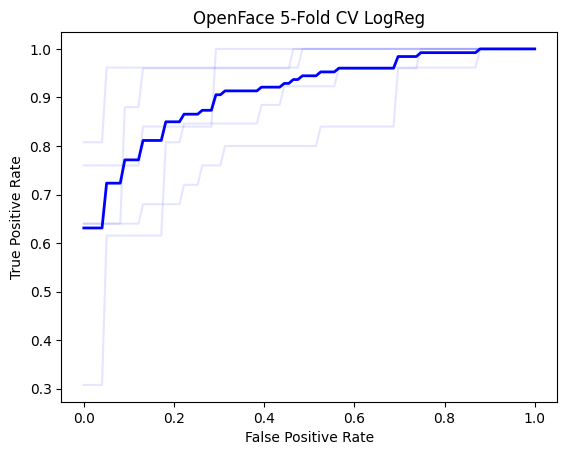

OPENFACE: 


,Fold,Accuracy,F1 Score,AUPRC,AUROC
0,1,0.877551,0.880000,0.956250,0.951667
1,2,0.857143,0.844444,0.953313,0.943333
2,3,0.938776,0.941176,0.982273,0.974916
3,4,0.816327,0.823529,0.885625,0.857860
4,5,0.750000,0.727273,0.885346,0.829565
5,Average,0.847959,0.843285,0.932561,0.911468


In [62]:
of_metrics_df, of_mean_fpr, of_mean_tpr = train_and_evaluate(openface_smile, Final_Smile_Labels, pipeline_name='OpenFace', results_path=RESULTS_PATH_BASE + 'Smile/')
print('OPENFACE: ')
display(of_metrics_df)

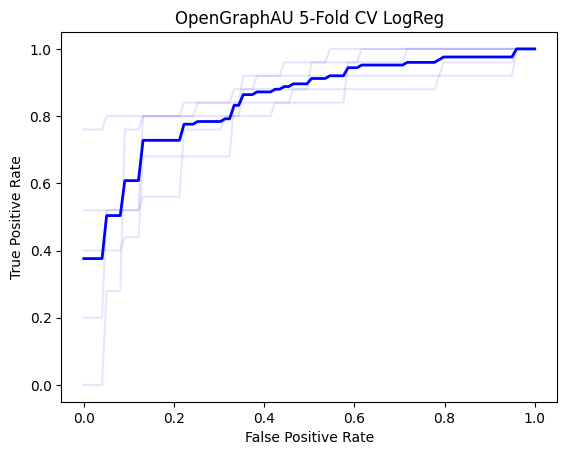

OPENGRAPHAU: 


,Fold,Accuracy,F1 Score,AUPRC,AUROC
0,1,0.795918,0.800000,0.793717,0.835000
1,2,0.714286,0.708333,0.844988,0.815000
2,3,0.714286,0.750000,0.931127,0.901667
3,4,0.791667,0.821429,0.870705,0.871304
4,5,0.750000,0.760000,0.860244,0.803478
5,Average,0.753231,0.767952,0.860156,0.845290


In [63]:
ogau_metrics_df, ogau_mean_fpr, ogau_mean_tpr = train_and_evaluate(opengraphau_smile, Final_Smile_Labels, pipeline_name='OpenGraphAU', results_path=RESULTS_PATH_BASE + 'Smile/')
print('OPENGRAPHAU: ')
display(ogau_metrics_df)

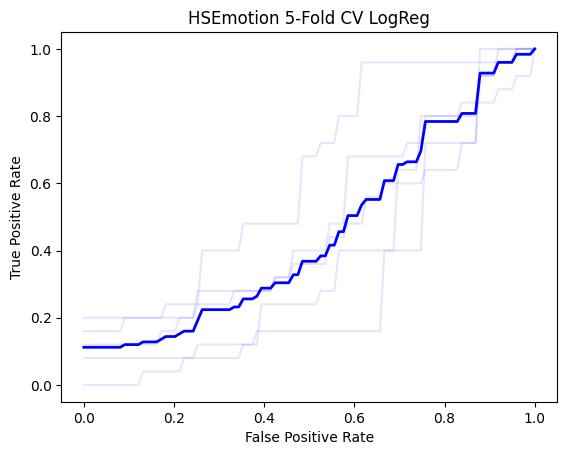

HSEMOTION: 


,Fold,Accuracy,F1 Score,AUPRC,AUROC
0,1,0.510204,0.675676,0.558044,0.471667
1,2,0.510204,0.675676,0.587877,0.456667
2,3,0.510204,0.675676,0.471487,0.330000
3,4,0.520833,0.684932,0.661675,0.622609
4,5,0.520833,0.684932,0.441324,0.372174
5,Average,0.514456,0.679378,0.544081,0.450623


In [64]:
hse_metrics_df, hse_mean_fpr, hse_mean_tpr = train_and_evaluate(hsemotion_smile, Final_Smile_Labels, pipeline_name='HSEmotion', results_path=RESULTS_PATH_BASE + 'Smile/')
print('HSEMOTION: ')
display(hse_metrics_df)

## Smile Checking shuffled labels

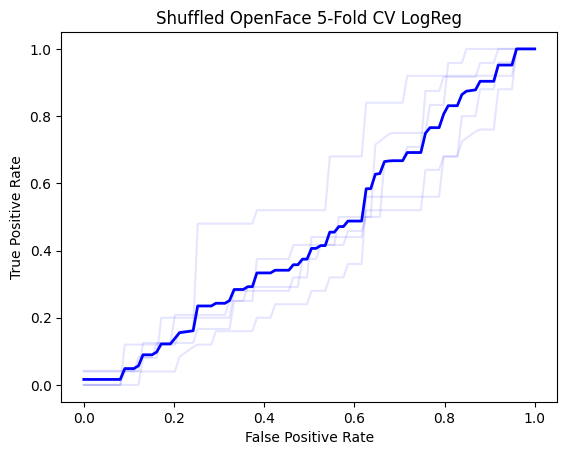

OPENFACE SHUFFLED: 


,Fold,Accuracy,F1 Score,AUPRC,AUROC
0,1,0.448980,0.509091,0.455900,0.361667
1,2,0.408163,0.491228,0.463262,0.411667
2,3,0.530612,0.530612,0.549469,0.566667
3,4,0.510204,0.571429,0.494486,0.475833
4,5,0.458333,0.434783,0.470288,0.458333
5,Average,0.471259,0.507428,0.486681,0.454833


In [65]:
s_of_metrics_df, s_of_mean_fpr, s_of_mean_tpr = train_and_evaluate(openface_smile, Shuffled_Smile_Labels, pipeline_name='Shuffled OpenFace', results_path=RESULTS_PATH_BASE + 'Smile/')
print('OPENFACE SHUFFLED: ')
display(s_of_metrics_df)

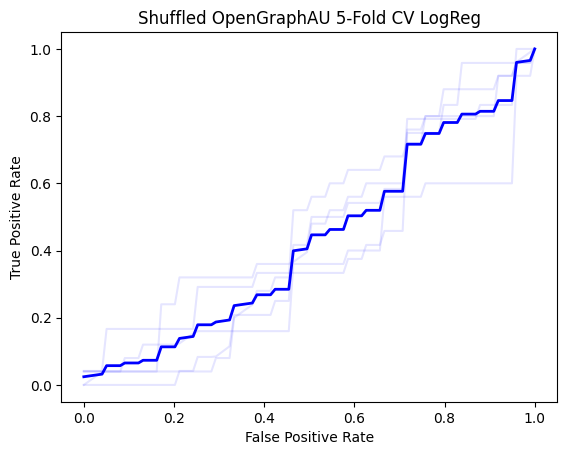

OPENGRAPHAU SHUFFLED: 


,Fold,Accuracy,F1 Score,AUPRC,AUROC
0,1,0.530612,0.530612,0.467262,0.442500
1,2,0.428571,0.517241,0.464626,0.344167
2,3,0.448980,0.526316,0.527830,0.484167
3,4,0.437500,0.509091,0.436776,0.408854
4,5,0.458333,0.535714,0.530388,0.451389
5,Average,0.460799,0.523795,0.485376,0.426215


In [66]:
s_ogau_metrics_df, s_ogau_mean_fpr, s_ogau_mean_tpr = train_and_evaluate(opengraphau_smile, Shuffled_Smile_Labels, pipeline_name='Shuffled OpenGraphAU', results_path=RESULTS_PATH_BASE + 'Smile/')
print('OPENGRAPHAU SHUFFLED: ')
display(s_ogau_metrics_df)

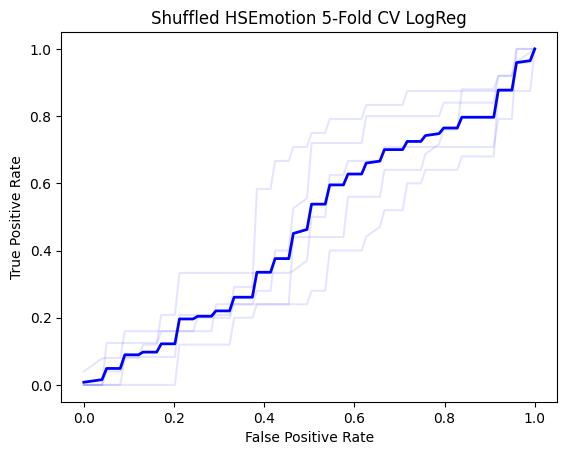

HSEMOTION SHUFFLED: 


,Fold,Accuracy,F1 Score,AUPRC,AUROC
0,1,0.489796,0.647887,0.498158,0.387500
1,2,0.510204,0.675676,0.446366,0.412500
2,3,0.510204,0.666667,0.513640,0.507500
3,4,0.520833,0.676056,0.524567,0.476562
4,5,0.479167,0.647887,0.519746,0.552083
5,Average,0.502041,0.662835,0.500495,0.467229


In [67]:
s_hse_metrics_df, s_hse_mean_fpr, s_hse_mean_tpr = train_and_evaluate(hsemotion_smile, Shuffled_Smile_Labels, pipeline_name='Shuffled HSEmotion', results_path=RESULTS_PATH_BASE + 'Smile/')
print('HSEMOTION SHUFFLED: ')
display(s_hse_metrics_df)

## Yawn Results: Train + Eval (5-Fold CV)

In [ ]:
of_metrics_df, of_mean_fpr, of_mean_tpr = train_and_evaluate(openface_yawn, Final_Yawn_Labels, pipeline_name='OpenFace', results_path=RESULTS_PATH_BASE + 'Yawn/')
print('OPENFACE: ')
display(of_metrics_df)

In [ ]:
ogau_metrics_df, ogau_mean_fpr, ogau_mean_tpr = train_and_evaluate(opengraphau_yawn, Final_Yawn_Labels, pipeline_name='OpenGraphAU', results_path=RESULTS_PATH_BASE + 'Yawn/')
print('OPENGRAPHAU: ')
display(ogau_metrics_df)

In [ ]:
hse_metrics_df, hse_mean_fpr, hse_mean_tpr = train_and_evaluate(hsemotion_yawn, Final_Yawn_Labels, pipeline_name='HSEmotion', results_path=RESULTS_PATH_BASE + 'Yawn/')
print('HSEMOTION: ')
display(hse_metrics_df)

## Yawn Checking shuffled labels

In [ ]:
s_of_metrics_df, s_of_mean_fpr, s_of_mean_tpr = train_and_evaluate(openface_yawn, Shuffled_Yawn_Labels, pipeline_name='Shuffled OpenFace', results_path=RESULTS_PATH_BASE + 'Yawn/')
print('OPENFACE SHUFFLED: ')
display(s_of_metrics_df)

In [ ]:
s_ogau_metrics_df, s_ogau_mean_fpr, s_ogau_mean_tpr = train_and_evaluate(opengraphau_yawn, Shuffled_Yawn_Labels, pipeline_name='Shuffled OpenGraphAU', results_path=RESULTS_PATH_BASE + 'Yawn/')
print('OPENGRAPHAU SHUFFLED: ')
display(s_ogau_metrics_df)

In [ ]:
s_hse_metrics_df, s_hse_mean_fpr, s_hse_mean_tpr = train_and_evaluate(hsemotion_yawn, Shuffled_Yawn_Labels, pipeline_name='Shuffled HSEmotion', results_path=RESULTS_PATH_BASE + 'Yawn/')
print('HSEMOTION SHUFFLED: ')
display(s_hse_metrics_df)

## Discomfort Results: Train + Eval (5-Fold CV)

In [ ]:
of_metrics_df, of_mean_fpr, of_mean_tpr = train_and_evaluate(openface_discomfort, Final_Discomfort_Labels, pipeline_name='OpenFace', results_path=RESULTS_PATH_BASE + 'Discomfort/')
print('OPENFACE: ')
display(of_metrics_df)

In [ ]:
ogau_metrics_df, ogau_mean_fpr, ogau_mean_tpr = train_and_evaluate(opengraphau_discomfort, Final_Discomfort_Labels, pipeline_name='OpenGraphAU', results_path=RESULTS_PATH_BASE + 'Discomfort/')
print('OPENGRAPHAU: ')
display(ogau_metrics_df)

In [ ]:
hse_metrics_df, hse_mean_fpr, hse_mean_tpr = train_and_evaluate(hsemotion_discomfort, Final_Discomfort_Labels, pipeline_name='HSEmotion', results_path=RESULTS_PATH_BASE + 'Discomfort/')
print('HSEMOTION: ')
display(hse_metrics_df)

## Discomfort Checking shuffled labels

In [ ]:
s_of_metrics_df, s_of_mean_fpr, s_of_mean_tpr = train_and_evaluate(openface_discomfort, Shuffled_Discomfort_Labels, pipeline_name='Shuffled OpenFace', results_path=RESULTS_PATH_BASE + 'Discomfort/')
print('OPENFACE SHUFFLED: ')
display(s_of_metrics_df)

In [ ]:
s_ogau_metrics_df, s_ogau_mean_fpr, s_ogau_mean_tpr = train_and_evaluate(opengraphau_discomfort, Shuffled_Discomfort_Labels, pipeline_name='Shuffled OpenGraphAU', results_path=RESULTS_PATH_BASE + 'Discomfort/')
print('OPENGRAPHAU SHUFFLED: ')
display(s_ogau_metrics_df)

In [ ]:
s_hse_metrics_df, s_hse_mean_fpr, s_hse_mean_tpr = train_and_evaluate(hsemotion_discomfort, Shuffled_Discomfort_Labels, pipeline_name='Shuffled HSEmotion', results_path=RESULTS_PATH_BASE + 'Discomfort/')
print('HSEMOTION SHUFFLED: ')
display(s_hse_metrics_df)

## Sad Results: Train + Eval (5-Fold CV)

In [ ]:
of_metrics_df, of_mean_fpr, of_mean_tpr = train_and_evaluate(openface_sad, Final_Sad_Labels, pipeline_name='OpenFace', results_path=RESULTS_PATH_BASE + 'Sad/')
print('OPENFACE: ')
display(of_metrics_df)

In [ ]:
ogau_metrics_df, ogau_mean_fpr, ogau_mean_tpr = train_and_evaluate(opengraphau_sad, Final_Sad_Labels, pipeline_name='OpenGraphAU', results_path=RESULTS_PATH_BASE + 'Sad/')
print('OPENGRAPHAU: ')
display(ogau_metrics_df)

In [ ]:
hse_metrics_df, hse_mean_fpr, hse_mean_tpr = train_and_evaluate(hsemotion_sad, Final_Sad_Labels, pipeline_name='HSEmotion', results_path=RESULTS_PATH_BASE + 'Sad/')
print('HSEMOTION: ')
display(hse_metrics_df)

## Sad Checking shuffled labels

In [ ]:
s_of_metrics_df, s_of_mean_fpr, s_of_mean_tpr = train_and_evaluate(openface_sad, Shuffled_Sad_Labels, pipeline_name='Shuffled OpenFace', results_path=RESULTS_PATH_BASE + 'Sad/')
print('OPENFACE SHUFFLED: ')
display(s_of_metrics_df)

In [ ]:
s_ogau_metrics_df, s_ogau_mean_fpr, s_ogau_mean_tpr = train_and_evaluate(opengraphau_sad, Shuffled_Sad_Labels, pipeline_name='Shuffled OpenGraphAU', results_path=RESULTS_PATH_BASE + 'Sad/')
print('OPENGRAPHAU SHUFFLED: ')
display(s_ogau_metrics_df)

In [ ]:
s_hse_metrics_df, s_hse_mean_fpr, s_hse_mean_tpr = train_and_evaluate(hsemotion_sad, Shuffled_Sad_Labels, pipeline_name='Shuffled HSEmotion', results_path=RESULTS_PATH_BASE + 'Sad/')
print('HSEMOTION SHUFFLED: ')
display(s_hse_metrics_df)

# OLD Simple Mapping (Smile, Yawn, etc.)

## Prep

In [ ]:
def only_successful_frames(df):
    # get frames where AU/emotion detection was successful!
    return df[df['success'] == 1]


def preprocess_df_radius_dict(df_radius_dict, columns_to_keep):
  # Takes only successful frames
  # Chooses specific columns from each df to keep

  new_radius_dict = {}
  for key1, one_time_df in df_radius_dict.items():
    success_df = only_successful_frames(one_time_df)
    new_radius_dict[key1] = success_df.loc[:, columns_to_keep]

  return new_radius_dict

In [ ]:
openface_radius_dict = openface_radius_dict['0.01666']
hsemotion_radius_dict = hsemotion_radius_dict['0.01666']
opengraphau_radius_dict = opengraphau_radius_dict['0.01666']


In [ ]:
from sklearn.metrics import roc_auc_score

def rule_mean_raw(outputs_dict, column):
  # Creates a pandas df with two columns
  # Datetime and EventDetected (probability)
  # Based on the rule: mean(column)

  rows = []
  for key_time, value_df in outputs_dict.items():
    if value_df.empty:
      rows.append(
          {'Datetime': key_time,
         'EventDetected': 0}
      )
    else:
      calculated_value = value_df.loc[:, column].mean(axis=0)

      rows.append(
          {'Datetime': key_time,
          'EventDetected': calculated_value}
      )

  return pd.DataFrame(rows)


def rule_mean_add(outputs_dict, columns_to_add, threshold, leq=False):
  # Creates a pandas df with two columns
  # Datetime and EventDetected
  # Based on the rule: mean(sum(columns_to_add)) >= threshold
  # If leq (less than or equal to): flip the rule. <= threshold

  rows = []
  for key_time, value_df in outputs_dict.items():
    if value_df.empty:
      rows.append(
          {'Datetime': key_time,
         'EventDetected': 0}
      )
    else:
      calculated_value = value_df.loc[:, columns_to_add].sum(axis=1).mean(axis=0)

      if leq:
        event_det = int(calculated_value <= threshold)
      else:
        event_det = int(calculated_value >= threshold)

      rows.append(
          {'Datetime': key_time,
          'EventDetected': event_det}
      )

  return pd.DataFrame(rows)

from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def calculate_metrics(preds, labels, plot_roc=False, title='Receiver Operating Characteristic Curve'):
    """
    Calculates AUROC, sensitivity and specificity given predictions and labels as Pandas DataFrames.
    Optionally, it can plot the ROC curve.

    Args:
        preds (pd.DataFrame): DataFrame containing predicted values (0 or 1).
        labels (pd.DataFrame): DataFrame containing true labels (0 or 1).
        plot_roc (bool): Whether to plot the ROC curve.

    Returns:
        auroc (float): AUROC value.
        sensitivity (float): Sensitivity value.
        specificity (float): Specificity value.
    """
    preds = np.array(preds['EventDetected']).astype(int)
    labels = np.array(labels['EventDetected']).astype(int)

    auroc = roc_auc_score(labels, preds)

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(labels, preds)

    # Unpack the confusion matrix values
    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    fpr, tpr, thresholds = roc_curve(labels, preds)

    best_threshold_index = np.argmax(tpr - fpr)

    best_threshold = thresholds[best_threshold_index]

    if plot_roc:

        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auroc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
        plt.legend(loc="lower right")
        plt.show()

    return auroc, sensitivity, specificity, best_threshold

def calculate_auroc(preds, labels):
    """
    Calculates AUROC (Area Under the Receiver Operating Characteristic Curve)
    given predictions and labels as Pandas DataFrames.

    Args:
        preds (pd.DataFrame): DataFrame containing predicted values (0 or 1).
        labels (pd.DataFrame): DataFrame containing true labels (0 or 1).

    Returns:
        float: AUROC value.
    """
    preds = np.array(preds['EventDetected']).astype(int)
    labels = np.array(labels['EventDetected']).astype(int)
    auroc = roc_auc_score(labels, preds)
    return auroc

In [ ]:
def plot_predicted_prob_histograms(labels_df, predicted_probs_df):
    # Filter predicted probabilities where labels_df has EventDetected = 0
    event_detected_0_probs = predicted_probs_df[labels_df['EventDetected'] == 0]['EventDetected']

    # Filter predicted probabilities where labels_df has EventDetected = 1
    event_detected_1_probs = predicted_probs_df[labels_df['EventDetected'] == 1]['EventDetected']

    # Plot histogram for EventDetected = 0
    plt.hist(event_detected_0_probs, bins=20, alpha=0.5, label='True EventDetected = 0')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predicted Probabilities for True EventDetected = 0')
    plt.legend()
    plt.show()

    # Plot histogram for EventDetected = 1
    plt.hist(event_detected_1_probs, bins=20, alpha=0.5, label='True EventDetected = 1')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predicted Probabilities for True EventDetected = 1')
    plt.legend()
    plt.show()

In [ ]:
def plot_sensitivity_specificity(thresholds, sensitivity_values, specificity_values):
    if len(thresholds) != len(sensitivity_values) or len(thresholds) != len(specificity_values):
        raise ValueError("The lengths of the input lists must be the same.")

    # Create a figure and axis object
    fig, ax = plt.subplots()

    # Plot sensitivity values as a blue line
    ax.plot(thresholds, sensitivity_values, label='Sensitivity', color='blue')

    # Plot specificity values as a green line
    ax.plot(thresholds, specificity_values, label='Specificity', color='green')

    # Set labels and title
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Value')
    ax.set_title('Sensitivity and Specificity')

    # Show the legend
    ax.legend()

    # Display the plot
    plt.show()


def and_or_operation(df1, df2, operation='AND'):
    if not isinstance(df1, pd.DataFrame) or not isinstance(df2, pd.DataFrame):
        raise ValueError("Both inputs must be pandas DataFrames.")

    if 'EventDetected' not in df1.columns or 'EventDetected' not in df2.columns:
        raise ValueError("Both DataFrames must have an 'EventDetected' column.")

    if df1.shape != df2.shape:
        raise ValueError("Both DataFrames must have the same shape.")

    result_df = df1.copy()

    if operation == 'AND':
        result_df['EventDetected'] = df1['EventDetected'] & df2['EventDetected']
    elif operation == 'OR':
        result_df['EventDetected'] = df1['EventDetected'] | df2['EventDetected']
    else:
        raise ValueError("Invalid operation. Please use 'AND' or 'OR'.")

    return result_df

In [ ]:
def shuffle_labels(df):
    """
    Takes in a DataFrame, makes a copy of it, and randomly shuffles the 'EventDetected' labels.

    Args:
        df (pd.DataFrame): DataFrame containing 'EventDetected' column.

    Returns:
        shuffled_df (pd.DataFrame): A copy of the original DataFrame with shuffled 'EventDetected' column.
    """
    shuffled_df = df.copy()
    shuffled_df['EventDetected'] = df['EventDetected'].sample(frac=1, random_state=42).reset_index(drop=True)
    return shuffled_df

In [ ]:
openface_smile = preprocess_df_radius_dict(openface_radius_dict, ['AU06_r', 'AU07_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU25_r', 'AU06_c', 'AU07_c', 'AU10_c', 'AU12_c', 'AU14_c', 'AU25_c'])
opengraphau_smile = preprocess_df_radius_dict(opengraphau_radius_dict, ['AU6', 'AU7', 'AU10', 'AU12', 'AU14', 'AU25'])
hsemotion_smile = preprocess_df_radius_dict(hsemotion_radius_dict, ['Happiness'])

In [ ]:
import random

random.choice(list(openface_smile.values()))

In [ ]:
of_columns = ['AU01_r', 'AU02_r', 'AU04_r', 'AU05_r',
       'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r',
       'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r', 'AU01_c',
       'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c', 'AU07_c', 'AU09_c', 'AU10_c',
       'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c', 'AU20_c', 'AU23_c', 'AU25_c',
       'AU26_c', 'AU45_c']

og_columns = ['AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU7', 'AU9',
       'AU10', 'AU11', 'AU12', 'AU13', 'AU14', 'AU15', 'AU16', 'AU17', 'AU18',
       'AU19', 'AU20', 'AU22', 'AU23', 'AU24', 'AU25', 'AU26', 'AU27', 'AU32',
       'AU38', 'AU39']

hse_columns = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

In [ ]:
def create_AU_avg_df(aunames, au_without_event, au_with_event):
    if len(aunames) != len(au_without_event) or len(aunames) != len(au_with_event):
        raise ValueError("All lists must have the same length.")

    data = {
        'Feature Name': aunames,
        'Value without Event': au_without_event,
        'Value with Event': au_with_event
    }

    df = pd.DataFrame(data)
    return df


def average_values_for_event(df, inner_df_dict, columns_of_interest):
    # df -- has event detected for each timestamp
    # inner_df_dict -- dictionary mapping each timestamp to a df with pipeline data
    # columns_of_interest -- list with the columns we care about

    # Filter the main DataFrame for EventDetected = 0 and 1
    event_detected_0 = df[df['EventDetected'] == 0]['Datetime'].values
    event_detected_1 = df[df['EventDetected'] == 1]['Datetime'].values

    # Initialize lists to store average values for EventDetected = 0 and 1
    avg_values_event_0 = [0] * len(columns_of_interest)
    avg_values_event_1 = [0] * len(columns_of_interest)

    # Process inner DataFrames for each timestamp
    for timestamp, inner_df in inner_df_dict.items():
        if timestamp in df['Datetime'].values:  # Check if the timestamp exists in the main DataFrame
            for enum, column in enumerate(columns_of_interest):
                num_now = inner_df[column].mean()
                if not(np.isnan(num_now)):
                  if timestamp in event_detected_0:
                    avg_values_event_0[enum] += num_now
                  else:
                    avg_values_event_1[enum] += num_now



    # Calculate the final average values for EventDetected = 0 and 1 by dividing with the total count
    total_count_event_0 = len(event_detected_0)
    total_count_event_1 = len(event_detected_1)

    avg_values_event_0 = [i/total_count_event_0 for i in avg_values_event_0]
    avg_values_event_1 = [i/total_count_event_1 for i in avg_values_event_1]

    df_now = create_AU_avg_df(columns_of_interest, avg_values_event_0, avg_values_event_1)

    return df_now


In [ ]:
average_values_for_event(Final_Smile_Labels, opengraphau_smile, ['AU6', 'AU7', 'AU10', 'AU12', 'AU14', 'AU25'])

In [ ]:
average_values_for_event(Final_Smile_Labels, openface_smile, ['AU06_r', 'AU07_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU25_r', 'AU06_c', 'AU07_c', 'AU10_c', 'AU12_c', 'AU14_c', 'AU25_c'])

In [ ]:
Shuffled_Smile_Labels = shuffle_labels(Final_Smile_Labels)

In [ ]:
openface_yawn = preprocess_df_radius_dict(openface_radius_dict, ['AU26_r', 'AU26_c'])
opengraphau_yawn = preprocess_df_radius_dict(opengraphau_radius_dict, ['AU26', 'AU27'])
hsemotion_yawn = hsemotion_radius_dict

In [ ]:
Shuffled_Yawn_Labels = shuffle_labels(Final_Yawn_Labels)

In [ ]:
average_values_for_event(Final_Yawn_Labels, opengraphau_radius_dict, og_columns)

In [ ]:
average_values_for_event(Final_Yawn_Labels, openface_radius_dict, [i for i in of_columns if i.endswith('_c')])

In [ ]:
average_values_for_event(Final_Yawn_Labels, hsemotion_radius_dict, hse_columns)

## OpenFace - Smile

In [ ]:

for one_au_now in ['AU06_c', 'AU07_c', 'AU10_c', 'AU12_c', 'AU14_c', 'AU25_c']:
  if '10' in one_au_now:
    # We want to AVOID AU10 for smile
    leq = True
  else:
    leq = False
  of_smile_raw = rule_mean_raw(openface_smile, one_au_now)
  auroc_now, _, _, best_threshold = calculate_metrics(of_smile_raw, Final_Smile_Labels, plot_roc=True, title=f'OF Smile: {one_au_now} Only')
  print(f'OF Using {one_au_now} Only, AUROC = {auroc_now:.3f}')
  print(f'Best threshold is {best_threshold:.3f}')

  for threshold in [0, 0.2, 0.4, 0.6, 0.8, 1]:
    of_smile = rule_mean_add(openface_smile, [one_au_now], threshold, leq=leq)
    _, sens_of_smile, spec_of_smile, _ = calculate_metrics(of_smile, Final_Smile_Labels)
    print(f'OF Using {one_au_now} Only, Threshold={threshold:.3f}: Sens={sens_of_smile:.3f}, Spec={spec_of_smile:.3f}')



In [ ]:
# Histogram

of_smile_raw = rule_mean_raw(openface_smile, 'AU06_c')
plot_predicted_prob_histograms(Final_Smile_Labels, of_smile_raw)

In [ ]:


for one_au_now in ['AU06_r', 'AU07_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU25_r']:
  if '10' in one_au_now:
    # We want to AVOID AU10 for smile
    leq = True
  else:
    leq = False
  of_smile_raw = rule_mean_raw(openface_smile, one_au_now)
  of_smile_raw['EventDetected'] = of_smile_raw['EventDetected'] / 5 # Scale down to 0 to 1
  auroc_now, _, _, best_threshold = calculate_metrics(of_smile_raw, Final_Smile_Labels, plot_roc=True, title=f'OF Smile: {one_au_now} Only')
  print(f'OF Using {one_au_now} Only, AUROC = {auroc_now:.3f}')
  print(f'Best threshold is {best_threshold:.3f}')

  for threshold in np.linspace(0, 1, 6):
    of_smile = rule_mean_add(openface_smile, [one_au_now], threshold, leq=leq)
    _, sens_of_smile, spec_of_smile, _ = calculate_metrics(of_smile, Final_Smile_Labels)
    print(f'OF Using {one_au_now} Only, Threshold={threshold:.3f}: Sens={sens_of_smile:.3f}, Spec={spec_of_smile:.3f}')




In [ ]:

for two_aus_now in [['AU06_c', 'AU12_c'],
                    ['AU06_c', 'AU14_c'],
                    ['AU12_c', 'AU14_c']]:

  raw_dfs = []
  for one_au_now in two_aus_now:
    of_smile_raw = rule_mean_raw(openface_smile, one_au_now)
    raw_dfs.append(of_smile_raw)

  for threshold1 in np.linspace(0, 1, 6):
    for threshold2 in np.linspace(0, 1, 6):
      df_thresholded_1 = rule_mean_add(openface_smile, [two_aus_now[0]], threshold1)
      df_thresholded_2 = rule_mean_add(openface_smile, [two_aus_now[1]], threshold2)
      of_smile_and = and_or_operation(df_thresholded_1, df_thresholded_2, operation='AND')
      _, sens_of_smile, spec_of_smile, _ = calculate_metrics(of_smile_and, Final_Smile_Labels)
      print(f'OF Using {two_aus_now[0]} >= {threshold1:.3f} AND {two_aus_now[1]} >= {threshold2:.3f}: Sens={sens_of_smile:.3f}, Spec={spec_of_smile:.3f}')

      of_smile_or = and_or_operation(df_thresholded_1, df_thresholded_2, operation='OR')
      _, sens_of_smile, spec_of_smile, _ = calculate_metrics(of_smile_or, Final_Smile_Labels)
      print(f'OF Using {two_aus_now[0]} >= {threshold1:.3f} OR {two_aus_now[1]} >= {threshold2:.3f}: Sens={sens_of_smile:.3f}, Spec={spec_of_smile:.3f}')


## OpenGraphAU - Smile

In [ ]:
for one_au_now in ['AU6', 'AU7', 'AU10', 'AU12', 'AU14', 'AU25']:
  if '10' in one_au_now:
    # We want to AVOID AU10 for smile
    leq = True
  else:
    leq = False
  og_smile_raw = rule_mean_raw(opengraphau_smile, one_au_now)
  auroc_now, _, _, best_threshold = calculate_metrics(og_smile_raw, Final_Smile_Labels, plot_roc=True, title=f'OGAU Smile: {one_au_now} Only')
  print(f'OG Using {one_au_now} Only, AUROC = {auroc_now:.3f}')
  print(f'Best threshold is {best_threshold:.3f}')

  for threshold in np.linspace(0, 1, 6):
    og_smile = rule_mean_add(opengraphau_smile, [one_au_now], threshold, leq=leq)
    _, sens_og_smile, spec_og_smile, _ = calculate_metrics(og_smile, Final_Smile_Labels)
    print(f'OG Using {one_au_now} Only, Threshold={threshold:.3f}: Sens={sens_og_smile:.3f}, Spec={spec_og_smile:.3f}')




In [ ]:
for one_au_now in ['AU6', 'AU7', 'AU10', 'AU12', 'AU14', 'AU25']:
  if '10' in one_au_now:
    # We want to AVOID AU10 for smile
    leq = True
  else:
    leq = False
  og_smile_raw = rule_mean_raw(opengraphau_smile, one_au_now)
  auroc_now, _, _, best_threshold = calculate_metrics(og_smile_raw, Final_Smile_Labels, plot_roc=True, title=f'OGAU Smile: {one_au_now} Only')
  print(f'OG Using {one_au_now} Only, AUROC = {auroc_now}')
  print(f'Best threshold is {best_threshold:.3f}')

  for threshold in np.linspace(0.4, 0.5, 40):
    og_smile = rule_mean_add(opengraphau_smile, [one_au_now], threshold, leq=leq)
    _, sens_og_smile, spec_og_smile, _ = calculate_metrics(og_smile, Final_Smile_Labels)
    print(f'OG Using {one_au_now} Only, Threshold={threshold:.3f}: Sens={sens_og_smile:.3f}, Spec={spec_og_smile:.3f}')




In [ ]:

for two_aus_now in [['AU6', 'AU7'],
                    ['AU6', 'AU25'],
                    ['AU7', 'AU25']]:

  scaling_dict = {
      'AU6': np.linspace(0.42, 0.48, 10),
      'AU7': np.linspace(0.30, 0.36, 10),
      'AU25': np.linspace(0.74, 0.80, 10)
  }
  raw_dfs = []
  for one_au_now in two_aus_now:
    og_smile_raw = rule_mean_raw(opengraphau_smile, one_au_now)
    raw_dfs.append(og_smile_raw)

  tuple_list = []
  and_sums = []
  or_sums = []

  for threshold1 in scaling_dict[two_aus_now[0]]:
    for threshold2 in scaling_dict[two_aus_now[1]]:
      tuple_now = (threshold1, threshold2)
      tuple_list.append(tuple_now)
      df_thresholded_1 = rule_mean_add(opengraphau_smile, [two_aus_now[0]], threshold1)
      df_thresholded_2 = rule_mean_add(opengraphau_smile, [two_aus_now[1]], threshold2)
      og_smile_and = and_or_operation(df_thresholded_1, df_thresholded_2, operation='AND')
      _, sens_og_smile, spec_og_smile, _ = calculate_metrics(og_smile_and, Final_Smile_Labels)
      and_sums.append(sens_og_smile + spec_og_smile)
      print(f'OG Using {two_aus_now[0]} >= {threshold1:.3f} AND {two_aus_now[1]} >= {threshold2:.3f}: Sens={sens_og_smile:.3f}, Spec={spec_og_smile:.3f}')

      og_smile_or = and_or_operation(df_thresholded_1, df_thresholded_2, operation='OR')
      _, sens_og_smile, spec_og_smile, _ = calculate_metrics(og_smile_or, Final_Smile_Labels)
      or_sums.append(sens_og_smile + spec_og_smile)
      print(f'OG Using {two_aus_now[0]} >= {threshold1:.3f} OR {two_aus_now[1]} >= {threshold2:.3f}: Sens={sens_og_smile:.3f}, Spec={spec_og_smile:.3f}')

  print('-'*40)
  print('-'*40)
  best_tuple_and = tuple_list[and_sums.index(max(and_sums))]
  print(f'OG Best Thresholds for {two_aus_now[0]} AND {two_aus_now[1]}: {best_tuple_and}')
  best_tuple_or = tuple_list[or_sums.index(max(or_sums))]
  print(f'OG Best Thresholds for {two_aus_now[0]} OR {two_aus_now[1]}: {best_tuple_or}')
  print('-'*40)
  print('-'*40)

## HSE - Smile

In [ ]:

hse_smile_raw = rule_mean_raw(hsemotion_smile, 'Happiness')
auroc_now, _, _, best_threshold = calculate_metrics(hse_smile_raw, Final_Smile_Labels, plot_roc=True, title=f'HSE Smile: Happiness Only')
print(f'HSE Using Happiness Only, AUROC = {auroc_now}')
print(f'Best threshold is {best_threshold}')

threshold_list = []
sens_list = []
spec_list = []

for threshold in np.linspace(0, 0.2, 40):
    threshold_list.append(threshold)
    hse_smile = rule_mean_add(hsemotion_smile, ['Happiness'], threshold)
    _, sens_hse_smile, spec_hse_smile, _ = calculate_metrics(hse_smile, Final_Smile_Labels)
    sens_list.append(sens_hse_smile)
    spec_list.append(spec_hse_smile)
    print(f'HSE Using Happiness Only, Threshold={threshold}: Sens={sens_hse_smile}, Spec={spec_hse_smile}')

for threshold in np.linspace(0.3, 1, 8):
    threshold_list.append(threshold)
    hse_smile = rule_mean_add(hsemotion_smile, ['Happiness'], threshold)
    _, sens_hse_smile, spec_hse_smile, _ = calculate_metrics(hse_smile, Final_Smile_Labels)
    sens_list.append(sens_hse_smile)
    spec_list.append(spec_hse_smile)
    print(f'HSE Using Happiness Only, Threshold={threshold}: Sens={sens_hse_smile}, Spec={spec_hse_smile}')

In [ ]:
plot_sensitivity_specificity(threshold_list, sens_list, spec_list)

## OpenFace - Yawn

In [ ]:
for threshold in np.arange(0, 1, 0.1):
    of_yawn = rule_mean_add(openface_yawn, ['AU26_c'], threshold)
    auroc_of_yawn, sens_of_yawn, spec_of_yawn = calculate_metrics(of_yawn, Final_Yawn_Labels)
    print(f'OF Yawn Using AU26_c Only, Threshold={threshold}: AUROC = {auroc_of_yawn}, Sens={sens_of_yawn}, Spec={spec_of_yawn}')

In [ ]:
best_threshold = 0.1
title_now = f"ROC: AU26_c only, {best_threshold}"
of_yawn = rule_mean_add(openface_yawn, ['AU26_c'], best_threshold)
auroc_of_yawn, sens_of_yawn, spec_of_yawn = calculate_metrics(of_yawn, Final_Yawn_Labels, plot_roc=True, title=title_now)



In [ ]:
best_threshold = 0.1
title_now = f"(Shuffled) ROC: AU26_c only, {best_threshold}"
of_yawn = rule_mean_add(openface_yawn, ['AU26_c'], best_threshold)
auroc_of_yawn, sens_of_yawn, spec_of_yawn = calculate_metrics(of_yawn, Shuffled_Yawn_Labels, plot_roc=True, title=title_now)



In [ ]:
for threshold in np.arange(0, 5, 0.5):
    of_yawn = rule_mean_add(openface_yawn, ['AU26_r'], threshold)
    auroc_of_yawn, sens_of_yawn, spec_of_yawn = calculate_metrics(of_yawn, Final_Yawn_Labels)
    print(f'OF Yawn Using AU26_r Only, Threshold={threshold}: AUROC = {auroc_of_yawn}, Sens={sens_of_yawn}, Spec={spec_of_yawn}')

## Old Code & Notes



In [ ]:
# OpenFace - c columns


# Add a few more thresholds - 0.5 and 1.5

# We want very high specificity. Based on best AUROC model,
# find best threshold for specificity and then figure out sensitivity

# Detected in all frames
of_smile_6c = rule_mean_add(openface_smile, ['AU06_c'], 1)
auroc_of_smile_6c = calculate_auroc(of_smile_6c, Final_Smile_Labels)
print(f'OF Using AU06_c Only: AUROC = {auroc_of_smile_6c}')

# Detected in all frames
of_smile_12c = rule_mean_add(openface_smile, ['AU12_c'], 1)
auroc_of_smile_12c = calculate_auroc(of_smile_12c, Final_Smile_Labels)
print(f'OF Using AU12_c Only: AUROC = {auroc_of_smile_12c}')

# 50% are 1s over the 5 frames
of_smile_6c_or_12c = rule_mean_add(openface_smile, ['AU06_c', 'AU12_c'], 1)
auroc_of_smile_6c_or_12c = calculate_auroc(of_smile_6c_or_12c, Final_Smile_Labels)
print(f'OF Using AU12_c or AU06_c: AUROC = {auroc_of_smile_6c_or_12c}')

# Both 1s for all 5 frames
of_smile_6c_and_12c = rule_mean_add(openface_smile, ['AU06_c', 'AU12_c'], 2)
auroc_of_smile_6c_and_12c = calculate_auroc(of_smile_6c_and_12c, Final_Smile_Labels)
print(f'OF Using AU12_c and AU06_c: AUROC = {auroc_of_smile_6c_and_12c}')

In [ ]:
# OpenFace - r columns
auroc_of_smile_6r_all = []
for i in np.linspace(0, 5, 11):
  of_smile_6r = rule_mean_add(openface_smile, ['AU06_r'], i)
  auroc_of_smile_6r = calculate_auroc(of_smile_6r, Final_Smile_Labels)
  auroc_of_smile_6r_all.append(auroc_of_smile_6r)
  print(f'OF Using AU06_r Only, Threshold of {i}: AUROC = {auroc_of_smile_6r}')


In [ ]:
# OpenFace - r columns
auroc_of_smile_12r_all = []
for i in np.linspace(0, 5, 11):
  of_smile_12r = rule_mean_add(openface_smile, ['AU12_r'], i)
  auroc_of_smile_12r = calculate_auroc(of_smile_12r, Final_Smile_Labels)
  auroc_of_smile_12r_all.append(auroc_of_smile_12r)
  print(f'OF Using AU12_r Only, Threshold of {i}: AUROC = {auroc_of_smile_12r}')


In [ ]:
# SMILE AU ANALYSIS:

# We want the absence of AU10 for smile
# Presence of AUs 6 and 12 is good
# When looking at combos, just use AND (e.g. AU 6 > 0.8 AND AU 12 > 0.2)
# AU7 is good
# AU14 and AU25 are also good


# Do all separately
# 6 and 12 combined
# Model with all



# HSE: 0 : 0.1 : 1 for Happiness


# Do a random permute of labels to make sure AUROC goes down


# Distinguish between different types of smiles (intensity)



In [ ]:
Final_Smile_Labels

In [ ]:
# YAWN

# 26 and 27

# HSE: Plot mean value of each of emotions for yawn vs. control - how does it classify yawn?



In [ ]:
Final_Yawn_Labels

In [ ]:
# DISCOMFORT



In [ ]:
# SAD



# Sanity Checks

In [ ]:
import pandas as pd

def calculate_success_percentage(df):
    total_rows = len(df)
    success_rows = len(df[df['success'] == 1])
    success_percentage = (success_rows / total_rows) * 100
    return success_percentage

def plot_histogram_sp(df_dict, savepath, title_add):
    # gives us mapping from timestamp --> success percentage
    sp_dict = apply_function_to_dict(df_dict, calculate_success_percentage)
    timestamps = list(sp_dict.keys())
    percentages = list(sp_dict.values())

    fig, ax = plt.subplots()

    # Plot the histogram

    ax.hist(percentages, bins=10)

    # Set labels and title
    ax.set_xlabel('Percentage')
    ax.set_ylabel('Frequency')
    ax.set_title('Histogram of Success Percentages' + title_add)

    # Save the plot
    plt.savefig(savepath, bbox_inches='tight')
    plt.close(fig)

def plot_line_sp(df_dict, savepath, title_add):
    # gives us mapping from timestamp --> success percentage
    sp_dict = apply_function_to_dict(df_dict, calculate_success_percentage)

    timestamps = list(sp_dict.keys())
    percentages = list(sp_dict.values())

    fig, ax = plt.subplots()

    # Plot the line graph
    ax.plot(timestamps, percentages)

    # Set labels and title
    ax.set_xlabel('Time')
    ax.set_ylabel('Success Percentage')
    ax.set_title('Success Percentage Over Time' + title_add)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Save the plot
    plt.savefig(savepath, bbox_inches='tight')
    plt.close(fig)

In [ ]:
for i in TIME_RADIUS_LIST:
  title_now = f', Time Window = {i / 60} Hours'

  plot_histogram_sp(openface_radius_dict[f'{i}'], RESULTS_PATH_BASE + f'report_window_sp_histogram_{i}.png', title_now)
  plot_line_sp(openface_radius_dict[f'{i}'], RESULTS_PATH_BASE + f'report_window_sp_line_{i}.png', title_now)


In [ ]:
def check_success_percentage(dfs_openface, dump_path, verbose=False):
  unsuccessful_data_dict = {}
  for key, df in dfs_openface.items():
    unsuccess_percentage_saved = (df['success'] == 0).mean() * 100
    real_unsuccess_percentage = 100 - ((df.shape[0] / 18004) * 100) # there are 18004 frames in the best video
    if unsuccess_percentage_saved > 5:
      if verbose:
        print('UNSUCCESSFUL FILTERING: ', key)
    if real_unsuccess_percentage > 80:
      unsuccessful_data_dict[key] = real_unsuccess_percentage
      if verbose:
        print('UNSUCCESSFUL DATA: ', key, f'UNSUCCESSFUL = {real_unsuccess_percentage}%')

  df = pd.DataFrame(unsuccessful_data_dict.items(), columns=['Filename', 'Percent Unsuccessful'])
  df.to_excel(dump_path, index=False)

  return unsuccessful_data_dict

In [ ]:
of_unsuccess = check_success_percentage(dfs_openface, dump_path=f'{QC_PATH}/of_unsuccess.xlsx')

In [ ]:
list(of_unsuccess.keys())

In [ ]:
og_unsuccess = check_success_percentage(dfs_opengraphau, dump_path=f'{QC_PATH}/og_unsuccess.xlsx')

In [ ]:
hse_unsuccess = check_success_percentage(dfs_hsemotion, dump_path=f'{QC_PATH}/hse_unsuccess.xlsx')

In [ ]:
good_for_all = [x for x in list(dfs_openface.keys()) if x not in list(of_unsuccess.keys()) and x not in list(og_unsuccess.keys()) and x not in list(hse_unsuccess.keys())]
good_for_all

In [ ]:
def sanity_detect_emotions_og(df, method, emo_AUs, threshold=0.3, additional_filter=None):
    # INPUT:
    # df -- dataframe with AUs for each frame
    # method -- must be 'OpenGraphAU'
    # emo_AUs -- the hash table
    # additional_filter -- are we just doing lower half? upper half? This is None or a list of ints (which AUs to keep)
    # threshold -- what is the threshold for yes/no we're using for OpenGraphAU?

    # OUTPUT:
    # 1 datafrme with emotion values for each frame
    # emo_binary (see OpenDBM docs for details)


    if df.empty:
      return df
    # We start by mapping AUs to emotions for each of our two methods
    # Using this mapping: https://aicure.github.io/open_dbm/docs/emotional-expressivity


    if method == 'OpenGraphAU':
        columns = ['AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU7', 'AU9',
                   'AU10', 'AU11', 'AU12', 'AU13', 'AU14', 'AU15', 'AU16', 'AU17',
                   'AU18', 'AU19', 'AU20', 'AU22', 'AU23', 'AU24', 'AU25', 'AU26', 'AU27', 'AU32',
                   'AU38', 'AU39']

        # add the classification columns!
        columns = [item for sublist in [[col+'_r', col] for col in columns] for item in sublist]

        # hash tables for presence and intensity
        emo_AUs_presence = {}
        for key in emo_AUs.keys():
            new_values_c = []
            for value in emo_AUs[key]:
                if isinstance(value, int):
                    AU_key_c = f"AU{value}"

                    if AU_key_c in columns:
                        if additional_filter is not None:
                          if value in additional_filter:
                            new_values_c.append(AU_key_c)
                        else:
                          new_values_c.append(AU_key_c)
            if new_values_c:
                emo_AUs_presence[key] = new_values_c

    else:
        # if the method specified is not OpenFace or OpenGraphAU, raise an error (pipeline doesn't support others yet)
        raise ValueError("Invalid method parameter. Method must be 'OpenGraphAU'.")

    # Create an empty dictionary to store the emotion scores
    emotion_scores_binary = {} # 1 or 0: are all AUs present?

    # Compute emotion scores for each emotion
    for emotion in emo_AUs_presence.keys():
        # Get the relevant columns for presence
        presence_cols = emo_AUs_presence[emotion]

        # Compute the emotion score for each row in the dataframe
        emotion_scores_binary[emotion] = df[presence_cols].gt(threshold).all(axis=1)
        emotion_scores_binary[emotion] = emotion_scores_binary[emotion].fillna(0)

    # Create a new dataframe with the emotion scores
    emotion_df_binary = pd.DataFrame(emotion_scores_binary)
    emotion_df_binary = emotion_df_binary.replace({False: 0, True: 1})

    # Let's add timestamp and success on
    columns_of_interest = ['timestamp', 'success']
    df_temp = df[columns_of_interest]

    # Concatenate the columns from df2 with df1
    emotion_df_binary = pd.concat([df_temp, emotion_df_binary], axis=1)

    return emotion_df_binary

In [ ]:
def convert_seconds_to_mmss(seconds):
  minutes = int(seconds // 60)
  seconds = int(seconds % 60)
  return f'{minutes:02d}:{seconds:02d}'


def sanity_check_find(one_filename, emotion_to_find, threshold_for_search, method):
  # filename of video
  # emotion (e.g. Happiness)
  # threshold_for_search - e.g. if it's 0.6 and OpenFace, only timestamps where OpenFace says Happiness>0.6
  # method - OpenFace, OpenGraphAU, or HSEmotion

  if method == 'OpenFace':
    one_df = detect_emotions(dfs_openface[one_filename], 'OpenFace', emo_AUs, additional_filter=None)[1]
    filtered_df = one_df[(one_df[emotion_to_find] > threshold_for_search) & (one_df[emotion_to_find] == one_df[['Happiness', 'Sadness', 'Surprise', 'Fear', 'Anger', 'Disgust', 'Contempt']].max(axis=1))]
  elif method == 'OpenGraphAU':
    one_df = sanity_detect_emotions_og(dfs_opengraphau[one_filename], 'OpenGraphAU', emo_AUs)
    filtered_df = one_df[(one_df[emotion_to_find] > threshold_for_search) & (one_df[emotion_to_find] == one_df[['Happiness', 'Sadness', 'Surprise', 'Fear', 'Anger', 'Disgust', 'Contempt']].max(axis=1))]
  elif method == 'HSEmotion':
    one_df = dfs_hsemotion[one_filename].copy()
    filtered_df = one_df[(one_df[emotion_to_find] > threshold_for_search) & (one_df[emotion_to_find] == one_df[['Happiness', 'Sadness', 'Surprise', 'Fear', 'Anger', 'Disgust', 'Neutral']].max(axis=1))]
  else:
    print("ERROR! CHECK THE METHOD PARAMETER!!")

  # Apply the function to the 'timestamp' column
  filtered_df['timestamp'] = filtered_df['timestamp'].apply(lambda x: convert_seconds_to_mmss(x))

  return filtered_df

In [ ]:
sanity_check_find('3332W300', 'Happiness', 0.4, method='OpenGraphAU')

# Feature Extraction - OpenDBM

Having lots of trouble installing OpenDBM package on Colab. The main issue is the dependency deepspeech can't be installed. Tried installing deepspeech from github, but it seems to require another library that I can't install on colab

When I install without dependencies, then manually install only those that are necessary, there are some conflicting version requirements.

Tried forking repo and manually changing requirements to remove deepspeech. Installing from github seems to fail.

Tried cloning repo here, adding its path via sys, and importing just feature extraction, but there seem to be no callable libraries there.

Tried modifying setup and requirements in here after cloning repo, and it still didn't work. Pip says it's an issue with the package, but doens't give a useful error trace.

Tried conda as well and it failed



In [ ]:
!pip install opendbm --no-deps

In [ ]:
!pip install stopit

In [ ]:
!pip install git+https://github.com/AiCure/open_dbm.git@master#egg=opendbm.dbm_lib

In [ ]:
!pip install git+https://github.com/JayRGopal/open_dbm.git@master

In [ ]:
!pip install condacolab

In [ ]:
!conda create -n myenv
!conda activate myenv
!conda install -c conda-forge cmake ffmpeg sox

In [ ]:
!sudo apt-get install nano
!nano ~/.bashrc

In [ ]:
!nano ~/.bashrc

In [ ]:
!pip install -v opendbm==0.0.1b6

In [ ]:
!pip3 install opendbm==0.0.1b6 --no-deps=deepface

In [ ]:
!git clone https://github.com/AiCure/open_dbm

In [ ]:
%cd open_dbm

In [ ]:
!pip install -r requirements.txt

In [ ]:
%cd /content/

In [ ]:
import sys
sys.path.append('/content/open_dbm/opendbm/')
from dbm_lib import dbm_features

In [ ]:
import inspect

module = __import__('dbm_lib.dbm_features.derived_features.derive')

callable_methods = [
  method for method in dir(module)
  #if inspect.ismethod(getattr(module, method))
]

print(callable_methods)

In [ ]:

# Create a dbm_features object.
dbm_features = dbm_features()

# Set the features that you want to extract.
dbm_features.set_features(
    [
        "action_units",
        "emotional_expressivity",
        "overall_expressivity",
    ]
)

# Pass the pandas df to the dbm_features object.
dbm_features.fit(openface_radius[get_moodTracking_datetime(0)])

# Call the extract_features() method.
extracted_features = dbm_features.extract_features()

# Get the extracted features.
print(extracted_features)

# Feature Extraction 1.0

## AU --> Emotion & Lower/Upper

In [ ]:
# Define emotion to AU mapping

# OpenDBM:
emo_AUs = {'Happiness': [6, 12],
           'Sadness': [1, 4, 15],
           'Surprise': [1, 2, 5, 26],
           'Fear': [1, 2, 4, 5, 7, 20, 26],
           'Anger': [4, 5, 7, 23],
           'Disgust': [9, 15, 16],
           'Contempt': [12, 14]}

In [ ]:
# Define AU to lower/upper

# OpenDBM:
AU_lower = [12, 15, 26, 20, 23, 14]
AU_upper = [6, 1, 4, 2, 5, 7, 9]

## Emotion Processing - HSEmotion

In [ ]:
def only_successful_frames(df):
    # get frames where AU/emotion detection was successful!
    return df[df['success'] == 1]

def filter_max_emotion(df, threshold):

    if df.empty:
      return df

    # create a copy of the input df
    df_copy = df.copy()

    # success
    df_copy = only_successful_frames(df_copy)

    # find the maximum emotion value for each frame
    cols_to_check = [col for col in df_copy.columns if col not in ['success', 'timestamp']]
    max_emotion = df_copy[cols_to_check].max(axis=1)

    # set all non-max emotion values to 0 for each frame
    for col in cols_to_check:
      df_copy.loc[df_copy[col] < max_emotion, col] = 0

    # filter for frames where max emotion is above threshold
    df_filtered = df_copy[max_emotion > threshold]

    return df_filtered

def add_event_column(df, time_thresh, min_event_length):
    """
    Adds an 'event' column to a dataframe, assigning an event ID to each frame based on the specified time threshold and
    event length.

    Args:
        df (pandas DataFrame): A dataframe with video frames as rows and emotion features as columns. The dataframe
            should have a 'timestamp' column containing timestamps for each frame.
        time_thresh (int or float): The time threshold (in seconds) to use when defining events. Any two consecutive
            frames with a time difference greater than this threshold will belong to different events.
        min_event_length (int): The minimum length of an event. Events shorter than this length will be filtered out.

    Returns:
        pandas DataFrame: A new dataframe with an additional 'event' column, leaving the input dataframe unchanged.

    """

    if df.empty:
      return df

    # Make a copy of the dataframe
    df_copy = df.copy()

    # Convert time threshold to Timedelta
    time_thresh = pd.Timedelta(seconds=time_thresh)

    # Sort the dataframe by timestamp
    df_copy = df_copy.sort_values('timestamp')

    # Compute the time difference between consecutive frames
    time_diff = df_copy['timestamp'].diff()

    # Initialize event ID and current event emotion
    global event_id, current_emotion
    event_id = 1
    current_emotion = None

    # Initialize the event column with zeros
    df_copy['event'] = 0

    # define emotion columns
    emotion_cols = [col for col in df_copy.columns if col not in ['success', 'timestamp']]



    def assign_event_id(row, emotion_cols):
        global event_id, current_emotion

        this_frame_emotion = emotion_cols[np.nanargmax(row[emotion_cols].values)]
        if pd.isnull(current_emotion) or time_diff.loc[row.name] > time_thresh or this_frame_emotion != current_emotion:
            event_id += 1
            current_emotion = this_frame_emotion

        return event_id

    df_copy['event'] = df_copy.apply(lambda row: assign_event_id(row, emotion_cols), axis=1)

    # Filter out events with length less than min_event_length
    event_counts = df_copy['event'].value_counts()
    short_events = event_counts[event_counts < min_event_length].index
    df_copy = df_copy[~df_copy['event'].isin(short_events)]

    # factorize event column
    df_copy['event'] = pd.factorize(df_copy['event'])[0]

    return df_copy

def calculate_emotion_statistics(df):
    """
    Calculates statistics for each emotion in a pandas DataFrame.

    Args:
        df (pandas DataFrame): The DataFrame containing emotion values and event information.

    Returns:
        pandas DataFrame: The DataFrame with statistics for each emotion.

    """

    if df.empty:
      return df

    # List of emotions (assuming they are the columns in the dataframe)
    emotions = [col for col in df.columns if col not in ['success', 'timestamp', 'event']]

    # Initialize an empty dictionary to store the computed statistics
    stats = {'emotion': [], 'num_events': [], 'avg_intensity': [], 'avg_event_length': [], 'avg_event_duration': [],
             'std': [], 'skewness': [], 'kurtosis': [], 'autocorrelation': []}

    for emotion in emotions:
        # Filter the dataframe for rows with non-zero values for the current emotion
        filtered_df = df[df[emotion] != 0]

        # Calculate the statistics for the emotion
        num_events = filtered_df['event'].nunique()
        avg_intensity = filtered_df[emotion].mean()
        avg_event_length = filtered_df.groupby('event', group_keys=True).size().mean()
        avg_event_duration = filtered_df.groupby('event', group_keys=True)['timestamp'].apply(lambda x: (x.max() - x.min()).total_seconds()).mean()

        # Additional features
        std = filtered_df[emotion].std()
        skewness = filtered_df[emotion].skew()
        kurtosis = filtered_df[emotion].kurtosis()
        autocorrelation = np.corrcoef(filtered_df[emotion][:-1], filtered_df[emotion][1:])[0, 1]

        # Add the statistics to the dictionary
        stats['emotion'].append(emotion)
        stats['num_events'].append(num_events)
        stats['avg_intensity'].append(avg_intensity)
        stats['avg_event_length'].append(avg_event_length)
        stats['avg_event_duration'].append(avg_event_duration)
        stats['std'].append(std)
        stats['skewness'].append(skewness)
        stats['kurtosis'].append(kurtosis)
        stats['autocorrelation'].append(autocorrelation)

    # Create a DataFrame from the dictionary of statistics
    stats_df = pd.DataFrame(stats)
    stats_df = stats_df.fillna(0)

    return stats_df

In [ ]:
def fill_empty_dfs(dictionary):
  # when we do emotion processing, some dfs will have ZERO successful frames,
  # leading to ZERO events, and an empty df.
  # we need to fill the empty dfs with a df with all 0s

  non_empty_dfs = [df for df in dictionary.values() if not df.empty]

  if not non_empty_dfs:
      return dictionary  # Return the original dictionary if all DataFrames are empty

  non_empty_df = non_empty_dfs[0]  # Choose the first non-empty DataFrame as replacement

  modified_dictionary = {}
  for key, df in dictionary.items():
      if df.empty:
          modified_df = pd.DataFrame(0, index=non_empty_df.index, columns=non_empty_df.columns)
          # Preserve string columns from non-empty DataFrame
          for column in non_empty_df.columns:
              if non_empty_df[column].dtype == object:
                  modified_df[column] = non_empty_df[column]
      else:
          modified_df = df.copy()

      modified_dictionary[key] = modified_df

  return modified_dictionary

In [ ]:
# DON'T DO THIS! We are now using Feature Extraction 2.0 for event analysis
# dictionary to store results from each different time window we test!
hsemotion_emo_stats_dict = {}

for time_radius, hsemotion_radius_now in hsemotion_radius_dict.items():
  print('Time Radius: ', time_radius)
  hssemotion_fme = apply_function_to_dict(hsemotion_radius_now, filter_max_emotion, threshold=0.7)
  hsemotion_aec = apply_function_to_dict(hssemotion_fme, add_event_column, time_thresh=10, min_event_length=6)
  hsemotion_emo_stats = apply_function_to_dict(hsemotion_aec, calculate_emotion_statistics)
  hsemotion_emo_stats_fixed = fill_empty_dfs(hsemotion_emo_stats)
  hsemotion_emo_stats_dict[time_radius] = hsemotion_emo_stats_fixed

In [ ]:
save_var(hsemotion_emo_stats_dict, forced_name=f'hsemotion_emo_stats_dict_{PAT_SHORT_NAME}')

In [ ]:
hsemotion_emo_stats_dict['60'][get_moodTracking_datetime(0)]

## Copying OpenDBM Feature Extraction

We are manually coding this based on their documentation, with the goal of maximizing customization in the future. We've also applied their stats pipeline to other AU detectors beyond OpenFace

### Convert AU to Emotion

In [ ]:
import scipy.stats as stats

def detect_emotions(df, method, emo_AUs, additional_filter=None):
    # INPUT:
    # df -- dataframe with AUs for each frame
    # method -- must be 'OpenFace'
    # emo_AUs -- the hash table
    # additional_filter -- are we just doing lower half? upper half? This is None or a list of ints (which AUs to keep)

    # OUTPUT:
    # 3 datafrmes. Each has emotion values for each frame
    # emo_hard, emo_soft, emo_binary (see OpenDBM docs for details)


    if df.empty:
      return (df, df, df)
    # We start by mapping AUs to emotions for each of our two methods
    # Using this mapping: https://aicure.github.io/open_dbm/docs/emotional-expressivity
    if method == 'OpenFace':
        columns = ['AU01_r','AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r',
                    'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r',
                    'AU26_r', 'AU45_r',
                    'AU01_c',
                    'AU02_c',
                    'AU04_c',
                    'AU05_c',
                    'AU06_c',
                    'AU07_c',
                    'AU09_c',
                    'AU10_c',
                    'AU12_c',
                    'AU14_c',
                    'AU15_c',
                    'AU17_c',
                    'AU20_c',
                    'AU23_c',
                    'AU25_c',
                    'AU26_c',
                    'AU45_c']

        # hash tables for presence and intensity
        emo_AUs_presence = {}
        emo_AUs_intensity = {}
        for key in emo_AUs.keys(): # loop through emotion strings
            new_values_r = [] # regression
            new_values_c = [] # classification

            for value in emo_AUs[key]:
                if isinstance(value, int):
                    AU_key_r = "AU{:02d}_r".format(value)
                    AU_key_c = "AU{:02d}_c".format(value)
                    if AU_key_r in columns:
                        if additional_filter is not None:
                          if value in additional_filter:
                            new_values_r.append(AU_key_r)
                        else:
                          new_values_r.append(AU_key_r)
                    if AU_key_c in columns:
                        if additional_filter is not None:
                          if value in additional_filter:
                            new_values_c.append(AU_key_c)
                        else:
                          new_values_c.append(AU_key_c)
            if new_values_r:
                emo_AUs_intensity[key] = new_values_r
            if new_values_c:
                emo_AUs_presence[key] = new_values_c

    # elif method == 'OpenGraphAU':
    #     raise ValueError("Invalid method parameter. Method must be 'OpenFace'.")
        # columns = ['AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU7', 'AU9',
        #            'AU10', 'AU11', 'AU12', 'AU13', 'AU14', 'AU15', 'AU16', 'AU17',
        #            'AU18', 'AU19', 'AU20', 'AU22', 'AU23', 'AU24', 'AU25', 'AU26', 'AU27', 'AU32',
        #            'AU38', 'AU39']

        # # add the classification columns!
        # columns = [item for sublist in [[col+'_r', col+'_c'] for col in columns] for item in sublist]

        # # hash tables for presence and intensity
        # emo_AUs_presence = {}
        # emo_AUs_intensity = {}
        # for key in emo_AUs.keys():
        #     new_values_r = []
        #     new_values_c = []
        #     for value in emo_AUs[key]:
        #         if isinstance(value, int):
        #             AU_key_r = f"AU{value}_r"
        #             AU_key_c = f"AU{value}_c"
        #             if AU_key_r in columns:
        #                 if additional_filter is not None:
        #                   if value in additional_filter:
        #                     new_values_r.append(AU_key_r)
        #                 else:
        #                   new_values_r.append(AU_key_r)
        #             if AU_key_c in columns:
        #                 if additional_filter is not None:
        #                   if value in additional_filter:
        #                     new_values_c.append(AU_key_c)
        #                 else:
        #                   new_values_c.append(AU_key_c)
        #     if new_values_r:
        #         emo_AUs_intensity[key] = new_values_r
        #     if new_values_c:
        #         emo_AUs_presence[key] = new_values_c

    else:
        # if the method specified is not OpenFace or OpenGraphAU, raise an error (pipeline doesn't support others yet)
        raise ValueError("Invalid method parameter. Method must be 'OpenFace'.")

    # Create an empty dictionary to store the emotion scores
    emotion_scores_hard = {} # only non-zero if all AUs present
    emotion_scores_soft = {} # average of AU intensities even if all not present
    emotion_scores_binary = {} # 1 or 0: are all AUs present?

    # Compute emotion scores for each emotion
    for emotion in emo_AUs_presence.keys():
        # Get the relevant columns for presence and intensity
        presence_cols = emo_AUs_presence[emotion]
        intensity_cols = emo_AUs_intensity[emotion]

        # Compute the emotion score for each row in the dataframe
        emotion_scores_hard[emotion] = df[intensity_cols].mean(axis=1) * df[presence_cols].all(axis=1)
        emotion_scores_hard[emotion] = emotion_scores_hard[emotion].fillna(0)

        emotion_scores_soft[emotion] = df[intensity_cols].mean(axis=1)
        emotion_scores_soft[emotion] = emotion_scores_soft[emotion].fillna(0)

        emotion_scores_binary[emotion] = df[presence_cols].all(axis=1)
        emotion_scores_binary[emotion] = emotion_scores_binary[emotion].fillna(0)

    # Create a new dataframe with the emotion scores
    emotion_df_hard = pd.DataFrame(emotion_scores_hard)
    emotion_df_soft = pd.DataFrame(emotion_scores_soft)
    emotion_df_binary = pd.DataFrame(emotion_scores_binary)
    emotion_df_binary = emotion_df_binary.replace({False: 0, True: 1})

    # Let's add timestamp and success on
    columns_of_interest = ['timestamp', 'success']
    df_temp = df[columns_of_interest]

    # Concatenate the columns from df2 with df1
    emotion_df_hard = pd.concat([df_temp, emotion_df_hard], axis=1)
    emotion_df_soft = pd.concat([df_temp, emotion_df_soft], axis=1)
    emotion_df_binary = pd.concat([df_temp, emotion_df_binary], axis=1)

    return emotion_df_hard, emotion_df_soft, emotion_df_binary



def detect_emotions_og(df, method, emo_AUs, additional_filter=None):
    # INPUT:
    # df -- dataframe with AUs for each frame
    # method -- must be 'OpenGraphAU'
    # emo_AUs -- the hash table
    # additional_filter -- are we just doing lower half? upper half? This is None or a list of ints (which AUs to keep)

    # OUTPUT:
    # 1 datafrme with emotion values for each frame
    # emo_binary (see OpenDBM docs for details)


    if df.empty:
      return df
    # We start by mapping AUs to emotions for each of our two methods
    # Using this mapping: https://aicure.github.io/open_dbm/docs/emotional-expressivity


    if method == 'OpenGraphAU':
        columns = ['AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU7', 'AU9',
                   'AU10', 'AU11', 'AU12', 'AU13', 'AU14', 'AU15', 'AU16', 'AU17',
                   'AU18', 'AU19', 'AU20', 'AU22', 'AU23', 'AU24', 'AU25', 'AU26', 'AU27', 'AU32',
                   'AU38', 'AU39']

        # add the classification columns!
        columns = [item for sublist in [[col+'_r', col+'_c'] for col in columns] for item in sublist]

        # hash tables for presence and intensity
        emo_AUs_presence = {}
        for key in emo_AUs.keys():
            new_values_c = []
            for value in emo_AUs[key]:
                if isinstance(value, int):
                    AU_key_c = f"AU{value}_c"

                    if AU_key_c in columns:
                        if additional_filter is not None:
                          if value in additional_filter:
                            new_values_c.append(AU_key_c)
                        else:
                          new_values_c.append(AU_key_c)
            if new_values_c:
                emo_AUs_presence[key] = new_values_c

    else:
        # if the method specified is not OpenFace or OpenGraphAU, raise an error (pipeline doesn't support others yet)
        raise ValueError("Invalid method parameter. Method must be 'OpenGraphAU'.")

    # Create an empty dictionary to store the emotion scores
    emotion_scores_binary = {} # 1 or 0: are all AUs present?

    # Compute emotion scores for each emotion
    for emotion in emo_AUs_presence.keys():
        # Get the relevant columns for presence
        presence_cols = emo_AUs_presence[emotion]

        # Compute the emotion score for each row in the dataframe
        emotion_scores_binary[emotion] = df[presence_cols].all(axis=1)
        emotion_scores_binary[emotion] = emotion_scores_binary[emotion].fillna(0)

    # Create a new dataframe with the emotion scores
    emotion_df_binary = pd.DataFrame(emotion_scores_binary)
    emotion_df_binary = emotion_df_binary.replace({False: 0, True: 1})

    # Let's add timestamp and success on
    columns_of_interest = ['timestamp', 'success']
    df_temp = df[columns_of_interest]

    # Concatenate the columns from df2 with df1
    emotion_df_binary = pd.concat([df_temp, emotion_df_binary], axis=1)

    return emotion_df_binary


In [ ]:
# Raw Variables for Emotional Expressivity!

openface_emoHardSoftPres_dict = {}

# key: (df_emohard, df_emosoft, df_emopres)

for time_radius, openface_radius_now in openface_radius_dict.items():
  print('Time Radius: ', time_radius)
  openface_emoHardSoftPres_dict[time_radius] = apply_function_to_dict(openface_radius_now, detect_emotions, method='OpenFace', emo_AUs=emo_AUs)



In [ ]:
opengraphau_emoPres_dict = {}

for time_radius, opengraphau_radius_now in opengraphau_radius_dict.items():
  print('Time Radius: ', time_radius)
  opengraphau_radius_now_temp = apply_function_to_dict(opengraphau_radius_now, create_binary_columns, threshold=0.4)
  opengraphau_radius_now_bin = apply_function_to_dict(opengraphau_radius_now_temp, remove_columns_ending_with_r)
  opengraphau_emoPres_dict[time_radius] = apply_function_to_dict(opengraphau_radius_now_bin, detect_emotions_og, method='OpenGraphAU', emo_AUs=emo_AUs)


In [ ]:
# This will help us get Raw Variables for Overall Expressivity!

# key: (df_emohard, df_emosoft, df_emopres)



openface_lowerHardSoftPres_dict = {}
openface_upperHardSoftPres_dict = {}

for time_radius, openface_radius_now in openface_radius_dict.items():
  openface_lowerHardSoftPres_dict[time_radius] = apply_function_to_dict(openface_radius_now, detect_emotions, method='OpenFace', emo_AUs=emo_AUs, additional_filter=AU_lower)
  openface_upperHardSoftPres_dict[time_radius] = apply_function_to_dict(openface_radius_now, detect_emotions, method='OpenFace', emo_AUs=emo_AUs, additional_filter=AU_upper)



In [ ]:
opengraphau_lowerPres_dict = {}
opengraphau_upperPres_dict = {}

for time_radius, opengraphau_radius_now in opengraphau_radius_dict.items():
  print('Time Radius: ', time_radius)
  opengraphau_radius_now_temp = apply_function_to_dict(opengraphau_radius_now, create_binary_columns, threshold=0.4)
  opengraphau_radius_now_bin = apply_function_to_dict(opengraphau_radius_now_temp, remove_columns_ending_with_r)
  opengraphau_lowerPres_dict[time_radius] = apply_function_to_dict(opengraphau_radius_now_bin, detect_emotions_og, method='OpenGraphAU', emo_AUs=emo_AUs, additional_filter=AU_lower)
  opengraphau_upperPres_dict[time_radius] = apply_function_to_dict(opengraphau_radius_now_bin, detect_emotions_og, method='OpenGraphAU', emo_AUs=emo_AUs, additional_filter=AU_upper)

In [ ]:
# example: binary values from openface!
openface_emoHardSoftPres_dict['60'][get_moodTracking_datetime(0)][2]

In [ ]:
# example: binary values from opengraphAU!
opengraphau_emoPres_dict['60'][get_moodTracking_datetime(1)]

In [ ]:
# just upper half of face! soft values from openface
openface_upperHardSoftPres_dict['60'][get_moodTracking_datetime(1)][1]

### Apply Our HSEmotion Analysis to AU Detectors!

In [ ]:
# Dictionary of dictionary of just soft values
openface_emoSoft_dict = {}

for time_radius, openface_emoHardSoftPres_now in openface_emoHardSoftPres_dict.items():
  openface_emoSoft_dict[time_radius] = {key: val[1] for key, val in openface_emoHardSoftPres_now.items()}


In [ ]:
# We can't do this anymore since we're only using binary columns from opengraphAU!
opengraphau_emoSoft_dict = {}

for time_radius, opengraphau_emoHardSoftPres_now in opengraphau_emoHardSoftPres_dict.items():
  opengraphau_emoSoft_dict[time_radius] = {key: val[1] for key, val in opengraphau_emoHardSoftPres_now.items()}


In [ ]:
# DON'T DO THIS! We are now using Feature Extraction 2.0 for event analysis
# We can't do this anymore since we're only using binary columns from opengraphAU!

# OPENGRAPHAU

# dictionary to store results from each different time window we test!
opengraphau_emo_stats_dict = {}

for time_radius, opengraphau_radius_now in opengraphau_emoSoft_dict.items():
  opengraphau_fme = apply_function_to_dict(opengraphau_radius_now, filter_max_emotion, threshold=0.6)
  opengraphau_aec = apply_function_to_dict(opengraphau_fme, add_event_column, time_thresh=2, min_event_length=10)
  opengraphau_emo_stats = apply_function_to_dict(opengraphau_aec, calculate_emotion_statistics)
  opengraphau_emo_stats_fixed = fill_empty_dfs(opengraphau_emo_stats)
  opengraphau_emo_stats_dict[time_radius] = opengraphau_emo_stats_fixed


In [ ]:
opengraphau_emo_stats_dict['60'][get_moodTracking_datetime(1)]

In [ ]:
# OPENFACE - affect/emotions (longer term)
openface_emo_stats_dict = {}

for time_radius, openface_radius_now in openface_emoSoft_dict.items():
  openface_fme = apply_function_to_dict(openface_radius_now, filter_max_emotion, threshold=0.6)
  openface_aec = apply_function_to_dict(openface_fme, add_event_column, time_thresh=2, min_event_length=10)
  openface_emo_stats = apply_function_to_dict(openface_aec, calculate_emotion_statistics)
  openface_emo_stats_fixed = fill_empty_dfs(openface_emo_stats)

  openface_emo_stats_dict[time_radius] = openface_emo_stats_fixed



In [ ]:
# OPENFACE - smile (shorter term)
openface_emo_stats_dict = {}

for time_radius, openface_radius_now in openface_emoSoft_dict.items():
  openface_fme = apply_function_to_dict(openface_radius_now, filter_max_emotion, threshold=0.6)
  openface_aec = apply_function_to_dict(openface_fme, add_event_column, time_thresh=10, min_event_length=6)
  openface_emo_stats = apply_function_to_dict(openface_aec, calculate_emotion_statistics)
  openface_emo_stats_fixed = fill_empty_dfs(openface_emo_stats)

  openface_emo_stats_dict[time_radius] = openface_emo_stats_fixed



In [ ]:
# SAVE openface_emo_stats_dict
save_var(openface_emo_stats_dict, forced_name=f'openface_emo_stats_dict_{PAT_SHORT_NAME}')

In [ ]:
# LOAD openface_emo_stats_dict

openface_emo_stats_dict = load_var(f'openface_emo_stats_dict_{PAT_SHORT_NAME}')


In [ ]:
openface_emo_stats_dict['60'][get_moodTracking_datetime(1)]

### Action Units

In [ ]:
def rename_columns(df):
    """
    Renames the columns in a DataFrame according to specified pattern.

    Args:
        df (pandas DataFrame): The DataFrame to rename columns.

    Returns:
        pandas DataFrame: The DataFrame with renamed columns.
    """

    # Copy the DataFrame
    df_copy = df.copy()

    # Define the mapping for renaming columns
    column_mapping = {
        '_r': 'int',
        '_c': 'pres'
    }

    # Function to rename the columns
    def rename_column(column_name):
        au_number = column_name[2:4]
        if au_number.endswith('_'):
          au_number = '0' + au_number[0:1]
        suffix = column_name[-2:]
        if suffix in column_mapping:
            return f'fac_au{au_number}{column_mapping[suffix]}'
        else:
            return column_name

    # Rename the columns in the copied DataFrame
    df_copy = df_copy.rename(columns=rename_column)

    return df_copy

In [ ]:
def calculate_AU_statistics(df):
    # Initialize an empty dictionary to store the computed statistics
    stats = {'AU': [], 'pres_pct': [], 'int_mean': [], 'int_std': []}

    # Iterate over the AU columns
    for col in df.columns:
        if col.startswith('fac_au') and ('pres' in col):
            # Calculate the percentage of frames where AU is present
            pres_pct = df[col].mean() * 100
            # Extract the AU number
            AU = col.split('au')[1][0:2]
            # Calculate the mean and standard deviation of intensity for the AU
            int_mean = df[f'fac_au{AU}int'].mean()
            int_std = df[f'fac_au{AU}int'].std()

            # Add the statistics to the dictionary
            stats['AU'].append(AU)
            stats['pres_pct'].append(pres_pct)
            stats['int_mean'].append(int_mean)
            stats['int_std'].append(int_std)

    # Create a DataFrame from the dictionary of statistics
    stats_df = pd.DataFrame(stats)

    return stats_df

def calculate_AU_statistics_og(df):
    # Stats for ONLY binary columns!
    # Initialize an empty dictionary to store the computed statistics
    stats = {'AU': [], 'pres_pct': []}

    # Iterate over the AU columns
    for col in df.columns:
        if col.startswith('fac_au') and ('pres' in col):
            # Calculate the percentage of frames where AU is present
            pres_pct = df[col].mean() * 100
            # Extract the AU number
            AU = col.split('au')[1][0:2]

            # Add the statistics to the dictionary
            stats['AU'].append(AU)
            stats['pres_pct'].append(pres_pct)

    # Create a DataFrame from the dictionary of statistics
    stats_df = pd.DataFrame(stats)

    return stats_df

In [ ]:
# Raw Variables!
openface_radius_renamed_dict = {}

for time_radius, openface_radius_now in openface_radius_dict.items():
  openface_radius_renamed_dict[time_radius] = apply_function_to_dict(openface_radius_now, rename_columns)



In [ ]:
opengraphau_radius_renamed_dict = {}

for time_radius, opengraphau_radius_now in opengraphau_radius_dict.items():
  print('Time Radius: ', time_radius)
  opengraphau_radius_now_temp = apply_function_to_dict(opengraphau_radius_now, create_binary_columns, threshold=0.4)
  opengraphau_radius_now_bin = apply_function_to_dict(opengraphau_radius_now_temp, remove_columns_ending_with_r)
  opengraphau_radius_renamed_dict[time_radius] = apply_function_to_dict(opengraphau_radius_now_bin, rename_columns)


In [ ]:
# Derived Variables!
openface_au_derived_dict = {}

for time_radius, openface_radius_renamed_now in openface_radius_renamed_dict.items():
  openface_au_derived_dict[time_radius] = apply_function_to_dict(openface_radius_renamed_now, calculate_AU_statistics)


In [ ]:
opengraphau_au_derived_dict = {}

for time_radius, opengraphau_radius_renamed_now in opengraphau_radius_renamed_dict.items():
  opengraphau_au_derived_dict[time_radius] = apply_function_to_dict(opengraphau_radius_renamed_now, calculate_AU_statistics_og)

In [ ]:
opengraphau_au_derived_dict['60'][get_moodTracking_datetime(1)]

### Emotional Expressivity

In [ ]:
def calculate_emotion_express_statistics(tuple_to_unpack):
    """
    Calculates statistics for each emotion in the given DataFrames.

    Args:
        tuple_to_unpack: 3-membered tuple that has:
          df_emo_inthard (pandas DataFrame): DataFrame with emotion intensity (hard) values.
          df_emo_intsoft (pandas DataFrame): DataFrame with emotion intensity (soft) values.
          df_emo_pres (pandas DataFrame): DataFrame with emotion presence values.

    Returns:
        pandas DataFrame: A DataFrame with statistics for each emotion.
    """
    df_emo_inthard, df_emo_intsoft, df_emo_pres = tuple_to_unpack
    stats = {'emotion': [], 'pres_pct': [], 'intsoft_mean': [], 'intsoft_std': [], 'inthard_mean': []}

    emotions = [col for col in df_emo_inthard.columns if col not in ['timestamp', 'success']]

    for emotion in emotions:
        pres_pct = (df_emo_pres[emotion] == 1).mean() * 100
        intsoft_mean = df_emo_intsoft[emotion].mean()
        intsoft_std = df_emo_intsoft[emotion].std()
        inthard_mean = df_emo_inthard[emotion].mean()

        stats['emotion'].append(emotion)
        stats['pres_pct'].append(pres_pct)
        stats['intsoft_mean'].append(intsoft_mean)
        stats['intsoft_std'].append(intsoft_std)
        stats['inthard_mean'].append(inthard_mean)

    stats_df = pd.DataFrame(stats)
    return stats_df

def calculate_ee_stats_og(df_emo_pres):
    """
    Calculates statistics for each emotion in the given DataFrame.

    Args:
        df_emo_pres (pandas DataFrame): DataFrame with emotion presence values.

    Returns:
        pandas DataFrame: A DataFrame with statistics for each emotion.
    """
    stats = {'emotion': [], 'pres_pct': []}

    emotions = [col for col in df_emo_pres.columns if col not in ['timestamp', 'success']]

    for emotion in emotions:
        pres_pct = (df_emo_pres[emotion] == 1).mean() * 100


        stats['emotion'].append(emotion)
        stats['pres_pct'].append(pres_pct)

    stats_df = pd.DataFrame(stats)
    return stats_df

In [ ]:
def calculate_ee_stats_hse(df, threshold):
    """
    Calculates statistics for each emotion in the given DataFrame.

    Args:
    df with emotion intensities for every video frame
    threshold for presence of emotion (i.e. 0.5)

    Returns:
        pandas DataFrame: A DataFrame with statistics for each emotion.
    """
    df_emo_intsoft = df
    stats = {'emotion': [], 'pres_pct': [], 'intsoft_mean': [], 'intsoft_std': []}

    emotions = [col for col in df_emo_intsoft.columns if col not in ['timestamp', 'success']]

    for emotion in emotions:
        pres_pct = (df_emo_intsoft[emotion] >= threshold).mean() * 100
        intsoft_mean = df_emo_intsoft[emotion].mean()
        intsoft_std = df_emo_intsoft[emotion].std()

        stats['emotion'].append(emotion)
        stats['pres_pct'].append(pres_pct)
        stats['intsoft_mean'].append(intsoft_mean)
        stats['intsoft_std'].append(intsoft_std)

    stats_df = pd.DataFrame(stats)
    return stats_df

In [ ]:
# Raw Variables for Emotional Expressivity were calculated above:
# openface_emoHardSoftPres
# opengraphau_emoHardSoftPres

In [ ]:
# Derived Variables for Emotional Expressivity
openface_ee_derived_dict = {}

for time_radius, openface_emoHardSoftPres_now in openface_emoHardSoftPres_dict.items():
  openface_ee_derived_dict[time_radius] = apply_function_to_dict(openface_emoHardSoftPres_now, calculate_emotion_express_statistics)


In [ ]:

opengraphau_ee_derived_dict = {}

for time_radius, opengraphau_emoPres_now in opengraphau_emoPres_dict.items():
  opengraphau_ee_derived_dict[time_radius] = apply_function_to_dict(opengraphau_emoPres_now, calculate_ee_stats_og)


In [ ]:
hsemotion_ee_derived_dict = {}

for time_radius, hsemotion_radius_now in hsemotion_radius_dict.items():
  hsemotion_ee_derived_dict[time_radius] = apply_function_to_dict(hsemotion_radius_now, calculate_ee_stats_hse, threshold=0.5)


In [ ]:
hsemotion_ee_derived_dict['60'][get_moodTracking_datetime(1)]

In [ ]:
hsemotion_ee_derived_dict['0.08333'][get_moodTracking_datetime(1, df_moodTracking=Final_Smile_Labels)]

In [ ]:
openface_ee_derived_dict['60'][get_moodTracking_datetime(1)]

In [ ]:
opengraphau_ee_derived_dict['60'][get_moodTracking_datetime(1)]

### Overall Expressivity

In [ ]:
def compute_oe_raw_vars(regular_tuple, lower_tuple, upper_tuple):
    # Takes in 3 3-membered tuples, each of which should be hardSoftPres
    # regular, lower, upper

    # Outputs one df with the raw variables for overall expressivity

    df_emo_inthard, df_emo_intsoft, df_emo_pres = regular_tuple
    df_emo_inthard_lower, df_emo_intsoft_lower, df_emo_pres_lower = lower_tuple
    df_emo_inthard_upper, df_emo_intsoft_upper, df_emo_pres_upper = upper_tuple

    # Calculate the average values for emo_intsoft and emo_inthard across all frames
    avg_emo_intsoft = df_emo_intsoft.mean(axis=1)
    avg_emo_inthard = df_emo_inthard.mean(axis=1)

    # Calculate lower and upper averages across all frames
    avg_emo_intsoft_lower = df_emo_intsoft_lower.mean(axis=1)
    avg_emo_inthard_lower = df_emo_inthard_lower.mean(axis=1)
    avg_emo_intsoft_upper = df_emo_intsoft_upper.mean(axis=1)
    avg_emo_inthard_upper = df_emo_inthard_upper.mean(axis=1)

    # Create a new dataframe with the computed statistics
    stats_df = pd.DataFrame({'comintsoft': avg_emo_intsoft, 'cominthard': avg_emo_inthard,
                             'comlowintsoft': avg_emo_intsoft_lower, 'comlowinthard': avg_emo_inthard_lower,
                             'comuppintsoft': avg_emo_intsoft_upper, 'comuppinthard': avg_emo_inthard_upper,})

    return stats_df

In [ ]:
def apply_function_to_dict_three(d1, d2, d3, func, **kwargs):
    """
    Apply a function that takes in 3 dfs and return a modified dictionary

    Args:
        d1, d2, d3: The dictionaries containing DataFrames.
        func (function): The function to apply to each DataFrame.
        **kwargs: Additional keyword arguments to pass to the function.

    Returns:
        dict_final: A modified copy of the dictionary with the function applied to each DataFrame.
    """
    dict_final = {}
    for key in d1.keys():
      dict_final[key] = func(d1[key], d2[key], d3[key], **kwargs)

    return dict_final

In [ ]:
# Raw Variables for Overall Expressivity!

#openface_oe_raw = apply_function_to_dict_three(openface_emoHardSoftPres, openface_lowerHardSoftPres, openface_upperHardSoftPres, compute_oe_raw_vars)
#opengraphau_oe_raw = apply_function_to_dict_three(opengraphau_emoHardSoftPres, opengraphau_lowerHardSoftPres, opengraphau_upperHardSoftPres, compute_oe_raw_vars)


openface_oe_raw_dict = {}


# Loop through the dictionaries and sample one item from each with the same key
for key in openface_emoHardSoftPres_dict.keys():
    openface_emo = openface_emoHardSoftPres_dict[key]
    openface_lower = openface_lowerHardSoftPres_dict[key]
    openface_upper = openface_upperHardSoftPres_dict[key]

    # Call the compute_oe_raw_vars function with the sampled items
    openface_oe_raw_dict[key] = apply_function_to_dict_three(openface_emo, openface_lower, openface_upper, compute_oe_raw_vars)



In [ ]:
# Can't do this anymore! Probabilities are NOT intensities!

opengraphau_oe_raw_dict = {}

for key in opengraphau_emoHardSoftPres_dict.keys():
    opengraphau_emo = opengraphau_emoHardSoftPres_dict[key]
    opengraphau_lower = opengraphau_lowerHardSoftPres_dict[key]
    opengraphau_upper = opengraphau_upperHardSoftPres_dict[key]

    # Call the compute_oe_raw_vars function with the sampled items
    opengraphau_oe_raw_dict[key] = apply_function_to_dict_three(opengraphau_emo, opengraphau_lower, opengraphau_upper, compute_oe_raw_vars)

In [ ]:
openface_oe_raw_dict['60'][get_moodTracking_datetime(1)]

In [ ]:
def calculate_oe_summary_statistics(df):
    # Compute comintsoft_pct
    comintsoft_pct = (df['comintsoft'] > 0).mean() * 100

    # Compute comintsoft_mean and comintsoft_std
    comintsoft_mean = df['comintsoft'].mean()
    comintsoft_std = df['comintsoft'].std()

    # Compute cominthard_mean and cominthard_std
    cominthard_mean = df['cominthard'].mean()
    cominthard_std = df['cominthard'].std()

    # Compute comlowintsoft_pct
    comlowintsoft_pct = (df['comlowintsoft'] > 0).mean() * 100

    # Compute comlowintsoft_mean and comlowintsoft_std
    comlowintsoft_mean = df['comlowintsoft'].mean()
    comlowintsoft_std = df['comlowintsoft'].std()

    # Compute comuppinthard_mean and comuppinthard_std
    comuppinthard_mean = df['comuppinthard'].mean()
    comuppinthard_std = df['comuppinthard'].std()

    # Create a new DataFrame with the summary statistics
    summary_df = pd.DataFrame({
        'comintsoft_pct': [comintsoft_pct],
        'comintsoft_mean': [comintsoft_mean],
        'comintsoft_std': [comintsoft_std],
        'cominthard_mean': [cominthard_mean],
        'cominthard_std': [cominthard_std],
        'comlowintsoft_pct': [comlowintsoft_pct],
        'comlowintsoft_mean': [comlowintsoft_mean],
        'comlowintsoft_std': [comlowintsoft_std],
        'comuppinthard_mean': [comuppinthard_mean],
        'comuppinthard_std': [comuppinthard_std]
    })

    return summary_df

In [ ]:
# Derived Variables for Overall Expressivity!

openface_oe_derived_dict = {}

for time_radius, openface_oe_raw_now in openface_oe_raw_dict.items():
  openface_oe_derived_dict[time_radius] = apply_function_to_dict(openface_oe_raw_now, calculate_oe_summary_statistics)



In [ ]:
# Can't do this anymore since probabilities are not intensities!

opengraphau_oe_derived_dict = {}

for time_radius, opengraphau_oe_raw_now in opengraphau_oe_raw_dict.items():
  opengraphau_oe_derived_dict[time_radius] = apply_function_to_dict(opengraphau_oe_raw_now, calculate_oe_summary_statistics)


In [ ]:
openface_oe_derived_dict['60'][get_moodTracking_datetime(1)]

# Feature Extraction 2.0

## Convert AU to Emotion

In [ ]:
def compute_emotions(df, threshold=0.6):
    # Make a copy of the DataFrame
    new_df = df.copy()

    # Calculate emotion scores using vectorized operations
    if EMO_FEATURE_SETTING == 0:

        new_df['Pain_Raw'] = (new_df['AU4'] + np.maximum(new_df['AU6'], new_df['AU7']) + np.maximum(new_df['AU9'], new_df['AU10']) + np.maximum(new_df['AU25'], new_df['AU26'], new_df['AU27'])) / 4
        new_df['Happy_Raw'] = (new_df['AU6'] + np.maximum(new_df['AU12'], new_df['AU13'], new_df['AU14']) + new_df['AU25']) / 3
        new_df['Sad_Raw'] = (np.maximum(new_df['AU1'], new_df['AU4']) + np.maximum(new_df['AU15'], new_df['AU17'])) / 2
        new_df['Anger_Raw'] = (np.maximum(new_df['AU9'], new_df['AU10']) + new_df['AU16'] + new_df['AU22']) / 3
        new_df['Disgust_Raw'] = (np.maximum(new_df['AU9'], new_df['AU10']) + new_df['AU15'] + new_df['AU16']) / 3
        new_df['Fear_Raw'] = (new_df['AU4'] + new_df['AU5'] + new_df['AU20']) / 3
        new_df['Surprise_Raw'] = (new_df['AU1'] + new_df['AU2'] + new_df['AU5'] + np.maximum(new_df['AU26'], new_df['AU27'])) / 4
        new_df['Amusement_Raw'] = (new_df['AU6'] + new_df['AU7'] + new_df['AU12'] + new_df['AU16'] + np.maximum(new_df['AU26'], new_df['AU27'])) / 5
        new_df['Contempt_Raw'] = (new_df['AU12'] + new_df['AU14']) / 2
        new_df['Awe_Raw'] = (new_df['AU1'] + new_df['AU2'] + np.maximum(new_df['AU4'], new_df['AU5']) + new_df['AU20'] + np.maximum(new_df['AU25'], new_df['AU26'])) / 5
        new_df['Embarrassment_Raw'] = (new_df['AU1'] + new_df['AU2'] + new_df['AU4'] + new_df['AU5'] + new_df['AU7'] + new_df['AU20'] + np.maximum(new_df['AU25'], new_df['AU26'])) / 7
        new_df['Interest_Raw'] = (new_df['AU1'] + new_df['AU2'] + new_df['AU12']) / 3
        new_df['Desire_Raw'] = (np.maximum(new_df['AU6'], new_df['AU7']) + new_df['AU12'] + new_df['AU25']) / 3

    elif EMO_FEATURE_SETTING == 1:
        new_df['Happy_Raw'] = (new_df['AU6'] + np.maximum(new_df['AU12'], new_df['AU13'], new_df['AU14']) + new_df['AU25']) / 3
        new_df['Sad_Raw'] = (np.maximum(new_df['AU1'], new_df['AU4']) + np.maximum(new_df['AU15'], new_df['AU17'])) / 2
        new_df['Anger_Raw'] = (np.maximum(new_df['AU9'], new_df['AU10']) + new_df['AU16'] + new_df['AU22']) / 3
        new_df['Disgust_Raw'] = (np.maximum(new_df['AU9'], new_df['AU10']) + new_df['AU15'] + new_df['AU16']) / 3
        new_df['Fear_Raw'] = (new_df['AU4'] + new_df['AU5'] + new_df['AU20']) / 3
        new_df['Surprise_Raw'] = (new_df['AU1'] + new_df['AU2'] + new_df['AU5'] + np.maximum(new_df['AU26'], new_df['AU27'])) / 4
        new_df['Contempt_Raw'] = (new_df['AU12'] + new_df['AU14']) / 2

    elif EMO_FEATURE_SETTING == 2:
        new_df['Happy_Raw'] = (new_df['AU6'] + new_df['AU12']) / 2
        new_df['Sad_Raw'] = (new_df['AU1'] + new_df['AU4'] + new_df['AU15']) / 3
        new_df['Anger_Raw'] = (new_df['AU4'] + new_df['AU5'] + new_df['AU7'] + new_df['AU23']) / 4
        new_df['Disgust_Raw'] = (new_df['AU9'] + new_df['AU15'] + new_df['AU16']) / 3
        new_df['Fear_Raw'] = (new_df['AU1'] + new_df['AU2'] + new_df['AU4'] + new_df['AU5'] + new_df['AU7'] + new_df['AU20'] + new_df['AU26']) / 7
        new_df['Surprise_Raw'] = (new_df['AU1'] + new_df['AU2'] + new_df['AU5'] + new_df['AU26']) / 4
        new_df['Contempt_Raw'] = (new_df['AU12'] + new_df['AU14']) / 2


    # Calculate binary values
    emotion_cols = [col for col in new_df.columns if col.endswith('_Raw')]
    for col in emotion_cols:
        binary_col = col.replace('_Raw', '_Binary')
        new_df[binary_col] = (new_df[col] >= threshold).astype(int)

    # Drop AU columns
    au_columns = [col for col in new_df.columns if col.startswith('AU')]
    new_df.drop(columns=au_columns, inplace=True)

    # Filter out frames where success = 0
    new_df = new_df[new_df['success'] == 1]

    return new_df

In [ ]:
# Raw Variables for Emotional Expressivity!

openface_emo_dict = {}

for time_radius, openface_radius_now in openface_radius_dict.items():
  print('Time Radius: ', time_radius)
  if NORMALIZE_DATA == 0:
    THRESHOLD = 0.5
  elif NORMALIZE_DATA == 1:
    THRESHOLD = 2.5
  openface_emo_dict[time_radius] = apply_function_to_dict(openface_radius_now, compute_emotions, threshold=THRESHOLD)



In [ ]:
# Save variable

save_var(openface_emo_dict, forced_name=f'openface_emo_dict_{PAT_SHORT_NAME}')

In [ ]:
# Load variable

openface_emo_dict = load_var(f'openface_emo_dict_{PAT_SHORT_NAME}')

In [ ]:
opengraphau_emo_dict = {}

for time_radius, opengraphau_radius_now in opengraphau_radius_dict.items():
  print('Time Radius: ', time_radius)
  if NORMALIZE_DATA == 0:
    THRESHOLD = 0.4
  elif NORMALIZE_DATA == 1:
    THRESHOLD = 2.5
  opengraphau_emo_dict[time_radius] = apply_function_to_dict(opengraphau_radius_now, compute_emotions, threshold=THRESHOLD)


## Emotion Processing Core

In [ ]:
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import acf

def binarize_cols(df, threshold=0.5):
  new_df = df.copy()
  emotions = [col for col in new_df.columns if col not in ['frame', 'success', 'timestamp']]

  for emotion in emotions:
      new_df[f'{emotion}_Raw'] = new_df[emotion]
      new_df[f'{emotion}_Binary'] = (new_df[f'{emotion}_Raw'] >= threshold).astype(int)

  new_df = new_df.drop(columns=emotions, inplace=False)

  return new_df


def fill_empty_dfs(dictionary):
  # when we do emotion processing, some dfs will have ZERO successful frames,
  # leading to ZERO events, and an empty df.
  # we need to fill the empty dfs with a df with all 0s

  non_empty_dfs = [df for df in dictionary.values() if not df.empty]

  if not non_empty_dfs:
      return dictionary  # Return the original dictionary if all DataFrames are empty

  non_empty_df = non_empty_dfs[0]  # Choose the first non-empty DataFrame as replacement

  modified_dictionary = {}
  for key, df in dictionary.items():
      if df.empty:
          modified_df = pd.DataFrame(0, index=non_empty_df.index, columns=non_empty_df.columns)
          # Preserve string columns from non-empty DataFrame
          for column in non_empty_df.columns:
              if non_empty_df[column].dtype == object:
                  modified_df[column] = non_empty_df[column]
      else:
          modified_df = df.copy()

      modified_dictionary[key] = modified_df

  return modified_dictionary

def analyze_emotion_events_v2(df, max_frame_gap=10, event_minimum_num_frames=1, method='HSE'):
    # Emotions to analyze
    emotions_raw = [col for col in df.columns if col not in ['frame', 'success', 'timestamp']]
    # Removing "_Raw" or "_Binary" from each string
    processed_strings = [s.replace("_Raw", "").replace("_Binary", "") for s in emotions_raw]
    # Eliminating duplicates
    emotions = list(set(processed_strings))

    # Create DataFrame for results
    if STATS_FEATURE_SETTING == 0:
        results_df = pd.DataFrame(index=['avg_event_length', 'avg_event_duration', 'total_num_events', 'avg_probability', 'std', 'skewness', 'kurtosis', 'autocorrelation', 'pres_pct'])
    elif STATS_FEATURE_SETTING == 1 or (STATS_FEATURE_SETTING == 3 and method == 'HSE'):
        results_df = pd.DataFrame(index=['avg_event_length', 'total_num_events', 'avg_probability', 'std', 'pres_pct'])
    elif STATS_FEATURE_SETTING == 2:
        results_df = pd.DataFrame(index=['pres_pct'])
    elif STATS_FEATURE_SETTING == 3 and (method == 'OGAU' or method=='OF'):
        results_df = pd.DataFrame(index=['pres_pct', 'total_num_events'])


    def detect_events(emotion_binary_col):
        probThreshold = 0.5 # irrelevant because it's a binary column
        minInterval = max_frame_gap
        minDuration = event_minimum_num_frames

        probBinary = emotion_binary_col > probThreshold

        # Using np.diff to find changes in the binary array
        changes = np.diff(probBinary.astype(int))

        # Identify start (1) and stop (-1) points
        starts = np.where(changes == 1)[0] + 1  # +1 to correct the index shift caused by diff
        stops = np.where(changes == -1)[0] + 1

        # Adjust for edge cases
        if probBinary.iloc[0]:
            starts = np.insert(starts, 0, 0)
        if probBinary.iloc[-1]:
            stops = np.append(stops, len(probBinary))

        # Merge close events and filter by duration
        events = []
        for start, stop in zip(starts, stops):

            # Construct the event considering only indices where probBinary is 1
            event = np.arange(start, stop)[probBinary[start:stop].values]

            # Check if there is a previous event to potentially merge with
            if events and event.size > 0 and events[-1][-1] >= start - minInterval:
                # Merge with the previous event
                events[-1] = np.unique(np.concatenate([events[-1], event]))
            elif event.size >= event_minimum_num_frames:
                events.append(event)

        # Filter events by minimum duration
        valid_events = [event for event in events if len(event) >= minDuration]

        return valid_events

    for emotion in emotions:
        # Identify events
        emotion_binary_col = df[f'{emotion}_Binary']
        emotion_presence = df[f'{emotion}_Binary'].sum()
        pres_pct = emotion_presence / len(df) * 100  # Percentage of frames where emotion is present
        events = detect_events(emotion_binary_col)

        if not(STATS_FEATURE_SETTING == 2):
            # Calculate features for each event
            if events:
                event_lengths = [len(event) for event in events]
                event_durations = [event[-1] - event[0] + 1 for event in events]
                probabilities = [df.loc[event, f'{emotion}_Raw'].values for event in events]
                probabilities_flattened = np.concatenate(probabilities)

                avg_event_length = np.mean(event_lengths)
                avg_event_duration = np.mean(event_durations)
                total_num_events = len(events)
                avg_probability = np.mean(probabilities_flattened)
                std_dev = np.std(probabilities_flattened)
                skewness_val = skew(probabilities_flattened)
                kurtosis_val = kurtosis(probabilities_flattened)
                autocorr = acf(probabilities_flattened, fft=True, nlags=1)[1] if len(probabilities_flattened) > 1 else 0
            else:
                avg_event_length = 0
                avg_event_duration = 0
                total_num_events = 0
                avg_probability = 0
                std_dev = 0
                skewness_val = 0
                kurtosis_val = 0
                autocorr = 0

        # Add results to the DataFrame
        if STATS_FEATURE_SETTING == 0:
            results_df[emotion] = [avg_event_length, avg_event_duration, total_num_events, avg_probability, std_dev, skewness_val, kurtosis_val, autocorr, pres_pct]
        elif STATS_FEATURE_SETTING == 1 or (STATS_FEATURE_SETTING == 3 and method == 'HSE'):
            results_df[emotion] = [avg_event_length, total_num_events, avg_probability, std_dev, pres_pct]
        elif STATS_FEATURE_SETTING == 2:
            results_df[emotion] = [pres_pct]
        elif STATS_FEATURE_SETTING == 3 and (method == 'OGAU' or method=='OF'):
            results_df[emotion] = [pres_pct, total_num_events]

    # Replace NaN values with 0
    results_df.fillna(0, inplace=True)

    return results_df


In [ ]:
# dictionary to store results from each different time window we test!
hsemotion_emo_stats_dict = {}

for time_radius, hsemotion_radius_now in hsemotion_radius_dict.items():
  print('Time Radius: ', time_radius)
  if NORMALIZE_DATA == 0:
    THRESHOLD = 0.4
  elif NORMALIZE_DATA == 1:
    THRESHOLD = 2.5
  hsemotion_radius_binarized = apply_function_to_dict(hsemotion_radius_now, binarize_cols, threshold=THRESHOLD)
  hsemotion_emo_stats = apply_function_to_dict(hsemotion_radius_binarized, analyze_emotion_events_v2, max_frame_gap=10, event_minimum_num_frames=12, method='HSE')
  hsemotion_emo_stats_fixed = fill_empty_dfs(hsemotion_emo_stats)
  hsemotion_emo_stats_dict[time_radius] = hsemotion_emo_stats_fixed

In [ ]:
# Save variable

save_var(hsemotion_emo_stats_dict, forced_name=f'hsemotion_emo_stats_dict_{PAT_SHORT_NAME}')

In [ ]:
# Load variable

hsemotion_emo_stats_dict = load_var(f'hsemotion_emo_stats_dict_{PAT_SHORT_NAME}')

In [ ]:
# OPENGRAPHAU EMOTION EVENTS

# dictionary to store results from each different time window we test!
opengraphau_emo_stats_dict = {}

for time_radius, opengraphau_radius_now in opengraphau_emo_dict.items():
  print('Time Radius: ', time_radius)
  opengraphau_emo_stats = apply_function_to_dict(opengraphau_radius_now, analyze_emotion_events_v2, max_frame_gap=10, event_minimum_num_frames=12, method='OGAU')
  opengraphau_emo_stats_fixed = fill_empty_dfs(opengraphau_emo_stats)
  opengraphau_emo_stats_dict[time_radius] = opengraphau_emo_stats_fixed


In [ ]:
# SAVE opengraphau_emo_stats_dict

save_var(opengraphau_emo_stats_dict, forced_name=f'opengraphau_emo_stats_dict_{PAT_SHORT_NAME}')

In [ ]:
# LOAD opengraphau_emo_stats_dict

opengraphau_emo_stats_dict = load_var(f'opengraphau_emo_stats_dict_{PAT_SHORT_NAME}')

In [ ]:
# OPENGRAPHAU AU EVENTS

# dictionary to store results from each different time window we test!
opengraphau_au_events_stats_dict = {}

for time_radius, opengraphau_radius_now in opengraphau_radius_dict.items():
  print('Time Radius: ', time_radius)
  opengraphau_radius_binarized = apply_function_to_dict(opengraphau_radius_now, binarize_cols, threshold=THRESHOLD)
  opengraphau_au_events_stats = apply_function_to_dict(opengraphau_radius_binarized, analyze_emotion_events_v2, max_frame_gap=10, event_minimum_num_frames=12, method='OGAU')
  opengraphau_au_events_stats_fixed = fill_empty_dfs(opengraphau_au_events_stats)
  opengraphau_au_events_stats_dict[time_radius] = opengraphau_au_events_stats_fixed


In [ ]:
# SAVE opengraphau_au_events_stats_dict

save_var(opengraphau_au_events_stats_dict, forced_name=f'opengraphau_au_events_stats_dict_{PAT_SHORT_NAME}')

In [ ]:
# LOAD opengraphau_au_events_stats_dict

opengraphau_au_events_stats_dict = load_var(f'opengraphau_au_events_stats_dict_{PAT_SHORT_NAME}')

In [ ]:
# OPENFACE

# dictionary to store results from each different time window we test!
openface_emo_stats_dict = {}

for time_radius, openface_radius_now in openface_emo_dict.items():
  print('Time Radius: ', time_radius)
  openface_emo_stats = apply_function_to_dict(openface_radius_now, analyze_emotion_events_v2, max_frame_gap=10, event_minimum_num_frames=12, method='OF')
  openface_emo_stats_fixed = fill_empty_dfs(openface_emo_stats)
  openface_emo_stats_dict[time_radius] = openface_emo_stats_fixed


In [ ]:
# SAVE openface_emo_stats_dict

save_var(openface_emo_stats_dict, forced_name=f'openface_emo_stats_dict_{PAT_SHORT_NAME}')

In [ ]:
# LOAD openface_emo_stats_dict

openface_emo_stats_dict = load_var(f'openface_emo_stats_dict_{PAT_SHORT_NAME}')

## Action Units

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
from statsmodels.tsa.stattools import acf

def calculate_AU_statistics(df):
    # Initialize an empty dictionary to store the computed statistics

    if STATS_FEATURE_SETTING == 0:
        stats = {
            'AU': [],
            'pres_pct': [],
            'mean': [],
            'variance': [],
            'kurtosis': [],
            'median': [],
            'skewness': [],
            'autocorrelation': []
        }
    elif STATS_FEATURE_SETTING == 1 or STATS_FEATURE_SETTING == 3:
        stats = {
            'AU': [],
            'pres_pct': [],
            'mean': [],
            'variance': [],
            'median': []
        }
    elif STATS_FEATURE_SETTING == 2:
        stats = {
            'AU': [],
            'pres_pct': []
        }

    # Iterate over the AU columns
    au_cols = [col for col in df.columns if col not in ['success', 'frame', 'timestamp'] and '_Binary' in col]
    for col in au_cols:

        # Filter to frames where AU is present
        present_df = df[df[col] == 1]

        # Calculate the percentage of frames where AU is present
        pres_pct = present_df.shape[0] / df.shape[0] * 100

        # Calculate statistics for the intensity where AU is present
        if STATS_FEATURE_SETTING < 3:
          intensity_col = f"{col.split('_')[0]}_Raw"
          mean_intensity = present_df[intensity_col].mean()
          variance_intensity = present_df[intensity_col].var()
          kurtosis_intensity = kurtosis(present_df[intensity_col], nan_policy='omit')
          median_intensity = present_df[intensity_col].median()
          skewness_intensity = skew(present_df[intensity_col], nan_policy='omit')
          autocorr_intensity = acf(present_df[intensity_col], fft=True, nlags=1)[1] if len(present_df) > 1 else 0
        else:
          intensity_col = f"{col.split('_')[0]}_Raw"
          mean_intensity = df[intensity_col].mean()
          variance_intensity = df[intensity_col].var()
          kurtosis_intensity = kurtosis(df[intensity_col], nan_policy='omit')
          median_intensity = df[intensity_col].median()
          skewness_intensity = skew(df[intensity_col], nan_policy='omit')
          autocorr_intensity = acf(df[intensity_col], fft=True, nlags=1)[1] if len(df) > 1 else 0


        # Extract the AU number
        AU = int(col.split('_')[0][2:])

        # Add the statistics to the dictionary
        if STATS_FEATURE_SETTING == 0:
            stats['kurtosis'].append(kurtosis_intensity)
            stats['skewness'].append(skewness_intensity)
            stats['autocorrelation'].append(autocorr_intensity)
            stats['AU'].append(AU)
            stats['pres_pct'].append(pres_pct)
            stats['mean'].append(mean_intensity)
            stats['variance'].append(variance_intensity)
            stats['median'].append(median_intensity)
        elif STATS_FEATURE_SETTING == 1 or STATS_FEATURE_SETTING == 3:
            stats['AU'].append(AU)
            stats['pres_pct'].append(pres_pct)
            stats['mean'].append(mean_intensity)
            stats['variance'].append(variance_intensity)
            stats['median'].append(median_intensity)
        elif STATS_FEATURE_SETTING == 2:
            stats['AU'].append(AU)
            stats['pres_pct'].append(pres_pct)

    # Create a DataFrame from the dictionary of statistics
    stats_df = pd.DataFrame(stats)

    # Replace NaN values with 0
    stats_df.fillna(0, inplace=True)

    return stats_df

In [ ]:
# OPENFACE

openface_au_derived_dict = {}

for time_radius, openface_radius_now in openface_radius_dict.items():
  print('Time Radius: ', time_radius)
  if NORMALIZE_DATA == 0:
    THRESHOLD = 0.4
  elif NORMALIZE_DATA == 1:
    THRESHOLD = 2.5
  openface_au_binarized = apply_function_to_dict(openface_radius_now, binarize_cols, threshold=THRESHOLD)
  openface_au_derived_dict[time_radius] = apply_function_to_dict(openface_au_binarized, calculate_AU_statistics)



In [ ]:
# OPENGRAPHAU

opengraphau_au_derived_dict = {}

for time_radius, opengraphau_radius_now in opengraphau_radius_dict.items():
  print('Time Radius: ', time_radius)
  if NORMALIZE_DATA == 0:
    THRESHOLD = 0.4
  elif NORMALIZE_DATA == 1:
    THRESHOLD = 2.5
  opengraphau_au_binarized = apply_function_to_dict(opengraphau_radius_now, binarize_cols, threshold=THRESHOLD)
  opengraphau_au_derived_dict[time_radius] = apply_function_to_dict(opengraphau_au_binarized, calculate_AU_statistics)

# Make Vectors for Each Timestamp

## Vectors for AU and emotion classifiers

In [ ]:
## Dictionary of list of relevant dictionaries
openface_dict_list_dict = {}

for key in openface_au_derived_dict.keys():
  openface_dict_list_dict[key] = [openface_au_derived_dict[key], openface_emo_stats_dict[key], openface_ee_derived_dict[key], openface_oe_derived_dict[key]]


In [ ]:
opengraphau_dict_list_dict = {}

for key in opengraphau_au_events_stats_dict.keys():
  #opengraphau_dict_list_dict[key] = [opengraphau_au_derived_dict[key], opengraphau_ee_derived_dict[key]]
  opengraphau_dict_list_dict[key] = [opengraphau_au_events_stats_dict[key]]


In [ ]:
hsemotion_dict_list_dict = {}

for key in hsemotion_emo_stats_dict.keys():
  hsemotion_dict_list_dict[key] = [hsemotion_emo_stats_dict[key]]
  #hsemotion_dict_list_dict[key] = [hsemotion_emo_stats_dict[key], hsemotion_ee_derived_dict[key]]

In [ ]:
def partial_combine_dictionaries(dict1, dict2):
    # Takes element one (i.e. the AU matrix) from dict1, and all of dict2 (i.e. HSEmotion)
    combined_dict = {}

    for key in dict1:
        combined_dict[key] = [dict1[key][0]] + dict2[key]

    return combined_dict

def full_combine_dictionaries(dict_list):
    combined_dict = {}

    for key in dict_list[0]:
        combined_dict[key] = []
        for j in dict_list:
          combined_dict[key] = combined_dict[key] + j[key]

    return combined_dict

In [ ]:
#ofauhsemotion_dict_list_dict = partial_combine_dictionaries(openface_dict_list_dict, hsemotion_dict_list_dict)

ogauhsemotion_dict_list_dict = partial_combine_dictionaries(opengraphau_dict_list_dict, hsemotion_dict_list_dict)


In [ ]:
all_dict_list_dict = full_combine_dictionaries([openface_dict_list_dict, opengraphau_dict_list_dict, hsemotion_dict_list_dict])

In [ ]:
# SAVE VARIABLES - EMOTION & AFFECT

save_var(openface_dict_list_dict, forced_name=f'openface_dict_list_dict_{PAT_SHORT_NAME}')

save_var(opengraphau_dict_list_dict, forced_name=f'opengraphau_dict_list_dict_{PAT_SHORT_NAME}')

save_var(hsemotion_dict_list_dict, forced_name=f'hsemotion_dict_list_dict_{PAT_SHORT_NAME}')

In [ ]:
# SAVE VARIABLES - EMOTION & AFFECT
# NEW FEATURES

#save_var(openface_dict_list_dict, forced_name=f'openface_dict_list_dict_f2_{PAT_SHORT_NAME}')

save_var(opengraphau_dict_list_dict, forced_name=f'opengraphau_dict_list_dict_f2_{PAT_SHORT_NAME}')

save_var(hsemotion_dict_list_dict, forced_name=f'hsemotion_dict_list_dict_f2_{PAT_SHORT_NAME}')

In [ ]:
# SAVE VARIABLES - EMOTION & AFFECT

save_var(ofauhsemotion_dict_list_dict, forced_name=f'ofauhsemotion_dict_list_dict_{PAT_SHORT_NAME}')

save_var(ogauhsemotion_dict_list_dict, forced_name=f'ogauhsemotion_dict_list_dict_{PAT_SHORT_NAME}')

save_var(all_dict_list_dict, forced_name=f'all_dict_list_dict_{PAT_SHORT_NAME}')

In [ ]:
# LOAD VARIABLES - EMOTION & AFFECT

openface_dict_list_dict = load_var(f'openface_dict_list_dict_{PAT_SHORT_NAME}')

opengraphau_dict_list_dict = load_var(f'opengraphau_dict_list_dict_{PAT_SHORT_NAME}')

hsemotion_dict_list_dict = load_var(f'hsemotion_dict_list_dict_{PAT_SHORT_NAME}')

In [ ]:
# LOAD VARIABLES - EMOTION & AFFECT
# NEW FEATURES

openface_dict_list_dict = load_var(f'openface_dict_list_dict_f2_{PAT_SHORT_NAME}')

opengraphau_dict_list_dict = load_var(f'opengraphau_dict_list_dict_f2_{PAT_SHORT_NAME}')

hsemotion_dict_list_dict = load_var(f'hsemotion_dict_list_dict_f2_{PAT_SHORT_NAME}')

In [ ]:
# LOAD VARIABLES - EMOTION & AFFECT

#ofauhsemotion_dict_list_dict = load_var(f'ofauhsemotion_dict_list_dict_{PAT_SHORT_NAME}')

ogauhsemotion_dict_list_dict = load_var(f'ogauhsemotion_dict_list_dict_{PAT_SHORT_NAME}')

#all_dict_list_dict = load_var(f'all_dict_list_dict_{PAT_SHORT_NAME}')

In [ ]:
# SAVE VARIABLES - SMILE

save_var(openface_dict_list_dict, forced_name='openface_dict_list_dict_smile_3')

save_var(opengraphau_dict_list_dict, forced_name='opengraphau_dict_list_dict_smile_3')

save_var(hsemotion_dict_list_dict, forced_name='hsemotion_dict_list_dict_smile_3')

In [ ]:
# SAVE VARIABLES - SMILE

save_var(ofauhsemotion_dict_list_dict, forced_name='ofauhsemotion_dict_list_dict_smile_3')

save_var(ogauhsemotion_dict_list_dict, forced_name='ogauhsemotion_dict_list_dict_smile_3')

save_var(all_dict_list_dict, forced_name='all_dict_list_dict_smile_3')

In [ ]:
# SMILE ONLY
# Pick just some features!
# For now, we are just taking: AU6 stats, AU12 stats,

def limit_features_of(df_dict_list_dict):
  df_new_dict_list_dict = {}
  for key in df_dict_list_dict.keys():
    one_list = df_dict_list_dict[key]
    new_list = []
    building_df_1 = {} # AUs go here
    building_df_2 = {} # Everything else goes here
    for key_in in one_list[0].keys():
      current_element_0 = one_list[0][key_in] # AU stats
      current_element_2 = one_list[2][key_in] # EE stats
      # extracts AU6 and AU12
      combined_df_1 = pd.concat([current_element_0[4:5], current_element_0[8:9]], ignore_index=True)

      # extracts Happiness (ee stats)
      combined_df_2 = pd.concat([current_element_2[0:1]], ignore_index=True)

      building_df_1[key_in] = combined_df_1
      building_df_2[key_in] = combined_df_2

    new_list.append(building_df_1)
    new_list.append(building_df_2)
    df_new_dict_list_dict[key] = new_list

  return df_new_dict_list_dict

def limit_features_og(df_dict_list_dict):
  df_new_dict_list_dict = {}
  for key in df_dict_list_dict.keys():
    one_list = df_dict_list_dict[key]
    new_list = []
    building_df_1 = {} # AUs go here
    building_df_2 = {} # Everything else goes here
    for key_in in one_list[0].keys():
      current_element_0 = one_list[0][key_in] # AU stats
      current_element_1 = one_list[1][key_in] # EE stats
      # extracts AU6 and AU12
      combined_df_1 = pd.concat([current_element_0[4:5], current_element_0[9:10]], ignore_index=True)

      # extracts Happiness (ee stats)
      combined_df_2 = pd.concat([current_element_1[0:1]], ignore_index=True)

      building_df_1[key_in] = combined_df_1
      building_df_2[key_in] = combined_df_2

    new_list.append(building_df_1)
    new_list.append(building_df_2)
    df_new_dict_list_dict[key] = new_list

  return df_new_dict_list_dict


def limit_features_hse(df_dict_list_dict):
  df_new_dict_list_dict = {}
  for key in df_dict_list_dict.keys():
    one_list = df_dict_list_dict[key]
    new_list = []
    building_df = {}
    for key_in in one_list[0].keys():
      current_element_1 = one_list[1][key_in] # EE stats
      # extracts Happiness ee stats
      combined_df = current_element_1[3:4]
      building_df[key_in] = combined_df

    new_list.append(building_df)
    df_new_dict_list_dict[key] = new_list

  return df_new_dict_list_dict



In [ ]:
# SMILE ONLY
openface_dict_list_dict_limited = limit_features_of(openface_dict_list_dict)
opengraphau_dict_list_dict_limited = limit_features_og(opengraphau_dict_list_dict)
hsemotion_dict_list_dict_limited = limit_features_hse(hsemotion_dict_list_dict)

In [ ]:
# SMILE ONLY
ofauhsemotion_dict_list_dict_limited = partial_combine_dictionaries(openface_dict_list_dict_limited, hsemotion_dict_list_dict_limited)
ogauhsemotion_dict_list_dict_limited = partial_combine_dictionaries(opengraphau_dict_list_dict_limited, hsemotion_dict_list_dict_limited)
all_dict_list_dict_limited = full_combine_dictionaries([openface_dict_list_dict_limited, opengraphau_dict_list_dict_limited, hsemotion_dict_list_dict_limited])


In [ ]:
def flatten_dataframes_dict(dataframes_list):
    # Initialize an empty dictionary to store the flattened data for each key
    flattened_data_dict = {}

    # Define the columns to ignore
    ignore_columns = ['success', 'timestamp', 'AU', 'emotion']

    for dataframes_dict in dataframes_list:
       for key, df in dataframes_dict.items():
          # Filter out the columns to be ignored
          filtered_df = df.drop(columns=[col for col in ignore_columns if col in df.columns])

          # Flatten the data by converting each DataFrame into a 1D array
          flattened_array = filtered_df.select_dtypes(include=[np.number, int, float, complex, \
                                                                pd.Int64Dtype(), pd.Float64Dtype(), pd.Int32Dtype(), \
                                                                pd.Float32Dtype()]).values.flatten()

          # Convert the flattened array to NumPy array and store it in the dictionary
          if key in flattened_data_dict:
              flattened_data_dict[key] = np.concatenate((flattened_data_dict[key], flattened_array))
          else:
              flattened_data_dict[key] = np.array(flattened_array)

    return flattened_data_dict

In [ ]:
import numpy as np

openface_vectors_dict = {}

for key, openface_dict_list_now in openface_dict_list_dict.items():
  openface_vectors_dict[key] = flatten_dataframes_dict(openface_dict_list_now)


In [ ]:
opengraphau_vectors_dict = {}

for key, opengraphau_dict_list_now in opengraphau_dict_list_dict.items():
  opengraphau_vectors_dict[key] = flatten_dataframes_dict(opengraphau_dict_list_now)


In [ ]:
hsemotion_vectors_dict = {}

for key, hsemotion_dict_list_now in hsemotion_dict_list_dict.items():
  hsemotion_vectors_dict[key] = flatten_dataframes_dict(hsemotion_dict_list_now)


In [ ]:
ofauhsemotion_vectors_dict = {}

for key, ofauhsemotion_dict_list_now in ofauhsemotion_dict_list_dict.items():
  ofauhsemotion_vectors_dict[key] = flatten_dataframes_dict(ofauhsemotion_dict_list_now)


In [ ]:
ogauhsemotion_vectors_dict = {}

for key, ogauhsemotion_dict_list_now in ogauhsemotion_dict_list_dict.items():
  ogauhsemotion_vectors_dict[key] = flatten_dataframes_dict(ogauhsemotion_dict_list_now)


In [ ]:
all_vectors_dict = {}

for key, all_dict_list_now in all_dict_list_dict.items():
  all_vectors_dict[key] = flatten_dataframes_dict(all_dict_list_now)


In [ ]:
openface_vectors_dict['60'][get_moodTracking_datetime(0)].shape

In [ ]:
opengraphau_vectors_dict['60'][get_moodTracking_datetime(0, df_moodTracking=df_moodTracking)].shape

In [ ]:
hsemotion_vectors_dict['60'][get_moodTracking_datetime(0, df_moodTracking=df_moodTracking)].shape

In [ ]:
ofauhsemotion_vectors_dict['60'][get_moodTracking_datetime(0)].shape

In [ ]:
ogauhsemotion_vectors_dict['60'][get_moodTracking_datetime(0, df_moodTracking=df_moodTracking)].shape

In [ ]:
all_vectors_dict['60'][get_moodTracking_datetime(0)].shape

In [ ]:
# LIMITED FEATURES

openface_vectors_dict = {}

for key, openface_dict_list_now in openface_dict_list_dict_limited.items():
  openface_vectors_dict[key] = flatten_dataframes_dict(openface_dict_list_now)

opengraphau_vectors_dict = {}

for key, opengraphau_dict_list_now in opengraphau_dict_list_dict_limited.items():
  opengraphau_vectors_dict[key] = flatten_dataframes_dict(opengraphau_dict_list_now)

hsemotion_vectors_dict = {}

for key, hsemotion_dict_list_now in hsemotion_dict_list_dict_limited.items():
  hsemotion_vectors_dict[key] = flatten_dataframes_dict(hsemotion_dict_list_now)

ofauhsemotion_vectors_dict = {}

for key, ofauhsemotion_dict_list_now in ofauhsemotion_dict_list_dict_limited.items():
  ofauhsemotion_vectors_dict[key] = flatten_dataframes_dict(ofauhsemotion_dict_list_now)

ogauhsemotion_vectors_dict = {}

for key, ogauhsemotion_dict_list_now in ogauhsemotion_dict_list_dict_limited.items():
  ogauhsemotion_vectors_dict[key] = flatten_dataframes_dict(ogauhsemotion_dict_list_now)

all_vectors_dict = {}

for key, all_dict_list_now in all_dict_list_dict_limited.items():
  all_vectors_dict[key] = flatten_dataframes_dict(all_dict_list_now)


In [ ]:
# Experiment: SHUFFLING TIMESTAMPS OF DICTIONARIES
# Should nullify performance

import random

def shuffle_dict_values(input_dict):
    # Copy the original dictionary
    shuffled_dict = input_dict.copy()

    # Extract keys and values
    keys = list(shuffled_dict.keys())
    values = list(shuffled_dict.values())

    # Shuffle the values
    random.shuffle(values)

    # Reassign the shuffled values to the keys
    shuffled_dict = dict(zip(keys, values))

    return shuffled_dict


In [ ]:
for key in opengraphau_dict_list_dict.keys():
  #opengraphau_dict_list_dict[key] = [opengraphau_au_derived_dict[key], opengraphau_ee_derived_dict[key]]
  opengraphau_dict_list_dict[key] = [shuffle_dict_values(opengraphau_dict_list_dict[key][0])]

opengraphau_vectors_dict = {}

for key, opengraphau_dict_list_now in opengraphau_dict_list_dict.items():
  opengraphau_vectors_dict[key] = flatten_dataframes_dict(opengraphau_dict_list_now)


## Labels - datetime conversion

In [ ]:
def ts_to_str(timestamp):
    return timestamp.strftime('%-m/%-d/%Y %H:%M:%S')

def str_to_ts(string_now):
  temp_var = pd.to_datetime(pd.to_datetime(string_now).strftime('%d-%b-%Y %H:%M:%S'))
  return pd.Timestamp(temp_var)

In [ ]:
ts_to_str(list(openface_vectors_dict['60'].keys())[18])

In [ ]:
str_to_ts('4/6/2023 20:30:00')

## Save to excel

In [ ]:
!pip install xlsxwriter -qq

In [ ]:
def ts_to_str_save(timestamp):
    # shorter version bc xlsxwriter sheet name char limit
    return timestamp.strftime('%-m_%-d %H_%M')


In [ ]:
## Save our vectors to excel sheets!

def get_dict_name(dictionary):
    namespace = globals()
    for name, obj in namespace.items():
        if isinstance(obj, dict) and obj is dictionary:
            return name
    return None

def save_dicts_to_excel(dict_list, output_path):
  # Create an Excel writer object
  writer = pd.ExcelWriter(output_path, engine='xlsxwriter')

  # Iterate over the keys in the dictionaries
  for key in dict_list[0].keys():
      # Write each dataframe to a separate sheet with the corresponding key as the sheet name
      for enum, dict_now in enumerate(dict_list):
        name_var = f'Matrix_{enum}'
        sheet_name_starter = f'{ts_to_str_save(key)}_{name_var}'
        dict_now[key].to_excel(writer, sheet_name=sheet_name_starter[:31])

  # Save the Excel file
  writer.save()
  return

### Multi-hour features

In [ ]:

os.makedirs(FEATURE_VIS_PATH, exist_ok=True)

for i in opengraphau_dict_list_dict.keys():
  #save_dicts_to_excel(openface_dict_list_dict[i], FEATURE_VIS_PATH + f'openface_{PAT_SHORT_NAME}_{int(i) / 60}_hours.xlsx')
  save_dicts_to_excel(opengraphau_dict_list_dict[i], FEATURE_VIS_PATH + f'opengraphau_{PAT_SHORT_NAME}_{int(i) / 60}_hours.xlsx')
  save_dicts_to_excel(hsemotion_dict_list_dict[i], FEATURE_VIS_PATH + f'hsemotion_{PAT_SHORT_NAME}_{int(i) / 60}_hours.xlsx')
  save_dicts_to_excel(ogauhsemotion_dict_list_dict[i], FEATURE_VIS_PATH + f'ogauhse_{PAT_SHORT_NAME}_{int(i) / 60}_hours.xlsx')

### Multi-second features

In [ ]:
def get_readable_features_dfs(datetime_features_dict, column_names=[]):
  # returns a dictionary mapping key (e.g. '0.08333' for 5 seconds)
  # to a pandas df that is readable
  converted_dfs = {}
  for key in datetime_features_dict.keys():
    # Convert datetime_features_dict to DataFrame
    datetime_features_dict_now = datetime_features_dict[key]
    feature_df = pd.DataFrame.from_dict(datetime_features_dict_now, orient='index')
    feature_df.index.name = 'Datetime'

    feature_df.columns = column_names

    converted_dfs[key] = feature_df

  return converted_dfs

In [ ]:
readable_openface = get_readable_features_dfs(openface_vectors_dict, column_names=['AU6 pres_pct', 'AU6 intsoft_mean', 'AU6 intsoft_std', 'AU12 pres_pct', 'AU12 intsoft_mean', 'AU12 intsoft_std', 'Happiness pres_pct', 'Happiness intsoft_mean', 'Happiness intsoft_std', 'Happiness inthard_mean'])
readable_opengraphau = get_readable_features_dfs(opengraphau_vectors_dict, column_names=['AU6 pres_pct', 'AU12 pres_pct', 'Happiness pres_pct'])
readable_hsemotion = get_readable_features_dfs(hsemotion_vectors_dict, column_names=['Happiness pres_pct', 'Happiness intsoft_mean', 'Happiness intsoft_std'])

In [ ]:
def save_dfs_to_excel(df_dict, file_path=FEATURE_VIS_PATH, file_base='openface'):
  for key, df in df_dict.items():
      insert_num = round(float(key) * 60)
      file_name = file_path+f"{file_base}_{insert_num}_seconds.xlsx"

      with pd.ExcelWriter(file_name) as writer:
          df.to_excel(writer, index=True)

In [ ]:
save_dfs_to_excel(readable_openface, file_path=FEATURE_VIS_PATH+'SMILE/', file_base='openface')
save_dfs_to_excel(readable_opengraphau, file_path=FEATURE_VIS_PATH+'SMILE/', file_base='opengraphau')
save_dfs_to_excel(readable_hsemotion, file_path=FEATURE_VIS_PATH+'SMILE/', file_base='hsemotion')

## Minimum for Debugging Mood

In [ ]:
# Get the numpy vector for the current column
y = df_moodTracking['Mood'].values

# Get the corresponding numpy vectors from the openface vectors dictionary
X_1_hour = np.array([openface_vectors_dict['30'][str_to_ts(dt)] for dt in df_moodTracking['Datetime']])

X_2_hour = np.array([openface_vectors_dict['60'][str_to_ts(dt)] for dt in df_moodTracking['Datetime']])

X_3_hour = np.array([openface_vectors_dict['90'][str_to_ts(dt)] for dt in df_moodTracking['Datetime']])

X_4_hour = np.array([openface_vectors_dict['120'][str_to_ts(dt)] for dt in df_moodTracking['Datetime']])


# just valid indices (remove nans!)
valid_indices = ~pd.isna(y)
mood_y = y[valid_indices]
mood_X_1_hour = X_1_hour[valid_indices]
mood_X_2_hour = X_2_hour[valid_indices]
mood_X_3_hour = X_3_hour[valid_indices]
mood_X_4_hour = X_4_hour[valid_indices]



In [ ]:
mood_minimum_vars = {'mood_y': mood_y,
                     'mood_X_1_hour': mood_X_1_hour,
                     'mood_X_2_hour': mood_X_2_hour,
                     'mood_X_3_hour': mood_X_3_hour,
                     'mood_X_4_hour': mood_X_4_hour}


In [ ]:
save_var(mood_minimum_vars)

# Linear Regression



## Setup

In [ ]:
import numpy as np
import random

def set_seed(x=5):
  np.random.seed(x)
  random.seed(x)


set_seed()

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


def linRegOneMetric(vectors_dict, y, randShuffle=False, do_lasso=False, do_ridge=False, alpha=1.0):
  # runs simple linear regression via one-left-out
  # vectors_dict -- dictionary mapping time radius (in minutes) to features
  # y -- a numpy array with labels (self-reported metrics)
  # randShuffle -- do we shuffle the self-report labels?
  # if do_lasso, does lasso regression
  # if do_ridge, does ridge regression. Overrides do_lasso
  # alpha - this is the weighting of either lasso or ridge

  # returns a dictionary with several results:
  # scores -- dictionary mapping each time radius to list of MSEs from each one-left-out
  # preds -- dictionary mapping each time radius to a list of each one-left-out model's prediction
  # y -- returns y again for convenience
  # models -- dictionary mapping each time radius to a list of each one-left-out trained model (simple linear regression)

  scores = {}
  preds = {}
  models = {}

  if randShuffle:
    y_using = np.random.permutation(y)
  else:
    y_using = y

  for i in vectors_dict.keys():
    model = LinearRegression()
    if do_lasso:
      model = Lasso(alpha=alpha)
    if do_ridge:
      model = Ridge(alpha=alpha)

    # Compute MSEs via scikitlearn cross_val_score
    scores_temp = cross_val_score(model, vectors_dict[i], y_using, cv=vectors_dict[i].shape[0], scoring='neg_mean_squared_error')
    scores[i] = -1 * scores_temp

    # Predictions via cross_val_predict
    preds[i] = cross_val_predict(model, vectors_dict[i], y_using, cv=vectors_dict[i].shape[0])

    # Now we need to iterate through and actually save the models themselves, since cross_val_score doesn't let us do that!
    models_i_building = []
    for test_index in range(vectors_dict[i].shape[0]):

      X_train = np.delete(vectors_dict[i], test_index, axis=0)

      y_train = np.delete(y_using, test_index, axis=0)

      model = LinearRegression()
      if do_lasso:
        model = Lasso(alpha=alpha)
      if do_ridge:
        model = Ridge(alpha=alpha)
      model.fit(X_train, y_train)
      models_i_building.append(model)

    models[i] = models_i_building

  return scores, preds, y, models



def plot_predictions(y, y_pred, randShuffleR=None, ax=None, time_rad=None, metric=None):
    # Makes one scatterplot with Pearson's R and p value on it
    # give it the randShuffle Pearson's R
    # if you want to display that on the plot

    # Compute Pearson's R
    pearson_corr, p_val = pearsonr(y, y_pred)

    # Create the scatter plot on the specified axes
    if ax is None:
        ax_original = None
        fig, ax = plt.subplots()
        # adjust fonts!
        text_font = 16
    else:
        ax_original = ax
        text_font = 16


    ax.scatter(y, y_pred, label='Predicted vs. True', s=24)



    # Add the correlation coefficient and p-value on the plot
    ax.text(0.05, 0.90, f'Pearson\'s R: {pearson_corr:.2f}', transform=ax.transAxes, fontsize=text_font)
    ax.text(0.05, 0.80, f'P Value: {p_val:.2f}', transform=ax.transAxes, fontsize=text_font)
    if not(randShuffleR is None):
      ax.text(0.05, 0.70, f'Random Shuffle R: {randShuffleR:.2f}', transform=ax.transAxes, fontsize=text_font)

    # Set labels and title
    ax.set_xlabel('Self-Reported Scores', fontsize=17)
    ax.set_ylabel('Predicted Scores', fontsize=17)

    if metric is None:
      title_starter = 'Predicted vs. True'
    else:
      title_starter = metric

    if time_rad is None:
      ax.set_title(f'{title_starter} Scores', fontsize=17)
    else:
      num_hrs = int(time_rad) / 60
      if num_hrs > 1:
        ax.set_title(f'{title_starter}, Time Window = {num_hrs} Hours', fontsize=15)
      else:
        ax.set_title(f'{title_starter}, Time Window = {num_hrs} Hour', fontsize=15)


    # Add the line of best fit
    sns.regplot(x=y, y=y_pred, ax=ax, line_kws={'color': 'red', 'linestyle': '--'}, label='Line of Best Fit')

    # Add the shaded region for the 95% confidence interval
    #sns.regplot(x=y, y=y_pred, ax=ax, scatter=False, ci=95, color='gray', label='95% Confidence Interval')

    # Adjust the font size of the tick labels on the axes
    ax.tick_params(axis='both', labelsize=18)

    ax.set_adjustable('box')

    #set aspect ratio to 1
    ratio = 1.0
    x_left, x_right = ax.get_xlim()
    y_low, y_high = ax.get_ylim()
    ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

    if ax_original is None:
        plt.show()
        return pearson_corr, p_val, fig
    else:
        return pearson_corr, p_val



def plot_scatterplots(preds_dict, y, overall_title, savepath, randShuffleR=None):

    plt.rcParams['lines.markersize'] = 6
    subplot_title_font = 16
    full_title_font = 24

    num_plots = len(list(preds_dict.keys()))
    num_cols = 4
    num_rows = (num_plots + num_cols - 1) // num_cols

    r_list = []
    p_list = []

    # Calculate the desired figure size for larger plot
    figsize = (28, 12)

    # Create subplots with auto aspect ratio
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    #axes.set_adjustable('box')

    if num_rows == 1:
      axes = axes.reshape((1, num_cols))

    # Flatten the axes array if necessary
    if num_plots == 1:
        fig, axes = plt.subplots(1, 1, figsize=figsize)
        axes = np.array([axes]).reshape(1, 1)


    # Loop through the dictionaries
    for i, (key, y_preds) in enumerate(preds_dict.items()):
        y_list = np.array(y).astype(float)
        y_pred = np.array(y_preds).astype(float)
        #y_pred = np.array([i[0] for i in y_pred])

        # Get the subplot coordinates
        row = i // num_cols
        col = i % num_cols

        # Plot predictions on the subplot
        if randShuffleR is None:
          pearson_corr, p_val = plot_predictions(y_list, y_pred, randShuffleR=randShuffleR, ax=axes[row, col])
        else:
          pearson_corr, p_val = plot_predictions(y_list, y_pred, randShuffleR=randShuffleR[i], ax=axes[row, col])
        r_list.append(pearson_corr)
        p_list.append(p_val)

        num_hrs = int(key) / 60
        if num_hrs > 1:
          axes[row, col].set_title(f'Time Window = {num_hrs} Hours', fontsize=subplot_title_font)
        else:
          axes[row, col].set_title(f'Time Window = {num_hrs} Hour', fontsize=subplot_title_font)
        #axes[row, col].set_aspect('equal')

        # Remove x-axis and y-axis labels from subplots
        axes[row, col].set_xlabel('')
        axes[row, col].set_ylabel('')

        #axes[row, col].set_adjustable('box')

    # Add overall title
    fig.suptitle(overall_title, fontsize=30, y=1)

    # Set shared x-axis and y-axis labels
    fig.text(0.5, 0.00, 'Self-Reported Scores', ha='center', fontsize=full_title_font)
    fig.text(-0.01, 0.5, 'Predicted Scores', va='center', rotation='vertical', fontsize=full_title_font)

    # Adjust spacing and layout
    fig.tight_layout()

    plt.savefig(savepath, bbox_inches='tight')

    plt.show()

    return r_list, p_list, fig


def make_mse_boxplot(scores, metric, savepath, ax=None, method_now='OpenFace'):
    # scores -- dictionary that maps time radius (mins) to list of MSEs from one-left-out
    # metric - e.g. Mood or Anxiety

    # Combine the data into a single array
    data = [MSE_list for MSE_list in list(scores.values())]

    # Set the font sizes
    plt.rcParams.update({'font.size': 15})

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = None

    # Create a box plot of the data
    labels_now = [f'{int(key) / 60}' for key in scores.keys()]

    ax.boxplot(data, labels=labels_now, showmeans=True, meanprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 10})

    # Determine the highest 75th percentile value among the four entries
    max_value = np.max([np.percentile(entry, 75) for entry in data])

    # Set the y-axis range conditionally
    if max_value > 100:
        ax.set_ylim(0, 100)
    else:
        ax.set_ylim(0, max_value)

    # Set the labels and title
    ax.set_xlabel('Time Window (Hours)')
    ax.set_ylabel('Mean Squared Error')
    ax.set_title(f'{metric} Prediction via {method_now}', y=1.1)

    plt.xticks(rotation=45)

    plt.savefig(savepath, bbox_inches='tight')

    # Show the plot if fig is None
    if fig is None:
        plt.show()
    else:
        return fig

def make_r_barplot(r_list, time_radius_list, metric, savepath, ax=None, method_now='OpenFace'):
    plt.rcParams.update({'font.size': 15})

    x_labels = [f'{int(i) / 60}' for i in time_radius_list]

    if ax is None:
        original_ax = None
        fig, ax = plt.subplots()
    else:
        original_ax = ax

    ax.bar(x_labels, r_list)

    # Set the y-axis range
    ax.set_ylim(-0.5, 1)

    # Set the labels and title
    ax.set_xlabel('Time Window (Hours)')
    ax.set_ylabel("Pearson's R")
    ax.set_title(f'{metric} Prediction via {method_now}', y=1.1)

    plt.xticks(rotation=45)

    plt.savefig(savepath, bbox_inches='tight')

    # Show the plot if ax is None
    if original_ax is None:
        plt.show()
        return fig

# def get_label_from_index(index, spreadsheet_path=FEATURE_LABEL_PATH+'opengraphau_0.5_hours.xlsx'):
#     if 'hsemotion' in spreadsheet_path:
#       matrices = ["Matrix_0"]
#       row_label_cols = ["emotion"]
#     elif 'opengraphau' in spreadsheet_path:
#       matrices = ["Matrix_0", "Matrix_1"]
#       row_label_cols = ["AU", "emotion"]
#     elif 'openface' in spreadsheet_path:
#       matrices = ["Matrix_0", "Matrix_1"]
#       row_label_cols = ["AU", "emotion"]
#     elif 'ofauhse' in spreadsheet_path:
#       matrices = ["Matrix_0", "Matrix_1"]
#       row_label_cols = ["AU", "emotion"]
#     elif 'ogauhse' in spreadsheet_path:
#       matrices = ["Matrix_0", "Matrix_1"]
#       row_label_cols = ["AU", "emotion"]
#     elif 'all' in spreadsheet_path:
#       matrices = ["Matrix_0", "Matrix_1", "Matrix_2", "Matrix_3", "Matrix_4"]
#       row_label_cols = ["AU", "emotion", "AU", "emotion", "emotion"]
#     else:
#       print('BUG IN THE CODE! CHECK get_label_from_index')
#       print('spreadsheet path is ', spreadsheet_path)


#     xls = pd.ExcelFile(spreadsheet_path)

#     for i, matrix in enumerate(matrices):
#         # Find the sheet ending with the current matrix name
#         sheet_name = next((s for s in xls.sheet_names if s.endswith(matrix)), None)
#         if sheet_name is not None:
#             # Load the sheet into a DataFrame, with the first row as column names
#             if row_label_cols[i] == 'AU':
#               df = pd.read_excel(spreadsheet_path, sheet_name=sheet_name, header=0, usecols=lambda x: x != 'Unnamed: 0')
#             else:
#               df = pd.read_excel(spreadsheet_path, sheet_name=sheet_name, header=0)

#             # Get the column labels from the DataFrame
#             col_labels = df.columns.tolist()
#             col_labels = col_labels[1:]

#             # Get the row labels and column labels based on the matrix type
#             row_label_col = row_label_cols[i]
#             row_labels = None

#             if row_label_col in df.columns:
#                 row_labels = df[row_label_col].tolist()
#             else:
#                 row_labels = df.iloc[:, 0]

#             # Get the numerical entries in the sheet excluding columns "AU" and "emotion"
#             numerical_entries = df.loc[:, ~df.columns.isin(["AU", "emotion"])].values.flatten()
#             numerical_entries = numerical_entries[~pd.isnull(numerical_entries)]

#             # Check if the index is within the range of numerical entries
#             if index < len(numerical_entries):
#                 # Find the label corresponding to the index
#                 row_index, col_index = divmod(index, len(col_labels))

#                 if row_labels is None:
#                     return col_labels[col_index]
#                 else:
#                     if "AU" == row_label_cols[i]:
#                       return f"AU{row_labels[row_index]} {col_labels[col_index]}"
#                     else:
#                       return f"{col_labels[col_index]} {row_labels[row_index]}"
#             else:
#                 index -= len(numerical_entries)

#     # Return None if the index is out of range or no suitable sheets found
#     print('BIG PROBLEM in get_label_from_index: no suitable sheets or index out of range')
#     return None



# def get_label_from_index(index, spreadsheet_path=FEATURE_LABEL_PATH+'openface_0.5_hours.xlsx'):
#     if 'hsemotion' in spreadsheet_path:
#       matrices = ["Matrix_0", "Matrix_1"]
#       row_label_cols = ["emotion", "emotion"]
#     elif 'opengraphau' in spreadsheet_path:
#       matrices = ["Matrix_0", "Matrix_1"]
#       row_label_cols = ["AU", "emotion"]
#     elif 'openface' in spreadsheet_path:
#       matrices = ["Matrix_0", "Matrix_1", "Matrix_2", "Matrix_3"]
#       row_label_cols = ["AU", "emotion", "emotion", None]
#     elif 'ofauhse' in spreadsheet_path:
#       matrices = ["Matrix_0", "Matrix_1", "Matrix_2"]
#       row_label_cols = ["AU", "emotion", "emotion"]
#     elif 'ogauhse' in spreadsheet_path:
#       matrices = ["Matrix_0", "Matrix_1", "Matrix_2"]
#       row_label_cols = ["AU", "emotion", "emotion"]
#     elif 'all' in spreadsheet_path:
#       matrices = ["Matrix_0", "Matrix_1", "Matrix_2", "Matrix_3", "Matrix_4", "Matrix_5", "Matrix_6", "Matrix_7"]
#       row_label_cols = ["AU", "emotion", "emotion", None, "AU", "emotion", "emotion", "emotion"]
#     else:
#       print('BUG IN THE CODE! CHECK get_label_from_index')
#       print('spreadsheet path is ', spreadsheet_path)


#     xls = pd.ExcelFile(spreadsheet_path)

#     for i, matrix in enumerate(matrices):
#         # Find the sheet ending with the current matrix name
#         sheet_name = next((s for s in xls.sheet_names if s.endswith(matrix)), None)
#         if sheet_name is not None:
#             # Load the sheet into a DataFrame, with the first row as column names
#             df = pd.read_excel(spreadsheet_path, sheet_name=sheet_name, header=0, usecols=lambda x: x != 'Unnamed: 0')

#             # Get the column labels from the DataFrame
#             col_labels = df.columns.tolist()
#             if not(row_label_cols[i] is None):
#               col_labels = col_labels[1:]

#             # Check if it's Matrix_3 (single row)
#             if i == 3 and (row_label_cols[i] is None):
#                 if index < len(col_labels):
#                     return col_labels[index]

#             # Get the row labels and column labels based on the matrix type
#             row_label_col = row_label_cols[i]
#             row_labels = None

#             if row_label_col is not None and row_label_col in df.columns:
#                 row_labels = df[row_label_col].tolist()

#             # Get the numerical entries in the sheet excluding columns "AU" and "emotion"
#             numerical_entries = df.loc[:, ~df.columns.isin(["AU", "emotion"])].values.flatten()
#             numerical_entries = numerical_entries[~pd.isnull(numerical_entries)]

#             # Check if the index is within the range of numerical entries
#             if index < len(numerical_entries):
#                 # Find the label corresponding to the index
#                 row_index, col_index = divmod(index, len(col_labels))

#                 if row_labels is None:
#                     return col_labels[col_index]
#                 else:
#                     if "AU" == row_label_cols[i]:
#                       return f"AU{row_labels[row_index]} {col_labels[col_index]}"
#                     else:
#                       return f"{row_labels[row_index]} {col_labels[col_index]}"
#             else:
#                 index -= len(numerical_entries)

#     # Return None if the index is out of range or no suitable sheets found
#     print('BIG PROBLEM')
#     return None


def get_label_from_index(index, spreadsheet_path=FEATURE_LABEL_PATH+'openface_0.5_hours.xlsx'):
    if 'hsemotion' in spreadsheet_path:
      matrices = ["Matrix_0"]
      row_label_cols = ["emotion"]
    elif 'opengraphau' in spreadsheet_path:
      matrices = ["Matrix_0"]
      row_label_cols = ["AU"]
    elif 'openface' in spreadsheet_path:
      matrices = ["Matrix_0", "Matrix_1", "Matrix_2", "Matrix_3"]
      row_label_cols = ["AU", "emotion", "emotion", None]
    elif 'ofauhse' in spreadsheet_path:
      matrices = ["Matrix_0", "Matrix_1"]
      row_label_cols = ["AU", "emotion"]
    elif 'ogauhse' in spreadsheet_path:
      matrices = ["Matrix_0", "Matrix_1"]
      row_label_cols = ["AU", "emotion"]
    elif 'all' in spreadsheet_path:
      matrices = ["Matrix_0", "Matrix_1", "Matrix_2", "Matrix_3", "Matrix_4", "Matrix_5"]
      row_label_cols = ["AU", "emotion", "emotion", None, "AU", "emotion"]
    else:
      print('BUG IN THE CODE! CHECK get_label_from_index')
      print('spreadsheet path is ', spreadsheet_path)


    xls = pd.ExcelFile(spreadsheet_path)

    for i, matrix in enumerate(matrices):
        # Find the sheet ending with the current matrix name
        sheet_name = next((s for s in xls.sheet_names if s.endswith(matrix)), None)
        if sheet_name is not None:
            # Load the sheet into a DataFrame, with the first row as column names
            df = pd.read_excel(spreadsheet_path, sheet_name=sheet_name, header=0)

            # Get the column labels from the DataFrame
            col_labels = df.columns.tolist()[1:]

            row_labels = df['Unnamed: 0'].tolist()

            # Get the numerical entries in the sheet excluding columns "AU" and "emotion" and "Unnamed: 0"
            numerical_entries = df.loc[:, ~df.columns.isin(["AU", "emotion", "Unnamed: 0"])].values.flatten()
            numerical_entries = numerical_entries[~pd.isnull(numerical_entries)]

            # Check if the index is within the range of numerical entries
            if index < len(numerical_entries):
                # Find the label corresponding to the index
                row_index, col_index = divmod(index, len(col_labels))

                return f"{col_labels[col_index]} {row_labels[row_index]}"

            else:
                index -= len(numerical_entries)

    # Return None if the index is out of range or no suitable sheets found
    print('BUG IN THE CODE! INDEX TOO LARGE! CHECK get_label_from_index')
    print('spreadsheet path is ', spreadsheet_path)
    return None

def getTopFeaturesfromWeights(model_list, spreadsheet_path=FEATURE_LABEL_PATH+'openface_2.0_hours.xlsx'):
  # given a list of linear regression models,
  # returns their top 5 features (on average) from just weights!

  coef_array = [model_now.coef_ for model_now in model_list]
  coef_avg = np.mean(coef_array, axis=0)

  top_5_features = np.argsort(np.abs(coef_avg))[::-1][:5]

  top_5_english = [get_label_from_index(feat_ind, spreadsheet_path=spreadsheet_path) for feat_ind in top_5_features]

  return top_5_english


def featureAblate(vectors_array, y, do_lasso=False, do_ridge=False):
  # runs one-left-out linear regression,
  # deleting one feature at a time to determine most important features

  # vectors_array -- numpy array of feature vectors
  # y -- self-reported labels (e.g. for Mood, Anxiety, or something else)
  # if do_lasso, does lasso regression
  # if do_ridge, does ridge regression. Overrides do_lasso

  # returns scores, prs
  # scores -- (n_features, n_timestamps) numpy array of MSEs
  # prs -- (n_features,) numpy vector of pearson's R

  num_features = vectors_array.shape[1]
  num_timestamps = vectors_array.shape[0]

  scores = np.zeros((num_features, num_timestamps))
  prs = np.zeros((num_features,))

  # loop through each feature (for openface, 0 through 144) and delete just that
  for deleteNow in range(num_features):
    data = np.delete(vectors_array, deleteNow, axis=1)

    # make into dictionary to feed into our lin reg function
    data = {'placeholder': data}

    scores_temp, preds, y, _ = linRegOneMetric(data, y, do_lasso=do_lasso, do_ridge=do_ridge)
    scores_temp = scores_temp['placeholder']
    preds = preds['placeholder']

    # save MSEs
    scores[deleteNow, :] =  scores_temp

    # compute and save Pearson's R
    pearson_corr, _ = pearsonr(y, preds)
    prs[deleteNow] = pearson_corr

  return scores, prs

def featureAblate2D(vectors_array, y):
  # runs one-left-out linear regression,
  # deleting TWO features at a time to determine most important features

  # vectors_array -- numpy array of feature vectors
  # y -- self-reported labels (e.g. for Mood, Anxiety, or something else)

  # returns prs
  # prs -- (n_features, n_features) numpy vector of pearson's R
  # Note: ALWAYS index into prs with first index LOWER than second!

  num_features = vectors_array.shape[1]

  prs = np.zeros((num_features,num_features))

  # loop through each feature (for openface, 0 through 144) and delete just that
  for deleteNow in range(num_features):
    # delete a second one!
    for secondDelete in range(deleteNow+1, num_features):
      data = np.delete(vectors_array, [deleteNow, secondDelete], axis=1)

      # make into dictionary to feed into our lin reg function
      data = {'placeholder': data}

      _, preds, _, _ = linRegOneMetric(data, y)
      preds = preds['placeholder']

      # compute and save Pearson's R
      pearson_corr, _ = pearsonr(y, preds)
      prs[deleteNow, secondDelete] = pearson_corr

  return prs

def featureAblate3D(vectors_array, y):
  # runs one-left-out linear regression,
  # deleting THREE features at a time to determine most important features

  # vectors_array -- numpy array of feature vectors
  # y -- self-reported labels (e.g. for Mood, Anxiety, or something else)

  # returns prs
  # prs -- (n_features, n_features, n_features) numpy vector of pearson's R
  # Note: ALWAYS index into prs with earlier indices LOWER than subsequent ones.

  num_features = vectors_array.shape[1]

  prs = np.zeros((num_features, num_features, num_features))

  # loop through each feature (for openface, 0 through 144) and delete just that
  for deleteNow in range(num_features):
    # delete a second one!
    for secondDelete in range(deleteNow+1, num_features):
      # delete a third one!
      for thirdDelete in range(secondDelete+1, num_features):
        data = np.delete(vectors_array, [deleteNow, secondDelete, thirdDelete], axis=1)

        # make into dictionary to feed into our lin reg function
        data = {'placeholder': data}

        _, preds, _, _ = linRegOneMetric(data, y)
        preds = preds['placeholder']

        # compute and save Pearson's R
        pearson_corr, _ = pearsonr(y, preds)
        prs[deleteNow, secondDelete, thirdDelete] = pearson_corr

  return prs

def plotFeatAbMSEs(feat_ab_scores, original_mse_list, metric, time_radius, savepath, top_n=5, ax=None, spreadsheet_path=FEATURE_LABEL_PATH+'openface_2.0_hours.xlsx'):
  # takes feat_ab_scores, a numpy array (n_features, n_timestamps) of MSEs
  # outputs box and whisker plot of top_n features for the model

  # procedure: get the top_n features with lowest mse averaged across timestamps
  # make a box and whisker plot with each feature on x axis and MSEs on y axis
  # for x axis labels, convert the index of each feature to english label
  # by calling get_label_from_index(feat_ind)


  # Get the average MSE across timestamps for each feature
  avg_mses = np.mean(feat_ab_scores, axis=1)

  # avg MSEs minus original_avg_MSE (make it difference!)
  avg_mses = avg_mses - np.mean(original_mse_list)

  # Get the indices of the top_n features with the highest difference in MSEs from original
  top_indices = np.argsort(avg_mses)[-top_n:]
  top_indices = top_indices[::-1]

  # Get the English labels for the top_n features
  top_labels = [get_label_from_index(ind, spreadsheet_path=spreadsheet_path) for ind in top_indices]

  # Get the MSE values for the top_n features
  top_mses = feat_ab_scores[top_indices]

  # Adjust so it's top mses minus original
  original_list_repeated = np.repeat(np.array(original_mse_list).reshape(1, -1), top_n, axis=0)
  top_mses = top_mses - original_list_repeated

  # Create a box and whisker plot
  if ax is None:
      original_ax = None
      fig, ax = plt.subplots()
  else:
      original_ax = ax
  ax.boxplot(top_mses.T, labels=top_labels, showmeans=True, meanprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 10})

  # Rotate x-axis labels by 45 degrees
  ax.set_xticklabels(top_labels, rotation=45)

  # Set the axis labels
  ax.set_xlabel('Features')
  ax.set_ylabel('Ablated - Original MSEs')

  # Set the title
  num_hrs = int(time_radius) / 60
  if num_hrs > 1:
      ax.set_title(f'Top {top_n} Features: {metric}, Time Window = {num_hrs} Hours')
  else:
      ax.set_title(f'Top {top_n} Features: {metric}, Time Window = {num_hrs} Hour')

  plt.savefig(savepath, bbox_inches='tight')

  # Show the plot if ax is None
  if original_ax is None:
      plt.show()


  return top_indices, fig

def plotFeatAbPRs(feat_ab_prs, original_r_val, metric, time_radius, savepath, top_n=5, ax=None, spreadsheet_path=FEATURE_LABEL_PATH+'openface_2.0_hours.xlsx'):
  # takes feat_ab_prs, a numpy array (n_features, ) of Pearson's R vals post-ablation
  # outputs bar plot of top_n features TO REMOVE for the model

  # procedure: get the top_n features with highest pearson's R
  # make a bar plot with each feature on x axis and pearson's R from feat_ab_prs on y axis
  # for x axis labels, convert the index of each feature to english label
  # by calling get_label_from_index(feat_ind)

  # if ax is given, plot on ax. If ax=None, make new fig, ax


  # Get the top_n features with highest Pearson's R values
  top_features_indices = np.argsort(feat_ab_prs)[-top_n:]
  top_features_indices = top_features_indices[::-1]

  # Get the labels for the top_n features
  top_features_labels = [get_label_from_index(index, spreadsheet_path=spreadsheet_path) for index in top_features_indices]

  # Get the corresponding Pearson's R values for the top_n features
  top_features_prs = feat_ab_prs[top_features_indices]

  # Plot the bar plot
  if ax is None:
      fig, ax = plt.subplots()
  ax.bar(top_features_labels, top_features_prs)

  # Rotate x-axis labels by 45 degrees
  ax.set_xticklabels(top_features_labels, rotation=45)

  # Set plot title and axis labels
  # Set the title
  num_hrs = int(time_radius) / 60
  if num_hrs > 1:
      ax.set_title(f'Top {top_n} Features to Remove: {metric}, Time Window = {num_hrs} Hours')
  else:
      ax.set_title(f'Top {top_n} Features to Remove: {metric}, Time Window = {num_hrs} Hour')

  ax.set_xlabel("Features")
  ax.set_ylabel(f"Pearson's R (Original={round(original_r_val, 2)})")

  # Save the plot
  plt.savefig(savepath, bbox_inches='tight')

  # Show the plot if ax=None
  if ax is None:
      plt.show()

def find_max_indices(array, top_n):
    # Flatten the 2D array into a 1D array
    flattened_array = array.flatten()

    # Find the indices of the top n maximum values in the flattened array
    max_indices = np.argsort(flattened_array)[-top_n:][::-1]

    # Convert the flattened indices to the corresponding row and column indices in the original array
    row_indices, col_indices = np.unravel_index(max_indices, array.shape)

    # Combine the row and column indices into pairs
    index_combinations = list(zip(row_indices, col_indices))

    return index_combinations

def plot_feat_scatterplots(vectors_array, y, feat_ind_list, metric, savepath, spreadsheet_path=FEATURE_LABEL_PATH+'openface_2.0_hours.xlsx'):
    # for each feature, plot feature on x axis and self-report score on y axis
    # vectors_array is the array of feature vectors for ONE time radius
    # y - self-reports
    # feat_ind_list - list of the indices of the top features
    # metric -- e.g. Mood or Anxiety
    # savepath - where to save the figure

    plt.rcParams['lines.markersize'] = 15

    num_plots = len(feat_ind_list)
    num_cols = min([len(feat_ind_list), 4])
    num_rows = (num_plots + num_cols - 1) // num_cols

    r_list = []
    p_list = []

    # Calculate the desired figure size for larger plot
    figsize = (28, 12)

    # Create subplots with auto aspect ratio
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    #axes.set_adjustable('box')

    if num_rows == 1:
      axes = axes.reshape((1, num_cols))

    # Flatten the axes array if necessary
    if num_plots == 1:
        fig, axes = plt.subplots(1, 1, figsize=figsize)
        axes = np.array([axes]).reshape(1, 1)


    # Loop through the dictionaries
    for enum, i in enumerate(feat_ind_list):
        x_list = vectors_array[:, i].astype(float)
        y_list = np.array(y).astype(float)

        #y_pred = np.array([i[0] for i in y_pred])

        # Get the subplot coordinates
        row = enum // num_cols
        col = enum % num_cols

        # Plot predictions on the subplot
        pearson_corr, p_val = plot_predictions(x_list, y_list, randShuffleR=None, ax=axes[row, col])


        axes[row, col].set_title(f'{metric} vs. {get_label_from_index(i, spreadsheet_path=spreadsheet_path)}', fontsize=24)


        # Redo x-axis and y-axis labels for subplot
        axes[row, col].set_xlabel(get_label_from_index(i, spreadsheet_path=spreadsheet_path), fontsize=24)
        axes[row, col].set_ylabel('')

        #axes[row, col].set_adjustable('box')

    # Add overall title
    fig.suptitle(f'Top {num_plots} Features for {metric}', fontsize=30, y=1.05)

    # Set shared y-axis label
    #fig.text(0.5, 0, f'Self-Reported {metric} Scores', ha='center', fontsize=24)
    fig.text(-0.01, 0.5, f'Self-Reported {metric} Scores', va='center', rotation='vertical', fontsize=24)

    # Adjust spacing and layout
    fig.tight_layout()

    plt.savefig(savepath, bbox_inches='tight')

    plt.show()

    return r_list, p_list, fig


def extractOneMetric(metric, vectors_now, df_moodTracking=df_moodTracking, remove_outliers=False):
  # extracts the vectors needed for linear regression
  # e.g. Mood only, for all time windows
  # metric -- a string that is a self-report metric (ex. 'Mood' or 'Pain')
  # vectors_now -- our feature vectors (all)
  # df_moodTracking -- load in and pre-process self-report google sheet

  # returns vectors_return and y
  # vectors_return -- a dictionary mapping time radius (in minutes) to features
  # y -- a numpy array with labels (self-reported metrics)


  y = df_moodTracking[metric].values.astype(float)

  # # just valid indices (remove nan self-reports!)
  # valid_indices = ~pd.isna(y)
  # y = y[valid_indices]

  # Initially, set valid_indices to include all indices
  valid_indices = np.arange(len(y))

  # Step 1: Remove NaN values
  nan_mask = ~pd.isna(y)
  y = y[nan_mask]
  valid_indices = valid_indices[nan_mask]


  if remove_outliers:
    # Step 2: Remove outliers
    mean_y = np.mean(y)
    std_y = np.std(y)
    outlier_mask = (y >= mean_y - 2 * std_y) & (y <= mean_y + 2 * std_y)
    y = y[outlier_mask]
    valid_indices = valid_indices[outlier_mask]



  vectors_return = {}

  # We will delete indices of self-reports where at least one timestamp doesn't have ANY data at all!
  indices_to_delete = []

  # loop through the timestamps
  # Determine which timestamps to delete (indices_to_delete)
  for i in vectors_now.keys():

    vectors_one_timestamp = np.array([vectors_now[i][str_to_ts(dt)] for dt in df_moodTracking['Datetime']])

    # we want just the valid features (where self-report is not nan)
    vectors_one_timestamp = vectors_one_timestamp[valid_indices]

    # Figure out the correct size of the vector and delete all others
    correct_vector_dim = 0
    for enum_num, vector in enumerate(vectors_one_timestamp):
        if vector.size == 0:
            indices_to_delete.append(enum_num)
        elif vector.shape[0] > correct_vector_dim:
          correct_vector_dim = vector.shape[0]
    for enum_num, vector in enumerate(vectors_one_timestamp):
        if vector.size > 0 and vector.shape[0] < correct_vector_dim:
            indices_to_delete.append(enum_num)


  # Delete those indices from all timestamps
  for i in vectors_now.keys():

    vectors_one_timestamp = np.array([vectors_now[i][str_to_ts(dt)] for dt in df_moodTracking['Datetime']])

    # we want just the valid features (where self-report is not nan)
    vectors_one_timestamp = vectors_one_timestamp[valid_indices]

    # Delete indices from the full previous loop
    vectors_one_timestamp = np.delete(vectors_one_timestamp, indices_to_delete, axis=0)

    if vectors_one_timestamp.ndim == 1:
      print(f'WARNING: NEEDED TO RESHAPE FOR TIME WINDOW {i}')
      # Stack the arrays along a new axis to get a 2D array
      vectors_one_timestamp = np.stack(vectors_one_timestamp, axis=0)



    vectors_return[i] = vectors_one_timestamp

  y = np.delete(y, indices_to_delete, axis=0)

  # Make sure we get the right 2D shape for each time window
  for i in vectors_return.keys():

    vectors_one_timestamp = vectors_return[i]

    # If it's still 1d, then let's force the right 2D shape
    if vectors_one_timestamp.ndim == 1:
      print(f'WARNING: NEEDED TO DOUBLE RESHAPE FOR TIME WINDOW {i}')
      vectors_return[i] = vectors_one_timestamp.reshape(y.shape[0], -1)


  return vectors_return, y


def plot_pearsons_r_vs_alpha(pearson_r_list, ALPHAS_FOR_SEARCH, method, save_path):
    """
    Plots Pearson's R values against Alphas and saves the plot to the specified path.

    :param pearson_r_list: List of Pearson's R values.
    :param ALPHAS_FOR_SEARCH: List of Alpha values.
    :param method: The method used (string).
    :param save_path: File path to save the plot.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(ALPHAS_FOR_SEARCH, pearson_r_list, marker='o')
    plt.title(f'LASSO: Alpha Search {method}')
    plt.xlabel('Alpha')
    plt.ylabel("Pearson's R")
    plt.grid(True)
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()



## Alpha Search

In [ ]:
# ALPHA PARAMETER SEARCH FOR LASSO - RUN THIS FIRST!

all_metrics = [col for col in df_moodTracking.columns if col != 'Datetime']

FILE_ENDING = '.png'

# We are just searching using lasso regression
#RESULTS_PREFIX_LIST = ['OF_L_', 'OGAU_L_', 'OFAUHSE_L_', 'OGAUHSE_L_', 'HSE_L_', 'ALL_L_']
RESULTS_PREFIX_LIST = ['OGAU_L_', 'OGAUHSE_L_', 'HSE_L_']
#RESULTS_PREFIX_LIST = ['OGAUHSE_L_']


EMOTIONS_FOR_SEARCH = ['Mood'] # We are just searching on Mood
TIME_WINDOW_FOR_SEARCH = '180' # We are just searching 3 hours

# List of alpha values to search through
#ALPHAS_FOR_SEARCH = np.arange(0, 1.6, 0.1)
ALPHAS_FOR_SEARCH = np.arange(0, 5, 0.2)
#ALPHAS_FOR_SEARCH = np.arange(0, 10, 0.2)

# This will populate with the best alphas for each prefix in RESULTS_PREFIX_LIST
best_alphas_lasso = {}

for RESULTS_PREFIX in RESULTS_PREFIX_LIST:
  do_lasso = False
  do_ridge = False

  if '_L_' in RESULTS_PREFIX:
    do_lasso = True

  if '_R_' in RESULTS_PREFIX:
    do_ridge = True


  if 'OF_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+f'openface_0.5_hours.xlsx'
    vectors_now = openface_vectors_dict
    method_now = 'OpenFace'

  elif 'OGAU_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'opengraphau_0.5_hours.xlsx'
    vectors_now = opengraphau_vectors_dict
    method_now = 'OpenGraphAU'

  elif 'OFAUHSE_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'ofauhse_0.5_hours.xlsx'
    vectors_now = ofauhsemotion_vectors_dict
    method_now = 'OFAU+HSE'

  elif 'OGAUHSE_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'ogauhse_0.5_hours.xlsx'
    vectors_now = ogauhsemotion_vectors_dict
    method_now = 'OGAU+HSE'

  elif 'HSE_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'hsemotion_0.5_hours.xlsx'
    vectors_now = hsemotion_vectors_dict
    method_now = 'HSEmotion'

  elif 'ALL_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'all_0.5_hours.xlsx'
    vectors_now = all_vectors_dict
    method_now = 'ALL(OF+OG+HSE)'


  # Let's put each setting in its own folder!
  os.makedirs(RESULTS_PATH_BASE + 'SEARCH_Alpha_Lasso/' + RESULTS_PREFIX, exist_ok=True)
  results_prefix_unmodified = RESULTS_PREFIX
  RESULTS_PREFIX = 'SEARCH_Alpha_Lasso/' + RESULTS_PREFIX + '/' + RESULTS_PREFIX

  # This will store the best R, averaged across all metrics we're testing, for each alpha
  pearson_r_list = []

  for alpha_now in ALPHAS_FOR_SEARCH:

    avg_best_R = 0

    # Loop through EMOTIONS_FOR_SEARCH
    for metric in EMOTIONS_FOR_SEARCH:
      print('METRIC NOW: ', metric)
      vectors_return, y = extractOneMetric(metric, vectors_now=vectors_now)

      # Limit to just one time window for alpha search
      tmp_vectors = vectors_return
      vectors_return = {}
      vectors_return[TIME_WINDOW_FOR_SEARCH] = tmp_vectors[TIME_WINDOW_FOR_SEARCH]
      del tmp_vectors

      scores, preds, y, models = linRegOneMetric(vectors_return, y, do_lasso=do_lasso, do_ridge=do_ridge, alpha=alpha_now)
      scores_r, preds_r, _, models_r = linRegOneMetric(vectors_return, y, randShuffle=True, alpha=alpha_now)

      # make scatterplots
      randShuffleR, _, _ = plot_scatterplots(preds_r, y, f'{metric} Random Shuffle', RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_linReg_scatterRand_{alpha_now}{FILE_ENDING}')
      r_list, p_list, scatterFig = plot_scatterplots(preds, y, metric, RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_linReg_scatterplots_{alpha_now}{FILE_ENDING}', randShuffleR=randShuffleR)

      # Determine our best time radius for this metric based on Pearson's R
      best_time_radius = list(scores.keys())[np.argmax(r_list)]
      best_mse_list = scores[best_time_radius]
      best_avg_mse = np.mean(scores[best_time_radius])
      best_pearson_r = r_list[np.argmax(r_list)]

      # Add to our avg best R
      avg_best_R = avg_best_R + best_pearson_r

      # bar plot for pearson r
      rPlotFig = make_r_barplot(r_list, list(scores.keys()), metric, RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_linReg_R_{alpha_now}{FILE_ENDING}', method_now=method_now)

      # make MSE plot
      MSEPlotFig = make_mse_boxplot(scores, metric, RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_linReg_MSE_{alpha_now}{FILE_ENDING}', method_now=method_now)

    # Add one R value for this alpha value to pearson_r_list
    avg_best_R = avg_best_R / len(EMOTIONS_FOR_SEARCH)
    pearson_r_list.append(avg_best_R)

  # Plot R vs. alpha for this setting
  plot_pearsons_r_vs_alpha(pearson_r_list=pearson_r_list, ALPHAS_FOR_SEARCH=ALPHAS_FOR_SEARCH, method=method_now, save_path=RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_Alpha_Search{FILE_ENDING}')

  # Find best alpha for this setting
  best_index_of_alpha = np.argmax(pearson_r_list)
  best_alpha_value = ALPHAS_FOR_SEARCH[best_index_of_alpha]
  best_alphas_lasso[results_prefix_unmodified] = best_alpha_value


In [ ]:
# ALPHA PARAMETER SEARCH FOR RIDGE - RUN THIS FIRST!

all_metrics = [col for col in df_moodTracking.columns if col != 'Datetime']

FILE_ENDING = '.png'

# We are just searching using ridge regression
RESULTS_PREFIX_LIST = ['OF_R_', 'OGAU_R_', 'OFAUHSE_R_', 'OGAUHSE_R_', 'HSE_R_', 'ALL_R_']

EMOTIONS_FOR_SEARCH = ['Mood'] # We are just searching on Mood
TIME_WINDOW_FOR_SEARCH = '180' # We are just searching 3 hours

# List of alpha values to search through
ALPHAS_FOR_SEARCH = np.arange(0, 1.6, 0.1)

# This will populate with the best alphas for each prefix in RESULTS_PREFIX_LIST
best_alphas_ridge = {}

for RESULTS_PREFIX in RESULTS_PREFIX_LIST:
  do_lasso = False
  do_ridge = False

  if '_L_' in RESULTS_PREFIX:
    do_lasso = True

  if '_R_' in RESULTS_PREFIX:
    do_ridge = True


  if 'OF_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+f'openface_2.0_hours.xlsx'
    vectors_now = openface_vectors_dict
    method_now = 'OpenFace'

  elif 'OGAU_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'opengraphau_2.0_hours.xlsx'
    vectors_now = opengraphau_vectors_dict
    method_now = 'OpenGraphAU'

  elif 'OFAUHSE_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'ofauhse_2.0_hours.xlsx'
    vectors_now = ofauhsemotion_vectors_dict
    method_now = 'OFAU+HSE'

  elif 'OGAUHSE_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'ogauhse_2.0_hours.xlsx'
    vectors_now = ogauhsemotion_vectors_dict
    method_now = 'OGAU+HSE'

  elif 'HSE_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'hsemotion_2.0_hours.xlsx'
    vectors_now = hsemotion_vectors_dict
    method_now = 'HSEmotion'

  elif 'ALL_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'all_2.0_hours.xlsx'
    vectors_now = all_vectors_dict
    method_now = 'ALL(OF+OG+HSE)'


  # Let's put each setting in its own folder!
  os.makedirs(RESULTS_PATH_BASE + 'SEARCH_Alpha_Ridge/' + RESULTS_PREFIX, exist_ok=True)
  results_prefix_unmodified = RESULTS_PREFIX
  RESULTS_PREFIX = 'SEARCH_Alpha_Ridge/' + RESULTS_PREFIX + '/' + RESULTS_PREFIX

  # This will store the best R, averaged across all metrics we're testing, for each alpha
  pearson_r_list = []

  for alpha_now in ALPHAS_FOR_SEARCH:

    avg_best_R = 0

    # Loop through EMOTIONS_FOR_SEARCH
    for metric in EMOTIONS_FOR_SEARCH:
      print('METRIC NOW: ', metric)
      vectors_return, y = extractOneMetric(metric, vectors_now=vectors_now)

      # Limit to just one time window for alpha search
      tmp_vectors = vectors_return
      vectors_return = {}
      vectors_return[TIME_WINDOW_FOR_SEARCH] = tmp_vectors[TIME_WINDOW_FOR_SEARCH]
      del tmp_vectors

      scores, preds, y, models = linRegOneMetric(vectors_return, y, do_lasso=do_lasso, do_ridge=do_ridge, alpha=alpha_now)
      scores_r, preds_r, _, models_r = linRegOneMetric(vectors_return, y, randShuffle=True, alpha=alpha_now)

      # make scatterplots
      randShuffleR, _, _ = plot_scatterplots(preds_r, y, f'{metric} Random Shuffle', RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_linReg_scatterRand_{alpha_now}{FILE_ENDING}')
      r_list, p_list, scatterFig = plot_scatterplots(preds, y, metric, RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_linReg_scatterplots_{alpha_now}{FILE_ENDING}', randShuffleR=randShuffleR)

      # Determine our best time radius for this metric based on Pearson's R
      best_time_radius = list(scores.keys())[np.argmax(r_list)]
      best_mse_list = scores[best_time_radius]
      best_avg_mse = np.mean(scores[best_time_radius])
      best_pearson_r = r_list[np.argmax(r_list)]

      # Add to our avg best R
      avg_best_R = avg_best_R + best_pearson_r

      # bar plot for pearson r
      rPlotFig = make_r_barplot(r_list, list(scores.keys()), metric, RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_linReg_R_{alpha_now}{FILE_ENDING}', method_now=method_now)

      # make MSE plot
      MSEPlotFig = make_mse_boxplot(scores, metric, RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_linReg_MSE_{alpha_now}{FILE_ENDING}', method_now=method_now)

    # Add one R value for this alpha value to pearson_r_list
    avg_best_R = avg_best_R / len(EMOTIONS_FOR_SEARCH)
    pearson_r_list.append(avg_best_R)

  # Find best alpha for this setting
  best_index_of_alpha = np.argmax(pearson_r_list)
  best_alpha_value = ALPHAS_FOR_SEARCH[best_index_of_alpha]
  best_alphas_ridge[results_prefix_unmodified] = best_alpha_value


In [ ]:
# SAVE VARIABLES

save_var(best_alphas_lasso, forced_name=f'best_alphas_lasso_{PAT_SHORT_NAME}')

#save_var(best_alphas_ridge, forced_name=f'best_alphas_ridge_{PAT_SHORT_NAME}')


In [ ]:
# LOAD VARIABLES

best_alphas_lasso = load_var(f'best_alphas_lasso_{PAT_SHORT_NAME}')

#best_alphas_ridge = load_var(f'best_alphas_ridge_{PAT_SHORT_NAME}')



## Core Plots

In [ ]:
# GENERATE ALL PLOTS! ONE CODE BLOCK

if 'best_alphas_lasso' not in globals():
    raise NameError("GO RUN THE LASSO ALPHA PARAMETER SEARCH BLOCK FIRST!")

# if 'best_alphas_ridge' not in globals():
#     raise NameError("GO RUN THE RIDGE ALPHA PARAMETER SEARCH BLOCK FIRST!")


#all_metrics = [col for col in df_moodTracking.columns if col != 'Datetime']
#all_metrics = ['Mood', 'Anxiety', 'Hunger']
all_metrics = ['Mood']


FILE_ENDING = '.png'
# RESULTS_PREFIX_LIST = ['OF_', 'OGAU_', 'OFAUHSE_', 'OGAUHSE_', 'HSE_', 'ALL_',
#                        'OF_L_', 'OGAU_L_', 'OFAUHSE_L_', 'OGAUHSE_L_', 'HSE_L_', 'ALL_L_',
#                        'OF_R_', 'OGAU_R_', 'OFAUHSE_R_', 'OGAUHSE_R_', 'HSE_R_', 'ALL_R_']

# RESULTS_PREFIX_LIST = ['OF_L_', 'OGAUHSE_L_', 'OGAU_L_', 'OFAUHSE_L_', 'HSE_L_', 'ALL_L_']

RESULTS_PREFIX_LIST = ['OGAU_L_', 'OGAUHSE_L_', 'HSE_L_']

#RESULTS_PREFIX_LIST = ['OGAUHSE_L_']

# Do we remove ground truth labels that are over 2 standard deviations from the mean?
REMOVE_OUTLIERS = False


for RESULTS_PREFIX in RESULTS_PREFIX_LIST:
  do_lasso = False
  do_ridge = False

  if '_L_' in RESULTS_PREFIX:
    do_lasso = True

  if '_R_' in RESULTS_PREFIX:
    do_ridge = True


  if 'OF_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+f'openface_0.5_hours.xlsx'
    vectors_now = openface_vectors_dict
    method_now = 'OpenFace'

  elif 'OGAU_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'opengraphau_0.5_hours.xlsx'
    vectors_now = opengraphau_vectors_dict
    method_now = 'OpenGraphAU'

  elif 'OFAUHSE_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'ofauhse_0.5_hours.xlsx'
    vectors_now = ofauhsemotion_vectors_dict
    method_now = 'OFAU+HSE'

  elif 'OGAUHSE_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'ogauhse_0.5_hours.xlsx'
    vectors_now = ogauhsemotion_vectors_dict
    method_now = 'OGAU+HSE'

  elif 'HSE_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'hsemotion_0.5_hours.xlsx'
    vectors_now = hsemotion_vectors_dict
    method_now = 'HSEmotion'

  elif 'ALL_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'all_0.5_hours.xlsx'
    vectors_now = all_vectors_dict
    method_now = 'ALL(OF+OG+HSE)'


  # Let's put each setting in its own folder!
  os.makedirs(RESULTS_PATH_BASE + RESULTS_PREFIX, exist_ok=True)
  results_prefix_unmodified = RESULTS_PREFIX
  RESULTS_PREFIX = RESULTS_PREFIX + '/' + RESULTS_PREFIX


  # Loop through metrics (Anxiety, Depression, Mood, etc.)
  for metric in all_metrics:
    print('METRIC NOW: ', metric)
    if do_lasso:
      alpha_now = best_alphas_lasso[results_prefix_unmodified]
    elif do_ridge:
      alpha_now = best_alphas_ridge[results_prefix_unmodified]
    else:
      # Neither lasso nor ridge, so alpha is irrelevant
      alpha_now = 1.0

    vectors_return, y = extractOneMetric(metric, vectors_now=vectors_now, remove_outliers=REMOVE_OUTLIERS)
    scores, preds, y, models = linRegOneMetric(vectors_return, y, do_lasso=do_lasso, do_ridge=do_ridge, alpha=alpha_now)
    scores_r, preds_r, _, models_r = linRegOneMetric(vectors_return, y, randShuffle=True, alpha=alpha_now)

    # make scatterplots
    randShuffleR, _, _ = plot_scatterplots(preds_r, y, f'{metric} Random Shuffle', RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_linReg_scatterRand{FILE_ENDING}')
    r_list, p_list, scatterFig = plot_scatterplots(preds, y, metric, RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_linReg_scatterplots{FILE_ENDING}', randShuffleR=randShuffleR)

    # Determine our best time radius for this metric based on Pearson's R
    best_time_radius = list(scores.keys())[np.argmax(r_list)]
    best_mse_list = scores[best_time_radius]
    best_avg_mse = np.mean(scores[best_time_radius])
    best_pearson_r = r_list[np.argmax(r_list)]

    # bar plot for pearson r
    rPlotFig = make_r_barplot(r_list, list(scores.keys()), metric, RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_linReg_R{FILE_ENDING}', method_now=method_now)

    # make MSE plot
    MSEPlotFig = make_mse_boxplot(scores, metric, RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_linReg_MSE{FILE_ENDING}', method_now=method_now)

    # Feature ablation
    feat_ab_scores, feat_ab_prs = featureAblate(vectors_return[best_time_radius], y, do_lasso=do_lasso, do_ridge=do_ridge)

    top_indices, featAbMSEFig = plotFeatAbMSEs(feat_ab_scores, best_mse_list, metric, best_time_radius, savepath=RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_featAblate_MSEs{FILE_ENDING}', spreadsheet_path=spreadsheet_path)
    plotFeatAbPRs(feat_ab_prs, best_pearson_r, metric, best_time_radius, savepath=RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_featAblate_R{FILE_ENDING}', spreadsheet_path=spreadsheet_path)

    # extract just ONE scatterplot (the best pearson's R) and save it individually
    plt.rcParams['lines.markersize'] = 9
    _, _, bestScatterFig = plot_predictions(y, preds[best_time_radius], randShuffleR=randShuffleR[np.argmax(r_list)], ax=None, time_rad=best_time_radius, metric=metric)
    bestScatterFig.savefig(RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_linReg_bestScatter{FILE_ENDING}', bbox_inches='tight')

    # Plot top n features vs. self-reported scores
    PLOT_NOW = 3
    plot_feat_scatterplots(vectors_array=vectors_return[best_time_radius], y=y, feat_ind_list=top_indices[:PLOT_NOW], metric=metric, savepath=RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_topFeats{FILE_ENDING}', spreadsheet_path=spreadsheet_path)


## Combine 4 Figures to One

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# paths
RESULTS_PREFIX = 'OF_'
FILE_ENDING = '.png'
metric = 'Mood'
path_a = RESULTS_PATH_BASE + f'{metric}_linReg_bestScatter{FILE_ENDING}'
path_b = RESULTS_PATH_BASE + f'{metric}_linReg_MSE{FILE_ENDING}'
path_c = RESULTS_PATH_BASE + f'{metric}_linReg_R{FILE_ENDING}'
path_d = RESULTS_PATH_BASE + f'{metric}_featAblate_MSEs{FILE_ENDING}'

# Define the desired dimensions for each panel
panel_width = 1000  # Adjust as needed
panel_height = 1000  # Adjust as needed

# Open and resize the images
image_a = Image.open(path_a)
#resize((panel_width, panel_height), Image.ANTIALIAS)
image_b = Image.open(path_b).resize((panel_width, panel_height), Image.ANTIALIAS)
image_c = Image.open(path_c).resize((panel_width, panel_height), Image.ANTIALIAS)
image_d = Image.open(path_d).resize((panel_width, panel_height), Image.ANTIALIAS)

# Create a new blank image for the combined figure
combined_width = 2 * panel_width
combined_height = 2 * panel_height
combined_image = Image.new("RGB", (combined_width, combined_height))

# Paste the images onto the combined image
combined_image.paste(image_a, (0, 0))
combined_image.paste(image_b, (panel_width, 0))
combined_image.paste(image_c, (0, panel_height))
combined_image.paste(image_d, (panel_width, panel_height))

# Display the combined image
plt.imshow(combined_image)
plt.axis('off')  # Hide the axis
plt.show()

## Remove Feature = Better Performance?

In [ ]:
all_metrics

In [ ]:
get_label_from_index(99)

In [ ]:
np.where(feat_ab_prs > 0.81)

In [ ]:
metric = 'Mood'
vectors_return, y = extractOneMetric(metric)
X_120 = vectors_return['120']
X_120_59 = np.delete(X_120, 59, axis=1)
X_120_99 = np.delete(X_120, 99, axis=1)
X_120_59_99 = np.delete(X_120, [59, 99], axis=1)

X_120_140 = np.delete(X_120, 140, axis=1)

scores, preds, y, models = linRegOneMetric({'120': X_120_140}, y)
r_list, p_list, scatterFig = plot_scatterplots(preds, y, metric, f'/content/{metric}_140.png')


In [ ]:
def find_highly_correlated_features(X):
    # Compute the correlation matrix
    correlation_matrix = np.corrcoef(X, rowvar=False)

    # Get the absolute correlation values
    abs_correlation = np.abs(correlation_matrix)

    # Set diagonal elements to 0 to avoid self-correlation
    np.fill_diagonal(abs_correlation, 0)

    # Find the indices of the maximum correlation values
    indices = np.unravel_index(abs_correlation.argsort(axis=None)[-3:], abs_correlation.shape)

    # Get the most highly correlated feature pairs
    feature_pairs = [(indices[0][i], indices[1][i]) for i in range(3)]

    return feature_pairs

In [ ]:
find_highly_correlated_features(X_120)

In [ ]:
prs_2d_mood_90 = featureAblate2D(vectors_return[best_time_radius], y)

In [ ]:

def find_max_indices(array, top_n):
    # Flatten the 2D array into a 1D array
    flattened_array = array.flatten()

    # Find the indices of the top n maximum values in the flattened array
    max_indices = np.argsort(flattened_array)[-top_n:][::-1]

    # Convert the flattened indices to the corresponding row and column indices in the original array
    row_indices, col_indices = np.unravel_index(max_indices, array.shape)

    # Combine the row and column indices into pairs
    index_combinations = list(zip(row_indices, col_indices))

    return index_combinations


In [ ]:
find_max_indices(prs_2d_mood_90, 5)

In [ ]:
prs_2d_mood_90[3, 59]

In [ ]:
metric = 'Mood'
vectors_return, y = extractOneMetric(metric)
X_120 = vectors_return['120']
X_120_59 = np.delete(X_120, 59, axis=1)
X_120_99 = np.delete(X_120, 99, axis=1)
X_120_51_59 = np.delete(X_120, [51, 59], axis=1)

X_120_140 = np.delete(X_120, 140, axis=1)

scores, preds, y, models = linRegOneMetric({'120': X_120_51_59}, y)
r_list, p_list, scatterFig = plot_scatterplots(preds, y, metric, f'/content/{metric}_51_59.png')


# Binary Classification (Smile, Yawn, etc.)

Note: this is code for using the longer windows (e.g. 4 hours) to detect smile, yawn, and other short-term behaviors. We are no longer using this! Make sure to use the LogReg Mapping section above instead.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score

def plot_roc(model, X_test, y_test, save_path, title='Receiver Operating Characteristic (ROC) Curve', verbose=False):
    # Predict probabilities for the positive class
    y_prob = model.predict_proba(X_test)[:, 1]

    # Compute false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.savefig(save_path, bbox_inches='tight')
    if verbose:
      plt.show()

    # Compute AUROC (Area Under the ROC Curve)
    auroc = roc_auc_score(y_test, y_prob)
    if verbose:
      print('AUROC: {:.4f}'.format(auroc))

    # Compute confusion matrix
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Compute specificity and sensitivity
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    if verbose:
      print('Specificity: {:.4f}'.format(specificity))
      print('Sensitivity: {:.4f}'.format(sensitivity))

    return auroc, specificity, sensitivity


def prepare_data(datetime_features_dict, df):
    # Convert datetime_features_dict to DataFrame
    feature_df = pd.DataFrame.from_dict(datetime_features_dict, orient='index')
    feature_df.index.name = 'Datetime'

    # Convert Datetime column in df to datetime type
    df['Datetime'] = pd.to_datetime(df['Datetime'])

    # Concatenate feature DataFrame with df
    merged_df = pd.concat([df.set_index('Datetime'), feature_df], axis=1, join='inner')

    # Separate features and target variable
    X = merged_df.drop(['EventDetected'], axis=1)
    y = merged_df['EventDetected']

    y = y.astype(int)


    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

    return X_train, X_test, y_train, y_test

def get_metrics_binClass(vectors_dict, labels_df, save_path, title, verbose=False):
  auroc_dict = {}
  acc_dict = {}

  for key in vectors_dict.keys():
    num_seconds = round(float(key)*60)
    if verbose:
      print(f'CURRENT WINDOW: {num_seconds} seconds')
    X_train, X_test, y_train, y_test = prepare_data(vectors_dict[key], labels_df)

    # Get the indices of missing values in X_train
    missing_indices_train = X_train[X_train.isnull().any(axis=1)].index

    # Get the indices of missing values in X_test
    missing_indices_test = X_test[X_test.isnull().any(axis=1)].index

    # Remove NaN values from X_train and X_test
    X_train = X_train.dropna()
    X_test = X_test.dropna()

    # Remove corresponding indices from y_train and y_test
    y_train = y_train.drop(missing_indices_train)
    y_test = y_test.drop(missing_indices_test)

    # Train Logistic Regression model
    logreg_model = LogisticRegression()
    logreg_model.fit(X_train, y_train)

    # Evalute model
    auroc, specificity, sensitivity = plot_roc(logreg_model, X_test, y_test, save_path=save_path[:-4] + f'_{num_seconds}.png', title=title + f', Window = {num_seconds} s', verbose=verbose)
    model_acc = calculate_accuracy(logreg_model, X_test, y_test)

    auroc_dict[key] = auroc
    acc_dict[key] = model_acc

  return auroc_dict, acc_dict

def plot_auroc_dict(auroc_dict, save_path, title_prefix, verbose=False):
    plt.figure(figsize=(8, 6))  # Create a new figure
    time_windows = []
    aurocs = []

    # Convert time window from minutes to seconds and collect the data
    for window, auroc in auroc_dict.items():
        time_windows.append(float(window) * 60)  # Convert minutes to seconds
        aurocs.append(auroc)

    # Plot the data
    plt.plot(time_windows, aurocs, marker='o')
    plt.xlabel('Time Window (seconds)')
    plt.ylabel('AUROC')
    plt.title(f'{title_prefix}: AUROC vs. Time Window')
    plt.savefig(save_path, bbox_inches='tight')
    if verbose:
      plt.show()


def plot_acc_dict(acc_dict, save_path, title_prefix, verbose=False):
    plt.figure(figsize=(8, 6))  # Create a new figure
    time_windows = []
    accs = []

    # Convert time window from minutes to seconds and collect the data
    for window, auroc in acc_dict.items():
        time_windows.append(float(window) * 60)  # Convert minutes to seconds
        accs.append(auroc)

    # Plot the data
    plt.plot(time_windows, accs, marker='o')
    plt.xlabel('Time Window (seconds)')
    plt.ylabel('Test Set Accuracy')
    plt.title(f'{title_prefix}: Accuracy vs. Time Window')
    plt.savefig(save_path, bbox_inches='tight')
    if verbose:
      plt.show()

def calculate_accuracy(model, X_test, y_test):
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [ ]:

pipeline_dict = {
    'HSE': (hsemotion_vectors_dict, 'HSE_metrics.png', 'HSEmotion'),
    'OFAU': (openface_vectors_dict, 'OFAU_metrics.png', 'OpenFace'),
    'OGAU': (opengraphau_vectors_dict, 'OGAU_metrics.png', 'OpenGraphAU'),
    'OFAUHSE': (ofauhsemotion_vectors_dict, 'OFAUHSE_metrics.png', 'OFAU + HSE'),
    'OGAUHSE': (ogauhsemotion_vectors_dict, 'OGAUHSE_metrics.png', 'OGAU + HSE'),
    'ALL': (all_vectors_dict, 'ALL_metrics.png', 'ALL (OF + OG + HSE)')
}

for pipeline_label, (vectors_dict, save_file, title_prefix) in pipeline_dict.items():
  auroc_dict, acc_dict = get_metrics_binClass(vectors_dict, Final_Smile_Labels, save_path=RESULTS_PATH_BASE + "SMILE/" + save_file, title=f'{title_prefix}: Automated Smile Detection', verbose=False)
  plot_auroc_dict(auroc_dict, save_path=RESULTS_PATH_BASE + "SMILE/" + save_file, title_prefix=title_prefix, verbose=True)
  plot_acc_dict(acc_dict, save_path=RESULTS_PATH_BASE + "SMILE/" + save_file[:-4] + '_acc.png', title_prefix=title_prefix, verbose=True)

# OLD Linear Regression (with and without dim reduction)

There is a data leak somewhere - see the new code above. Keeping this here just for reference.

Dimensionality reduction fails here, especially for CEBRA. Seems to create a model that maps every feature vector to the same point (yielding a straight line on the scattplot)


In [ ]:
!pip install cebra -qq
#!pip install --upgrade umap-learn -qq # not using umap anymore

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
# import umap.umap_ as umap
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import cebra

import numpy as np
import random

def set_seed(x=5):
  np.random.seed(x)
  random.seed(x)


set_seed()

# ensure you have loaded df_moodTracking already! Check the "Mood Tracking Sheet" header

def runLinReg(VECTORS_NOW, N_COMPONENTS, verbose=True, random_shuffle=False, random_generate=False):
    # Trains linear regression models via one-left-out learning.
    # Accesses df_moodTracking for each self-report metric

    """
    Models currently included: basic linear regression, PCA + linReg, LLE + linReg,
    CEBRA-Time + linReg, Ridge (L2 regularizer linReg), PCA + Ridge, LLE + Ridge,
    CEBRA-Time + Ridge
    """


    """
    INPUTS:
    VECTORS_NOW -- The feature vectors from the pipeline we are testing now.
    Format should be a dictionary with datetimes as keys, and flattened numpy arrays as values

    N_COMPONENTS -- Number of components to do dimensionality reduction to

    verbose -- At the end, do you want to print the average MSE for each model and self-report metric?

    random_shuffle -- yes/no should we randomly shuffle the real labels for each self-report metric

    random_generate -- yes/no should we randomly generate labels from 0 to 1 for each self-report metric
    In place of the real labels. If random_generate = True, it overrides random_shuffle.

    """


    """
    Outputs several dictionaries: models_dict, mse_dict, transforms_dict, best_dict

    See the bottom of this function for a list of keys to each dictionary.

    Here's an example value broken down: Within models_dict is 'models_pca'
    This has keys that are datetimes, and values that are dictionaries.
    Each of these dictionaries has keys that are emotions, and values that are models.
    Thus, you can find the model from the combination of any given datetime + self-report metric
    Where the datetime key is the one metric left out in the model's training.

    """


    models = {}
    models_pca = {}
    #models_umap = {}
    models_lle = {}
    models_cebra = {}
    models_ridge = {}
    models_ridge_pca = {}
    models_ridge_lle = {}
    models_ridge_cebra = {}
    best_models = {}

    mse_scores = {}
    mse_scores_pca = {}
    #mse_scores_umap = {}
    mse_scores_lle = {}
    mse_scores_cebra = {}
    mse_scores_ridge = {}
    mse_scores_ridge_pca = {}
    mse_scores_ridge_lle = {}
    mse_scores_ridge_cebra = {}
    best_mse_scores = {}

    transforms = {}
    transforms_pca = {}
    #transforms_umap = {}
    transforms_lle = {}
    transforms_cebra = {}
    transforms_ridge = {}
    transforms_ridge_pca = {}
    transforms_ridge_lle = {}
    transforms_ridge_cebra = {}
    best_transforms = {}

    best_X = {}
    best_y = {}
    untransformed_X = {}



    for col in df_moodTracking.columns:
        if col != 'Datetime':
        #if col == 'Mood':
            # Get the numpy vector for the current column
            y = df_moodTracking[col].values

            # Get the corresponding numpy vectors from the VECTORS_NOW dictionary
            X = np.array([VECTORS_NOW[str_to_ts(dt)] for dt in df_moodTracking['Datetime']])

            datetime_values = df_moodTracking['Datetime'].values

            # just valid indices (remove nans!)
            valid_indices = ~pd.isna(y)
            y = y[valid_indices]
            X = X[valid_indices]
            dt_valid = datetime_values[valid_indices]

            # random shuffle existing labels
            if random_shuffle:
              y = np.random.permutation(y)

            # random generate new labels
            if random_generate:
              y = np.random.rand(*y.shape)

            mse_scores[col] = []
            mse_scores_pca[col] = []
            #mse_scores_umap[col] = []
            mse_scores_lle[col] = []
            mse_scores_cebra[col] = []

            mse_scores_ridge[col] = []
            mse_scores_ridge_pca[col] = []
            mse_scores_ridge_lle[col] = []
            mse_scores_ridge_cebra[col] = []
            best_mse_scores[col] = []

            # Perform one-left-out prediction
            for i in range(len(y)):
                # Filter out the data for the current datetime
                # That one datapoint is not included in training set!
                y_train = np.delete(y, i)
                X_train = np.delete(X, i, axis=0)

                if dt_valid[i] not in transforms:
                    transforms[dt_valid[i]] = {}
                transforms[dt_valid[i]][col] = None

                if dt_valid[i] not in transforms_ridge:
                    transforms_ridge[dt_valid[i]] = {}
                transforms_ridge[dt_valid[i]][col] = None

                # Perform PCA on only training set
                pca = PCA(n_components=min(N_COMPONENTS, X_train.shape[0] - 1))
                X_pca = pca.fit_transform(X_train)

                # PCA transform (not fit_transform) on the test example
                X_pca_test = pca.transform(X[i].reshape(1, -1))
                if dt_valid[i] not in transforms_pca:
                    transforms_pca[dt_valid[i]] = {}
                transforms_pca[dt_valid[i]][col] = pca


                if dt_valid[i] not in transforms_ridge_pca:
                    transforms_ridge_pca[dt_valid[i]] = {}
                transforms_ridge_pca[dt_valid[i]][col] = pca

                # # Perform UMAP on only training set
                # umap_emb = umap.UMAP(n_components=N_COMPONENTS, init='random')
                # X_umap = umap_emb.fit_transform(X_train)
                # X_umap_test = umap_emb.transform(X[i].reshape(1, -1))

                # LLE on only training set
                lle = LocallyLinearEmbedding(n_components=min(N_COMPONENTS, X_train.shape[0] - 1))
                X_lle = lle.fit_transform(X_train)

                # LLE transform (not fit_transform) on test example
                X_lle_test = lle.transform(X[i].reshape(1, -1))
                if dt_valid[i] not in transforms_lle:
                    transforms_lle[dt_valid[i]] = {}
                transforms_lle[dt_valid[i]][col] = lle


                if dt_valid[i] not in transforms_ridge_lle:
                    transforms_ridge_lle[dt_valid[i]] = {}
                transforms_ridge_lle[dt_valid[i]][col] = lle

                # CEBRA on only training set
                single_cebra_model = cebra.CEBRA(batch_size=5,
                                 output_dimension=N_COMPONENTS,
                                 max_iterations=10,
                                 max_adapt_iterations=10)
                X_cebra = single_cebra_model.fit_transform(X_train)

                # CEBRA transform (not fit_transform) on the single test example
                X_cebra_test = single_cebra_model.transform(X[i].reshape(1, -1))

                if dt_valid[i] not in transforms_cebra:
                    transforms_cebra[dt_valid[i]] = {}
                transforms_cebra[dt_valid[i]][col] = single_cebra_model

                if dt_valid[i] not in transforms_ridge_cebra:
                    transforms_ridge_cebra[dt_valid[i]] = {}
                transforms_ridge_cebra[dt_valid[i]][col] = single_cebra_model


                # Train each on only training set!
                model = LinearRegression()
                model.fit(X_train, y_train)

                model_pca = LinearRegression()
                model_pca.fit(X_pca, y_train)

                # model_umap = LinearRegression()
                # model_umap.fit(X_umap, y_train)

                model_lle = LinearRegression()
                model_lle.fit(X_lle, y_train)

                model_cebra = LinearRegression()
                model_cebra.fit(X_cebra, y_train)

                # Ridge (L2 Regularized)
                model_ridge = Ridge(alpha=1.0)
                model_ridge.fit(X_train, y_train)

                # Ridge PCA (L2 Regularized)
                model_ridge_pca = Ridge(alpha=1.0)
                model_ridge_pca.fit(X_pca, y_train)

                model_ridge_lle = Ridge(alpha=1.0)
                model_ridge_lle.fit(X_lle, y_train)

                model_ridge_cebra = Ridge(alpha=1.0)
                model_ridge_cebra.fit(X_cebra, y_train)


                # Store the trained model in the dictionary with the datetime as the key
                if dt_valid[i] not in models:
                    models[dt_valid[i]] = {}
                models[dt_valid[i]][col] = model

                if dt_valid[i] not in models_pca:
                    models_pca[dt_valid[i]] = {}
                models_pca[dt_valid[i]][col] = model_pca

                # if dt_valid[i] not in models_umap:
                #     models_umap[dt_valid[i]] = {}
                # models_umap[dt_valid[i]][col] = model_umap

                if dt_valid[i] not in models_lle:
                    models_lle[dt_valid[i]] = {}
                models_lle[dt_valid[i]][col] = model_lle

                if dt_valid[i] not in models_cebra:
                    models_cebra[dt_valid[i]] = {}
                models_cebra[dt_valid[i]][col] = model_cebra

                # Store Ridge trained model
                if dt_valid[i] not in models_ridge:
                    models_ridge[dt_valid[i]] = {}
                models_ridge[dt_valid[i]][col] = model_ridge

                if dt_valid[i] not in models_ridge_pca:
                    models_ridge_pca[dt_valid[i]] = {}
                models_ridge_pca[dt_valid[i]][col] = model_ridge_pca

                if dt_valid[i] not in models_ridge_lle:
                    models_ridge_lle[dt_valid[i]] = {}
                models_ridge_lle[dt_valid[i]][col] = model_ridge_lle

                if dt_valid[i] not in models_ridge_cebra:
                    models_ridge_cebra[dt_valid[i]] = {}
                models_ridge_cebra[dt_valid[i]][col] = model_ridge_cebra


                # Make predictions for the left-out datetime (not included in training set)
                y_pred = model.predict(X[i].reshape(1, -1))

                y_pred_pca = model_pca.predict(X_pca_test.reshape(1, -1))
                #y_pred_umap = model_umap.predict(X_umap_test.reshape(1, -1))
                y_pred_lle = model_lle.predict(X_lle_test.reshape(1, -1))
                y_pred_cebra = model_cebra.predict(X_cebra_test.reshape(1, -1))

                y_pred_ridge = model_ridge.predict(X[i].reshape(1, -1))
                y_pred_ridge_pca = model_ridge_pca.predict(X_pca_test.reshape(1, -1))
                y_pred_ridge_lle = model_ridge_lle.predict(X_lle_test.reshape(1, -1))
                y_pred_ridge_cebra = model_ridge_cebra.predict(X_cebra_test.reshape(1, -1))

                # Convert y[i] and y_pred to numeric values if they are not already
                y_i = pd.to_numeric(y[i])
                y_pred = pd.to_numeric(y_pred)
                y_pred_pca = pd.to_numeric(y_pred_pca)
                #y_pred_umap = pd.to_numeric(y_pred_umap)
                y_pred_lle = pd.to_numeric(y_pred_lle)
                y_pred_cebra = pd.to_numeric(y_pred_cebra)

                y_pred_ridge = pd.to_numeric(y_pred_ridge)
                y_pred_ridge_pca = pd.to_numeric(y_pred_ridge_pca)
                y_pred_ridge_lle = pd.to_numeric(y_pred_ridge_lle)
                y_pred_ridge_cebra = pd.to_numeric(y_pred_ridge_cebra)


                # Compute the mean squared error
                mse = np.mean((y_i - y_pred) ** 2)
                mse_scores[col].append(mse)

                mse_pca = np.mean((y_i - y_pred_pca) ** 2)
                mse_scores_pca[col].append(mse_pca)

                # mse_umap = np.mean((y_i - y_pred_umap) ** 2)
                # mse_scores_umap[col].append(mse_umap)

                mse_lle = np.mean((y_i - y_pred_lle) ** 2)
                mse_scores_lle[col].append(mse_lle)

                mse_cebra = np.mean((y_i - y_pred_cebra) ** 2)
                mse_scores_cebra[col].append(mse_cebra)

                mse_ridge = np.mean((y_i - y_pred_ridge) ** 2)
                mse_scores_ridge[col].append(mse_ridge)

                mse_ridge_pca = np.mean((y_i - y_pred_ridge_pca) ** 2)
                mse_scores_ridge_pca[col].append(mse_ridge_pca)

                mse_ridge_lle = np.mean((y_i - y_pred_ridge_lle) ** 2)
                mse_scores_ridge_lle[col].append(mse_ridge_lle)

                mse_ridge_cebra = np.mean((y_i - y_pred_ridge_cebra) ** 2)
                mse_scores_ridge_cebra[col].append(mse_ridge_cebra)



                ## BEST models, mse, transforms, X, and y for given timestamp/emotion combo

                # find the best mse_score
                all_mse_scores = [mse, mse_pca, mse_lle, mse_cebra, mse_ridge, \
                                  mse_ridge_pca, mse_ridge_lle, mse_ridge_cebra]
                best_regimen_index = np.argmin(np.array(all_mse_scores))
                best_mse_scores[col].append(all_mse_scores[best_regimen_index])

                # best model
                all_models = [model, model_pca, model_lle, model_cebra, model_ridge, \
                              model_ridge_pca, model_ridge_lle, model_ridge_cebra]
                if dt_valid[i] not in best_models:
                    best_models[dt_valid[i]] = {}
                best_models[dt_valid[i]][col] = all_models[best_regimen_index]

                # best transform
                all_transforms = [None, pca, lle, single_cebra_model, None, \
                                  pca, lle, single_cebra_model]
                if dt_valid[i] not in best_transforms:
                    best_transforms[dt_valid[i]] = {}
                best_transforms[dt_valid[i]][col] = all_transforms[best_regimen_index]

                # best X
                all_X = [X[i], X_pca_test, X_lle_test, X_cebra_test, X[i], \
                              X_pca_test, X_lle_test, X_cebra_test]
                if dt_valid[i] not in best_X:
                    best_X[dt_valid[i]] = {}
                best_X[dt_valid[i]][col] = all_X[best_regimen_index].reshape(1, -1)

                # best y
                if dt_valid[i] not in best_y:
                    best_y[dt_valid[i]] = {}
                best_y[dt_valid[i]][col] = y_i

                # untransformed X
                if dt_valid[i] not in untransformed_X:
                    untransformed_X[dt_valid[i]] = {}
                untransformed_X[dt_valid[i]][col] = X[i].reshape(1, -1)


    # Compute and print the average MSE for each column
    if verbose:
      for col in mse_scores.keys():
          avg_mse = np.mean(mse_scores[col])
          print(f"Average MSE for {col}: {avg_mse}")

          avg_mse_pca = np.mean(mse_scores_pca[col])
          print(f"Average MSE for {col} with PCA: {avg_mse_pca}")

          # avg_mse_umap = np.mean(mse_scores_umap[col])
          # print(f"Average MSE for {col} with UMAP: {avg_mse_umap}")

          avg_mse_lle = np.mean(mse_scores_lle[col])
          print(f"Average MSE for {col} with LLE: {avg_mse_lle}")

          avg_mse_cebra = np.mean(mse_scores_cebra[col])
          print(f"Average MSE for {col} with CEBRA: {avg_mse_cebra}")

          avg_mse_ridge = np.mean(mse_scores_ridge[col])
          print(f"Average MSE for {col} with Ridge: {avg_mse_ridge}")

          avg_mse_ridge_pca = np.mean(mse_scores_ridge_pca[col])
          print(f"Average MSE for {col} with Ridge, PCA: {avg_mse_ridge_pca}")

          avg_mse_ridge_lle = np.mean(mse_scores_ridge_lle[col])
          print(f"Average MSE for {col} with Ridge, LLE: {avg_mse_ridge_lle}")

          avg_mse_ridge_cebra = np.mean(mse_scores_ridge_cebra[col])
          print(f"Average MSE for {col} with Ridge, CEBRA: {avg_mse_ridge_cebra}")


    ## RETURN

    models_dict = {'models': models,
                   'models_pca': models_pca,
                   #'models_umap': models_umap,
                   'models_lle': models_lle,
                   'models_cebra': models_cebra,
                   'models_ridge': models_ridge,
                   'models_ridge_pca': models_ridge_pca,
                   'models_ridge_lle': models_ridge_lle,
                   'models_ridge_cebra': models_ridge_cebra}

    mse_dict = {'mse_scores': mse_scores,
                'mse_scores_pca': mse_scores_pca,
                #'mse_scores_umap': mse_scores_umap,
                'mse_scores_lle': mse_scores_lle,
                'mse_scores_cebra': mse_scores_cebra,
                'mse_scores_ridge': mse_scores_ridge,
                'mse_scores_ridge_pca': mse_scores_ridge_pca,
                'mse_scores_ridge_lle': mse_scores_ridge_lle,
                'mse_scores_ridge_cebra': mse_scores_ridge_cebra}

    transforms_dict = {'transforms': transforms,
                       'transforms_pca': transforms_pca,
                       #'transforms_umap': transforms_umap,
                       'transforms_lle': transforms_lle,
                       'transforms_cebra': transforms_cebra,
                       'transforms_ridge': transforms_ridge,
                       'transforms_ridge_pca': transforms_ridge_pca,
                       'transforms_ridge_lle': transforms_ridge_lle,
                       'transforms_ridge_cebra': transforms_ridge_cebra}

    best_dict = {'best_models': best_models,
                 'best_mse_scores': best_mse_scores,
                 'best_transforms': best_transforms,
                 'best_X': best_X,
                 'best_y': best_y,
                 'untransformed_X': untransformed_X}


    return models_dict, mse_dict, transforms_dict, best_dict

In [ ]:
openface_model_mse_transforms_best_dict = apply_function_to_dict(openface_vectors_dict, runLinReg, N_COMPONENTS=15, random_shuffle=False, random_generate=False)

In [ ]:
save_var(openface_model_mse_transforms_best_dict, RUNTIME_VAR_PATH)

In [ ]:
save_var(openface_model_mse_transforms_best_dict_rand, RUNTIME_VAR_PATH)

In [ ]:
openface_model_mse_transforms_best_dict = load_var('openface_model_mse_transforms_best_dict')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker



def plot_linReg_results(mse_dict, time_radius, savepath, add_heights=False):
  # Extract the column names from any of the dictionaries
  columns = list(mse_dict['mse_scores'].keys())

  # Set the position of the bars on the x-axis
  x = np.arange(len(columns))
  width = 0.1  # Width of each bar

  # Get the average values and standard deviations for each column
  averages = {
      'mse_scores': [np.mean(mse_dict['mse_scores'][col]) for col in columns],
      'mse_scores_pca': [np.mean(mse_dict['mse_scores_pca'][col]) for col in columns],
      #'mse_scores_umap': [np.mean(mse_dict['mse_scores_umap'][col]) for col in columns],
      'mse_scores_lle': [np.mean(mse_dict['mse_scores_lle'][col]) for col in columns],
      #'mse_scores_cebra': [np.mean(mse_dict['mse_scores_cebra'][col]) for col in columns],
      'mse_scores_ridge': [np.mean(mse_dict['mse_scores_ridge'][col]) for col in columns],
      'mse_scores_ridge_pca': [np.mean(mse_dict['mse_scores_ridge_pca'][col]) for col in columns],
      'mse_scores_ridge_lle': [np.mean(mse_dict['mse_scores_ridge_lle'][col]) for col in columns],
      'mse_scores_ridge_cebra': [np.mean(mse_dict['mse_scores_ridge_cebra'][col]) for col in columns]
  }

  std_devs = {
      'mse_scores': [np.std(mse_dict['mse_scores'][col]) for col in columns],
      'mse_scores_pca': [np.std(mse_dict['mse_scores_pca'][col]) for col in columns],
      #'mse_scores_umap': [np.std(mse_dict['mse_scores_umap'][col]) for col in columns],
      'mse_scores_lle': [np.mean(mse_dict['mse_scores_lle'][col]) for col in columns],
      #'mse_scores_cebra': [np.mean(mse_dict['mse_scores_cebra'][col]) for col in columns],
      'mse_scores_ridge': [np.mean(mse_dict['mse_scores_ridge'][col]) for col in columns],
      'mse_scores_ridge_pca': [np.mean(mse_dict['mse_scores_ridge_pca'][col]) for col in columns],
      'mse_scores_ridge_lle': [np.mean(mse_dict['mse_scores_ridge_lle'][col]) for col in columns],
      'mse_scores_ridge_cebra': [np.mean(mse_dict['mse_scores_ridge_cebra'][col]) for col in columns]
  }

  # Plot the bar chart
  fig, ax = plt.subplots(figsize=(34, 6))
  for i, key in enumerate(averages.keys()):
      ax.bar(x + i * width, averages[key], width, label=key) #, yerr=std_devs[key])

      if add_heights:
        # Add height values to each bar
        for j, value in enumerate(averages[key]):
            ax.text(x[j] + i * width, value, str(value), ha='center', va='bottom', fontsize=18)

  # Customize the plot
  ax.set_xticks(x + width)
  ax.set_xticklabels(columns, rotation=45, ha='right', fontsize=15)
  ax.set_xlabel('Self-Reported Metric', fontsize=18)
  ax.set_ylabel('Average MSE', fontsize=18)
  #ax.set_yticklabels(ax.get_yticks(), fontsize=15)
  ax.set_yticklabels(['{:.2f}'.format(label) for label in ax.get_yticks()], fontsize=15)
  ax.set_title(f'Linear Regression MSE, Time Window = {time_radius // 30} Hours', fontsize=18)
  ax.legend(['Untransformed Input', 'PCA', 'LLE', 'Ridge (L2 Regularizer)', 'Ridge PCA', 'Ridge LLE', 'Ridge CEBRA'], fontsize=15)

  # Save the plot
  plt.savefig(savepath, bbox_inches='tight')

In [ ]:
for i in openface_model_mse_transforms_best_dict.keys():
  mse_dict_now = openface_model_mse_transforms_best_dict[i][1]
  plot_linReg_results(mse_dict_now, int(i), RESULTS_PATH_BASE + f'LinReg_cebra_norm_{i}.png', add_heights=True)

## Scatterplots & P Value

In [ ]:
from scipy.stats import pearsonr


def plot_predictions(y, y_pred, ax=None):

    # Compute Pearson's R
    pearson_corr, p_val = pearsonr(y, y_pred)

    # Create the scatter plot on the specified axes
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y, y_pred, label='Predicted vs. True')

    # Add the correlation coefficient on the plot
    ax.text(0.05, 0.95, f'Pearson\'s R: {pearson_corr:.2f}', transform=ax.transAxes, fontsize=15)
    ax.text(0.05, 0.85, f'P Value: {p_val:.2f}', transform=ax.transAxes, fontsize=15)

    # Set labels and title
    ax.set_xlabel('True Labels', fontsize=15)
    ax.set_ylabel('Predicted Labels', fontsize=15)
    ax.set_title('Predicted vs. True Labels', fontsize=15)

    # Set the same range for x and y axes
    min_value = min(np.min(y), np.min(y_pred))
    max_value = max(np.max(y), np.max(y_pred))
    buffer = (max_value - min_value) * 0.05  # 5% buffer
    ax.set_xlim(min_value - buffer, max_value + buffer)
    ax.set_ylim(min_value - buffer, max_value + buffer)

    # Add the line of best fit
    ax.plot([min_value - buffer, max_value + buffer], [min_value - buffer, max_value + buffer], \
            color='red', linestyle='--', label='Line of Best Fit')

    # Adjust the font size of the tick labels on the axes
    ax.tick_params(axis='both', labelsize=14)

    # Add legend
    #ax.legend()

    if ax is None:
        return fig

def get_longest_keys(best_models):
  # initialize a variable to store the longest list of keys
  longest_key_list = []

  # loop through the dictionaries in best_models
  for sub_dict in best_models.values():
    # get the list of keys for this dictionary
    key_list = list(sub_dict.keys())
    # check if this list is longer than the current longest list
    if len(key_list) > len(longest_key_list):
        longest_key_list = key_list

  return longest_key_list

def extract_preds(best_models, best_X, best_y):
  # each are dictionaries with datetimes as keys
  # values are dictionaries with emotions as keys
  # models then has models, X has a (1, n) vector, and y has one value (ground truth)

  # returns y_dict, y_pred_dict

  # initialize a variable to store the longest list of keys
  longest_key_list = get_longest_keys(best_models)

  # initialize empty dictionaries to store results
  y_pred_dict = {}
  y_dict = {}

  # loop through emotions
  for emotion in longest_key_list:

    # initialize empty lists to store relevant models, X, and y
    models = []
    X_list = []
    y_list = []

    # loop through datetimes to find the relevant models for this emotion
    for dt in best_models.keys():
        if emotion in best_models[dt]:
            # append the relevant model, X, and y to their respective lists
            models.append(best_models[dt][emotion])
            X_list.append(best_X[dt][emotion])
            y_list.append(best_y[dt][emotion])

    # initialize an empty list to store the predictions for this emotion
    y_pred_list = []

    # loop through the relevant models and make predictions
    for enum, model in enumerate(models):
        y_pred_list.append(model.predict(X_list[enum]))

    # stack the predictions into a single array
    y_pred = np.vstack(y_pred_list)

    # add the predictions and ground truth arrays to the dictionaries
    y_pred_dict[emotion] = y_pred
    y_dict[emotion] = y_list

  return y_dict, y_pred_dict



def plot_subplots(best_models, best_X, best_y, overall_title):
    num_plots = len(get_longest_keys(best_models))
    num_cols = 4
    num_rows = (num_plots + num_cols - 1) // num_cols

    y_dict, y_pred_dict = extract_preds(best_models, best_X, best_y)

    # Calculate the desired figure size for larger plot
    figsize = (28, 12)

    # Create subplots with equal aspect ratio
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, subplot_kw={'aspect': 'auto'})

    # Flatten the axes array if necessary
    if num_plots == 1:
        axes = np.array([axes])

    # Loop through the dictionaries
    for i, (key, y_list) in enumerate(y_dict.items()):
        y_list = np.array(y_list).astype(float)
        y_pred = np.array(y_pred_dict[key]).astype(float)
        y_pred = np.array([i[0] for i in y_pred])

        # Get the subplot coordinates
        row = i // num_cols
        col = i % num_cols

        # Plot predictions on the subplot
        plot_predictions(y_list, y_pred, ax=axes[row, col])
        axes[row, col].set_title(key, fontsize=15)
        axes[row, col].set_aspect('equal')

    # Add overall title
    fig.suptitle(overall_title, fontsize=17)

    # Adjust spacing and layout
    fig.tight_layout()

    # Increase the font size of the legend
    for ax in axes.flat:
        legend = ax.legend()
        if legend is not None:
            for text in legend.get_texts():
                text.set_fontsize(15)

    return fig



def scatterplotsLinReg(tuple_to_unpack, savepath, overall_title):

    models_dict, mse_dict, transforms_dict, best_dict = tuple_to_unpack

    best_models = best_dict['best_models']
    best_X = best_dict['best_X']
    best_y = best_dict['best_y']

    plot_subplots(best_models, best_X, best_y, overall_title)

    plt.savefig(savepath)
    return plot_subplots(best_models, best_X, best_y, overall_title)


In [ ]:
for i in openface_model_mse_transforms_best_dict.keys():
  scatterplotsLinReg(openface_model_mse_transforms_best_dict[i], RESULTS_PATH_BASE + f'scatter_norm_{i}.png', f'Best Model Scatterplots, Time Window = {int(i) // 30} Hours')

## Explainability
Which inputs does each model use for each prediction?

In [ ]:
# ONLY RUN IF SHELL COMMANDS AREN'T WORKING
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install shap -qq

In [ ]:
import shap

def compute_shapley_importance(model, X):
    # Apply the transform to the input data
    #X_transformed = transform.transform(X)

    # Initialize the SHAP explainer with the model and transformed data
    explainer = shap.Explainer(model.predict, X, algorithm='permutation')

    # Compute the SHAP values for the transformed data
    shap_values = explainer(X)

    # Get the feature importance based on SHAP values
    feature_importance = shap_values.abs.mean(axis=0)

    shap.summary_plot(feature_importance, X)

    return feature_importance

class CustomModelWrapper:
    def __init__(self, custom_function):
        self.custom_function = custom_function
        self.classes_ = None  # Dummy attribute to satisfy pdp.pdp_isolate()

    def predict(self, X):
        return np.array([self.custom_function(np.array(X))])

    def __call__(self, X):
        return self.predict(X)


def calculate_perturbed_preds(model, x):
    # returns a vector of same size as x AND the baseline pred
    # but with predictions with the relevant feature set to 0

    # Baseline pred
    baseline_pred = model.predict(x)

    # Initialize an array to store feature importance scores
    perturbed_preds = np.zeros(x.shape[1])

    # Iterate over each feature
    for feature_index in range(x.shape[1]):
        # Create a copy of the input array
        perturbed_x = np.copy(x)

        # Set the feature values to zero
        perturbed_x[0, feature_index] = 0

        # Get prediction with perturbed feature
        perturbed_pred = model.predict(perturbed_x)

        # Calculate the feature importance score
        perturbed_preds[feature_index] = perturbed_pred

    return perturbed_preds, baseline_pred


In [ ]:
def get_longest_keys(best_models):
  # initialize a variable to store the longest list of keys
  longest_key_list = []

  # loop through the dictionaries in best_models
  for sub_dict in best_models.values():
    # get the list of keys for this dictionary
    key_list = list(sub_dict.keys())
    # check if this list is longer than the current longest list
    if len(key_list) > len(longest_key_list):
        longest_key_list = key_list

  return longest_key_list

def extract_importance_params(best_models, best_transforms, untransformed_X, best_y):
  # each are dictionaries with datetimes as keys
  # values are dictionaries with emotions as keys
  # models then has models, transform has a transform (or None), and X has a (1, n) vector

  # returns importance_dict

  perturbed_dict = {}
  baseline_results = {}
  pearson_R_baseline = {}
  p_value_baseline = {}
  p_value_perturbed = {}
  pearson_R_perturbed = {}
  importance_scores_dict = {}

  # initialize a variable to store the longest list of keys
  longest_key_list = get_longest_keys(best_models)

  # length of feature vector
  X_size = untransformed_X[list(best_models.keys())[0]]
  X_size = X_size[list(X_size.keys())[0]].shape[1]


  # loop through emotions
  for emotion in longest_key_list:

    # initialize empty dict
    perturbed_dict_within = {}
    baseline_within = {}
    best_y_within = {}

    # loop through datetimes to find the relevant models for this emotion
    for dt in best_models.keys():
        if emotion in best_models[dt]:
            # append the relevant model, X, and y to their respective lists
            model_now = best_models[dt][emotion]
            transform_now = best_transforms[dt][emotion]
            X_now = untransformed_X[dt][emotion]
            if transform_now == None:
              combined_model = lambda x: model_now.predict(x)[0]
            else:
              combined_model = lambda x: model_now.predict(transform_now.transform(x))[0]

            combined_model = CustomModelWrapper(combined_model)

            # perturbed result
            perturbed_result, baseline_pred = calculate_perturbed_preds(combined_model, X_now)

            # add a key to dictionary
            perturbed_dict_within[dt] = perturbed_result
            baseline_within[dt] = baseline_pred[0]
            best_y_within[dt] = best_y[dt][emotion]

    perturbed_dict[emotion] = perturbed_dict_within
    baseline_results[emotion] = baseline_within

    p_r_temp, p_temp = pearsonr(list(best_y_within.values()), list(baseline_within.values()))

    pearson_R_baseline[emotion] = p_r_temp
    p_value_baseline[emotion] = p_temp

    pearson_R_perturbed[emotion] = []
    p_value_perturbed[emotion] = []
    for i in range(X_size):
      perturbed_preds = []
      for j in perturbed_dict_within.keys():
        perturbed_preds.append(perturbed_dict_within[j][i])
      pr_temp, p_val_temp = pearsonr(list(best_y_within.values()), perturbed_preds)
      pearson_R_perturbed[emotion] = pearson_R_perturbed[emotion] + [pr_temp]
      p_value_perturbed[emotion] = p_value_perturbed[emotion] + [p_val_temp]

    importance_scores_dict[emotion] = pearson_R_baseline[emotion] - pearson_R_perturbed[emotion]






  return importance_scores_dict

def tuple_unpack_helper_explainer(tuple_here):
  best_models = tuple_here[3]['best_models']
  best_transforms = tuple_here[3]['best_transforms']
  untransformed_X = tuple_here[3]['untransformed_X']
  best_y = tuple_here[3]['best_y']
  return extract_importance_params(best_models, best_transforms, untransformed_X, best_y)

In [ ]:
explainer_dict = apply_function_to_dict(openface_model_mse_transforms_best_dict, tuple_unpack_helper_explainer)

In [ ]:
# SAVE VARIABLE
save_var(explainer_dict)

In [ ]:
# LOAD VARIABLE
explainer_dict = load_var('explainer_dict')

In [ ]:
# example
example_explanation = explainer_dict['60']['Mood']
np.argsort(-example_explanation)[:10]

# Experiments

## CEBRA
https://cebra.ai/

https://www.nature.com/articles/s41586-023-06031-6

In [ ]:
!pip install cebra -qq

In [ ]:
import cebra

cebra.models.get_options()

N_COMPONENTS = 15

single_cebra_model = cebra.CEBRA(batch_size=5,
                                 output_dimension=N_COMPONENTS,
                                 max_iterations=10,
                                 max_adapt_iterations=10)



# ML Methods

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

import numpy as np
import random

def set_seed(x=5):
  np.random.seed(x)
  random.seed(x)


set_seed()

# ensure you have loaded df_moodTracking already!

VECTORS_NOW = openface_vectors
models_svm = {}
models_rf = {}
models_gb = {}
models_nn = {}

mse_scores_svm = {}
mse_scores_rf = {}
mse_scores_gb = {}
mse_scores_nn = {}


for col in df_moodTracking.columns:
    if col != 'Datetime':
        # Get the numpy vector for the current column
        y = df_moodTracking[col].values

        # Get the corresponding numpy vectors from the VECTORS_NOW dictionary
        X = np.array([VECTORS_NOW[str_to_ts(dt)] for dt in df_moodTracking['Datetime']])

        valid_indices = ~pd.isna(y)
        y = y[valid_indices]
        X = X[valid_indices]

        mse_scores_svm[col] = []
        mse_scores_rf[col] = []
        mse_scores_gb[col] = []
        mse_scores_nn[col] = []

        # Perform one-left-out prediction
        # SVM
        svm = SVR()
        svm_predictions = cross_val_predict(svm, X, y)

        # Random Forests
        rf = RandomForestRegressor()
        rf_predictions = cross_val_predict(rf, X, y)

        # Gradient Boosting
        gb = GradientBoostingRegressor()
        gb_predictions = cross_val_predict(gb, X, y)

        # Neural Networks
        nn = MLPRegressor()
        nn_predictions = cross_val_predict(nn, X, y)



        # Store the trained model in the dictionary with the datetime as the key
        if df_moodTracking['Datetime'][i] not in models_svm:
            models_svm[df_moodTracking['Datetime'][i]] = {}
        models_svm[df_moodTracking['Datetime'][i]][col] = svm

        if df_moodTracking['Datetime'][i] not in models_rf:
            models_rf[df_moodTracking['Datetime'][i]] = {}
        models_rf[df_moodTracking['Datetime'][i]][col] = rf

        if df_moodTracking['Datetime'][i] not in models_gb:
            models_gb[df_moodTracking['Datetime'][i]] = {}
        models_gb[df_moodTracking['Datetime'][i]][col] = gb

        if df_moodTracking['Datetime'][i] not in models_nn:
            models_nn[df_moodTracking['Datetime'][i]] = {}
        models_nn[df_moodTracking['Datetime'][i]][col] = nn


        # Evaluate the predictions
        mse_svm = mean_squared_error(y, svm_predictions)
        mse_scores_svm[col] = mse_svm

        mse_rf = mean_squared_error(y, rf_predictions)
        mse_scores_rf[col] = mse_rf

        mse_gb = mean_squared_error(y, gb_predictions)
        mse_scores_gb[col] = mse_gb

        mse_nn = mean_squared_error(y, nn_predictions)
        mse_scores_nn[col] = mse_nn

# Compute and print the average MSE for each column
for col in mse_scores_svm.keys():
    avg_mse_svm = np.mean(mse_scores_svm[col])
    print(f"Average MSE for SVM on {col}: {avg_mse_svm}")

    avg_mse_rf = np.mean(mse_scores_rf[col])
    print(f"Average MSE for RF on {col}: {avg_mse_rf}")

    avg_mse_gb = np.mean(mse_scores_gb[col])
    print(f"Average MSE for GB on {col}: {avg_mse_gb}")

    avg_mse_nn = np.mean(mse_scores_nn[col])
    print(f"Average MSE for NN on {col}: {avg_mse_nn}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the column names from any of the dictionaries
columns = list(mse_scores_svm.keys())

# Set the position of the bars on the x-axis
x = np.arange(len(columns))
width = 0.15  # Width of each bar

# Get the average values and standard deviations for each column
averages = {
    'mse_scores_svm': [np.mean(mse_scores_svm[col]) for col in columns],
    'mse_scores_rf': [np.mean(mse_scores_rf[col]) for col in columns],
    'mse_scores_gb': [np.mean(mse_scores_gb[col]) for col in columns],
    #'mse_scores_nn': [np.mean(mse_scores_nn[col]) for col in columns],
}

std_devs = {
    'mse_scores_svm': [np.std(mse_scores_svm[col]) for col in columns],
    'mse_scores_rf': [np.std(mse_scores_rf[col]) for col in columns],
    'mse_scores_gb': [np.mean(mse_scores_gb[col]) for col in columns],
    #'mse_scores_ridge': [np.mean(mse_scores_ridge[col]) for col in columns],
}

# Plot the bar chart
fig, ax = plt.subplots(figsize=(16, 6))
for i, key in enumerate(averages.keys()):
    ax.bar(x + i * width, averages[key], width, label=key) #, yerr=std_devs[key])

# Customize the plot
ax.set_xticks(x + width)
ax.set_xticklabels(columns, rotation=45, ha='right', fontsize=15)
ax.set_xlabel('Self-Reported Metric', fontsize=18)
ax.set_ylabel('Average MSE', fontsize=18)
ax.set_yticklabels(ax.get_yticks(), fontsize=15)
ax.set_title('Machine Learning MSE', fontsize=18)
ax.legend(['Support Vector Machines', 'Random Forests', 'Gradient Boosting'], fontsize=15)

# Show the plot
plt.show()

# OLD CODE

In [ ]:
def get_data_within_duration(dfs_dict, df_video_timestamps, datetime, duration):
    # Takes in:
    # dfs_dict -- a dictionary of dataframes containing csv data from one of the pipelines
    # df_video_timestamps -- the VideoDateTimes_199 csv
    # datetime -- a pd.datetime value to center our extraction
    # duration -- a duration (in minutes) BEFORE the datetime to extract

    # Outputs:
    # One dataframe with all rows we want, with timestamps converted into correct datetimes

    videos_processed = dfs_dict.keys()
    df_processed_videos = df_video_timestamps[df_video_timestamps['Filename'].isin(videos_processed)]

    #end_datetime = datetime + pd.Timedelta(minutes=duration)
    end_datetime = datetime
    start_datetime = datetime - pd.Timedelta(minutes=duration)
    relevant_keys = df_processed_videos.loc[(pd.to_datetime(df_processed_videos['VideoEnd']) >= start_datetime) &
                                            (pd.to_datetime(df_processed_videos['VideoStart']) <= end_datetime), 'Filename'].values

    df_combined = pd.DataFrame()

    for key in relevant_keys:
        video_start = pd.to_datetime(df_processed_videos.loc[df_processed_videos['Filename'] == key, 'VideoStart'].values[0])
        df = dfs_dict[key][(dfs_dict[key]['timestamp'] >= (start_datetime - video_start).total_seconds()) &
                           (dfs_dict[key]['timestamp'] <= (end_datetime - video_start).total_seconds())]
        df['timestamp'] = video_start + pd.to_timedelta(df['timestamp'], unit='s')
        df_combined = pd.concat([df_combined, df], ignore_index=True, sort=False)

    # drop frame number because it's now irrelevant / was specific to each video
    if not(df_combined.empty):
      df_combined = df_combined.drop(columns='frame')

    return df_combined

In [ ]:
def plot_sens_spec(logreg_sensitivity_dict, logreg_specificity_dict, rf_sensitivity_dict, rf_specificity_dict, title, save_path=RESULTS_PATH_BASE + 'SMILE/OFAU_metrics.png'):
  # Create a list of colors for each metric
  colors = ['red', 'blue', 'green', 'orange']

  # Plot the graph
  plt.figure(figsize=(8, 6))

  # Plot sensitivity values
  for i, (model_dict, metric_name) in enumerate([(logreg_sensitivity_dict, 'LogReg Sensitivity'),
                                                (rf_sensitivity_dict, 'RF Sensitivity')]):
      time_window, metric_values = zip(*model_dict.items())
      plt.plot(time_window, metric_values, marker='o', linestyle='-', color=colors[i], label=metric_name)

  # Plot specificity values
  for i, (model_dict, metric_name) in enumerate([(logreg_specificity_dict, 'LogReg Specificity'),
                                                (rf_specificity_dict, 'RF Specificity')]):
      time_window, metric_values = zip(*model_dict.items())
      plt.plot(time_window, metric_values, marker='o', linestyle='-', color=colors[i+2], label=metric_name)

  # Set labels and title
  plt.xlabel('Time Window (seconds)')
  plt.ylabel('Sensitivity or Specificity')
  plt.title(title)

  # Add a legend
  plt.legend()

  # save figure
  plt.savefig(save_path, bbox_inches='tight')

In [ ]:
best_thresh_dict = {'AU06_c': 0.2,
                    'AU07_c': 0.2,
                    'AU10_c': 1,
                    'AU12_c': 0.2,
                    'AU14_c': 0.2,
                    'AU25_c': 0.2}

for one_au_now, best_threshold in best_thresh_dict.items():
  if '10' in one_au_now:
    # We want to AVOID AU10 for smile
    leq = True
  else:
    leq = False
  title_now = f"ROC: {one_au_now} only, {best_threshold}"
  of_smile = rule_mean_add(openface_smile, [one_au_now], best_threshold, leq=leq)
  auroc_of_smile, sens_of_smile, spec_of_smile = calculate_metrics(of_smile, Final_Smile_Labels, plot_roc=True, title=title_now)
